# Tabla de Contenidos

    1  Descripción
        1.1  Objetivos
    2  Inicialización
        2.1  Cargar Datos
        2.2  Exploración de los Datos
    3  Preprocesamiento de datos
        3.1  Creación Dataset Combinado df
        3.2  Corrección Nombres de Columnas
        3.3  Rellenar Valores Ausentes
        3.4  Extracción de Características Nuevas
    4  Análisis Exploratorio de Datos (EDA)
        4.1  Número de clientes Nuevos por Fecha
        4.2  Análisis Univariado por Servicio
        4.3  Análisis Correlación
        4.4  Análisis Variable Objetivo
    5  Entrenamiento de modelos
        5.1  Modelo Constante
        5.2  Regresión Logística
        5.3  Árbol de Decisión
        5.4  GradientBoostingClassifier
    6  Análisis Modelos
    7  Conclusiones
    8  Informe de Solución

## Descripcion

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Objetivos

* Realizar una exploración inicial de los datos.

* Investigar y encontrar patrones en los datos a través de la visualizacion de los datos de manera comparativa y grafica.

* Dividir y preparar los datos para el entrenamiento de modelos de machine learning a través de codificación, estandarización y otros métodos que se consideren pertinentes.

* Construir, ajustar y probar varios modelos de aprendizaje automático que ayuden a clasificar a usuarios de acuerdo a la posibilidad de cancelación o no de sus cuentas en Interconnect.

* Escoger aquel modelo que alcance una precision de al menos 0.80 en los valores mayoritarios.

## Inicializacion

Iniciamos importando las librerías necesarias para construir nuestro modelo predictivo, en este caso utilizaremos `Pandas` `Numpy`, `Matplotlib`, `Seaborn` y `Scikit-Learn` que nos permitirán la correcta lectura de archivos, trazado de gráficos y desarrollo de modelos de machine learning. Trabajaremos con modelos de clasificación y para tener una base usaremos el `DummyClassifier` asi como el `LogisticRegression`, `DecisionTreeClassifier` y `GradientBoostingClassifier`.

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math
import sklearn.metrics as metrics
from scipy.stats import pointbiserialr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

from datetime import datetime

from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, recall_score

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.feature_selection import RFE

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-darkgrid')

### Cargar Datos

In [3]:
# Carga el archivo de datos en un DataFrame

try:
    df_contract = pd.read_csv('contract.csv')
    df_internet = pd.read_csv('internet.csv')
    df_personal = pd.read_csv('personal.csv')
    df_phone = pd.read_csv('phone.csv')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [4]:
# Crear nuevos DataFrames sin la columna customerID
df_contract_new = df_contract.drop('customerID', axis=1)
df_internet_new = df_internet.drop('customerID', axis=1)
df_personal_new = df_personal.drop('customerID', axis=1)
df_phone_new = df_phone.drop('customerID', axis=1)

### Exploracion de los Datos

Realizaremos un análisis exploratorio inicial de nuestros cuatro conjuntos de datos, para esto utilizaremos los métodos `head` e `info` y el atributo `describe` y `shape`. Posteriormente comprobaremos la presencia de valores ausentes y duplicados con los métodos `isna` y `duplicated`. Finalmente, trazaremos gráficos de barras para las variables categóricas e histogramas para las variables numéricas o continuas.

En cada dataset, la columna customerID (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020, usaremos un dataset sin esta columna para algunos casos puntuales.

In [5]:
df_contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [6]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
df_contract.shape

(7043, 8)

In [8]:
print(f'''Número de valores ausentes: 
{df_contract.isna().sum()}''')

Número de valores ausentes: 
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [9]:
# Reemplazar los valores faltantes con la fecha actual
df_contract['EndDate'].fillna(datetime.now(), inplace=True)

In [10]:
print(f'''Número de valores ausentes: 
{df_contract.isna().sum()}''')

Número de valores ausentes: 
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [11]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [12]:
df_contract.describe()

MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

In [13]:
# Convertir BeginDate y EndDate a tipo datetime
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], errors='coerce')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')
df_contract_new['BeginDate'] = pd.to_datetime(df_contract_new['BeginDate'], errors='coerce')
df_contract_new['EndDate'] = pd.to_datetime(df_contract_new['EndDate'], errors='coerce')

In [14]:
df_contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1869 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 385.3+ KB


In [15]:
print(f'''Número de valores ausentes: 
{df_contract_new.isna().sum()}''')

Número de valores ausentes: 
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
dtype: int64


In [16]:
# Reemplazar los valores faltantes con la fecha actual
df_contract_new['EndDate'].fillna(datetime.now(), inplace=True)

In [17]:
print(f'''Número de valores ausentes: 
{df_contract_new.isna().sum()}''')

Número de valores ausentes: 
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [18]:
df_contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 385.3+ KB


In [19]:
df_contract_new.head()

BeginDate                    EndDate            Type PaperlessBilling  \
0 2020-01-01 2024-05-29 04:23:49.752691  Month-to-month              Yes   
1 2017-04-01 2024-05-29 04:23:49.752691        One year               No   
2 2019-10-01 2019-12-01 00:00:00.000000  Month-to-month              Yes   
3 2016-05-01 2024-05-29 04:23:49.752691        One year               No   
4 2019-09-01 2019-11-01 00:00:00.000000  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        29.85  
1               Mailed check           56.95       1889.5  
2               Mailed check           53.85       108.15  
3  Bank transfer (automatic)           42.30      1840.75  
4           Electronic check           70.70       151.65

In [20]:
df_contract_new.describe()

MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

In [21]:
df_internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [22]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [23]:
df_internet.shape

(5517, 8)

In [24]:
print(f'''Número de valores ausentes: 
{df_internet.isna().sum()}''')

Número de valores ausentes: 
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [25]:
df_internet.describe()

customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     6103-LIANB     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785

In [26]:
df_internet_new.head()

InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   
1             DSL            Yes           No              Yes          No   
2             DSL            Yes          Yes               No          No   
3             DSL            Yes           No              Yes         Yes   
4     Fiber optic             No           No               No          No   

  StreamingTV StreamingMovies  
0          No              No  
1          No              No  
2          No              No  
3          No              No  
4          No              No

In [27]:
df_internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 301.8+ KB


In [28]:
df_internet_new.describe()

InternetService OnlineSecurity OnlineBackup DeviceProtection  \
count             5517           5517         5517             5517   
unique               2              2            2                2   
top        Fiber optic             No           No               No   
freq              3096           3498         3088             3095   

       TechSupport StreamingTV StreamingMovies  
count         5517        5517            5517  
unique           2           2               2  
top             No          No              No  
freq          3473        2810            2785

In [29]:
df_personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [30]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [31]:
df_personal.shape

(7043, 5)

In [32]:
print(f'''Número de valores ausentes: 
{df_personal.isna().sum()}''')

Número de valores ausentes: 
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


In [33]:
df_personal.describe()

SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

In [34]:
df_personal_new.head()

gender  SeniorCitizen Partner Dependents
0  Female              0     Yes         No
1    Male              0      No         No
2    Male              0      No         No
3    Male              0      No         No
4  Female              0      No         No

In [35]:
df_personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 220.2+ KB


In [36]:
df_personal_new.describe()

SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

In [37]:
df_phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [38]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [39]:
df_phone.shape

(6361, 2)

In [40]:
print(f'''Número de valores ausentes: 
{df_phone.isna().sum()}''')

Número de valores ausentes: 
customerID       0
MultipleLines    0
dtype: int64


In [41]:
df_phone.describe()

customerID MultipleLines
count         6361          6361
unique        6361             2
top     4080-IIARD            No
freq             1          3390

In [42]:
df_phone_new.head()

MultipleLines
0            No
1            No
2            No
3           Yes
4           Yes

In [43]:
df_phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 49.8+ KB


In [44]:
df_phone_new.describe()

MultipleLines
count           6361
unique             2
top               No
freq            3390

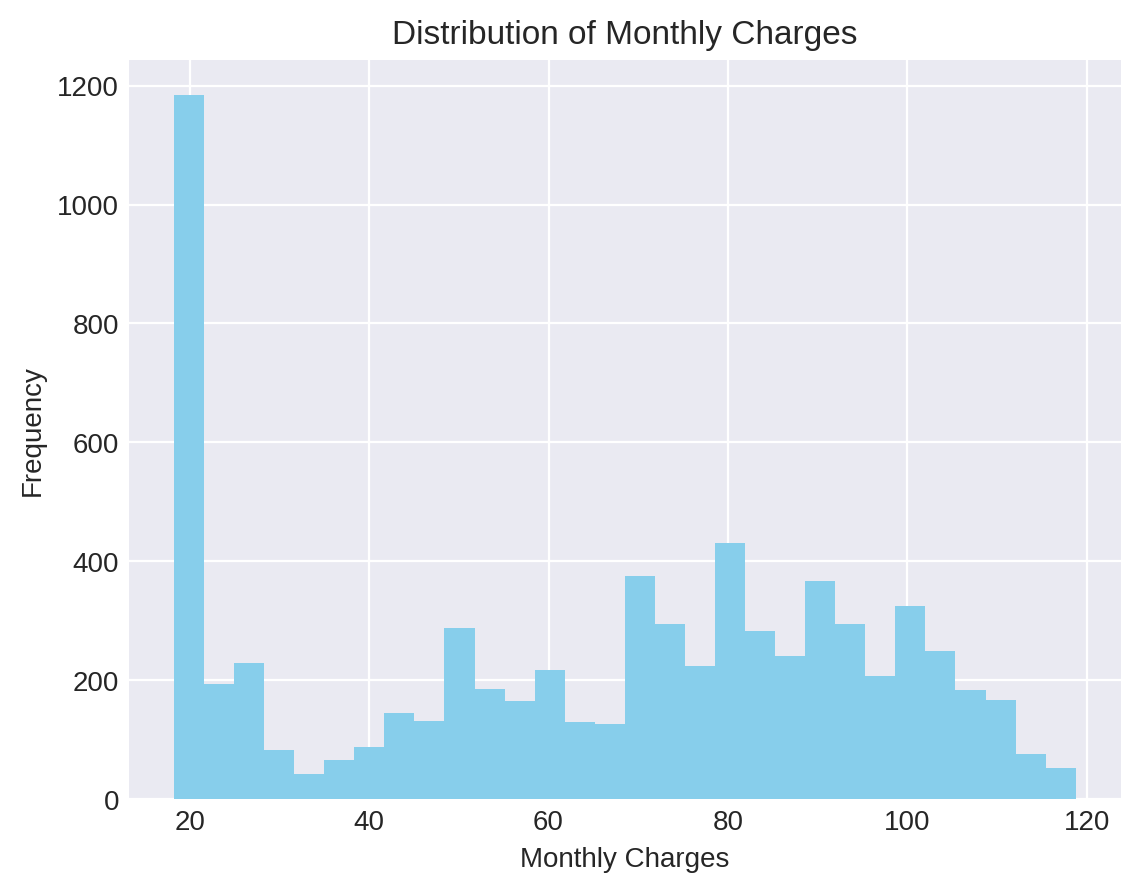

In [45]:
# Histograma de MonthlyCharges
plt.hist(df_contract_new['MonthlyCharges'], bins=30, color='skyblue')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Charges')
plt.show()

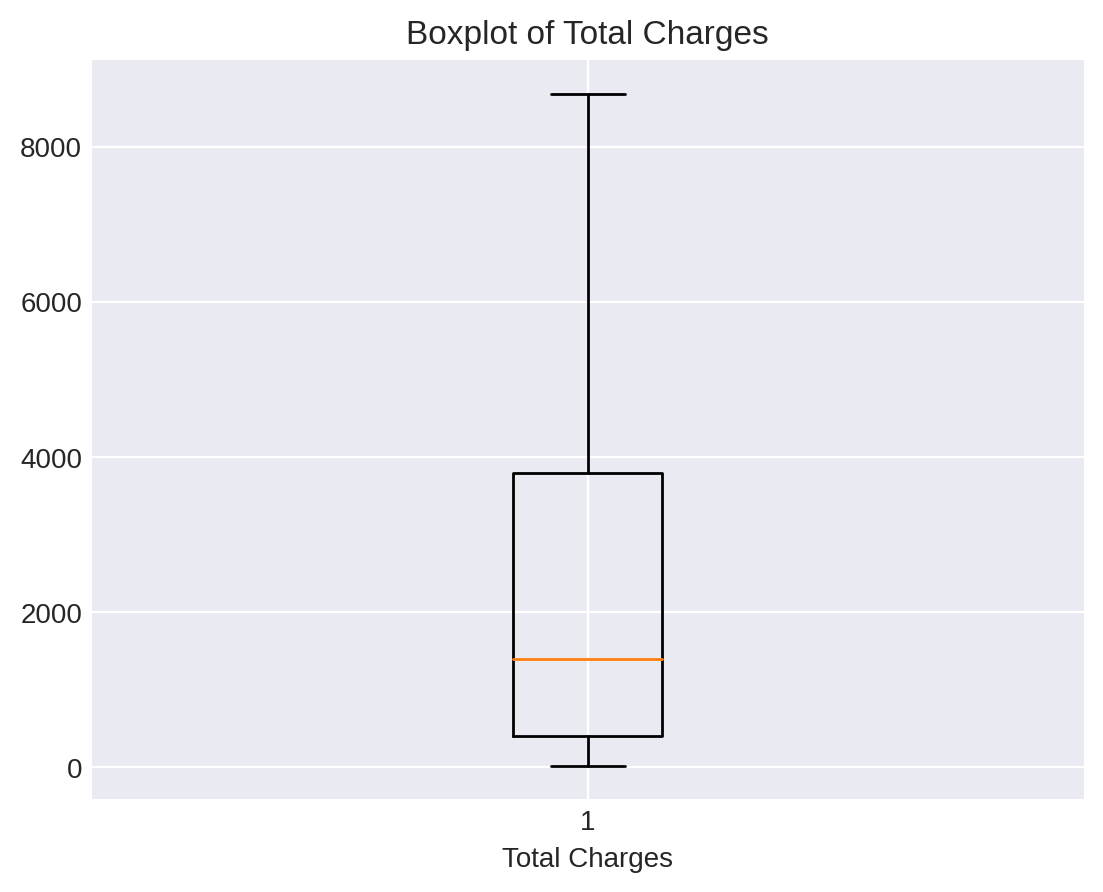

In [46]:
# Convertir la columna TotalCharges a tipo numérico
df_contract_new['TotalCharges'] = pd.to_numeric(df_contract_new['TotalCharges'], errors='coerce')

# Eliminar filas con valores nulos en TotalCharges (si es necesario)
df_contract_new.dropna(subset=['TotalCharges'], inplace=True)

# Trazar el diagrama de caja de TotalCharges
plt.boxplot(df_contract_new['TotalCharges'])
plt.xlabel('Total Charges')
plt.title('Boxplot of Total Charges')
plt.show()

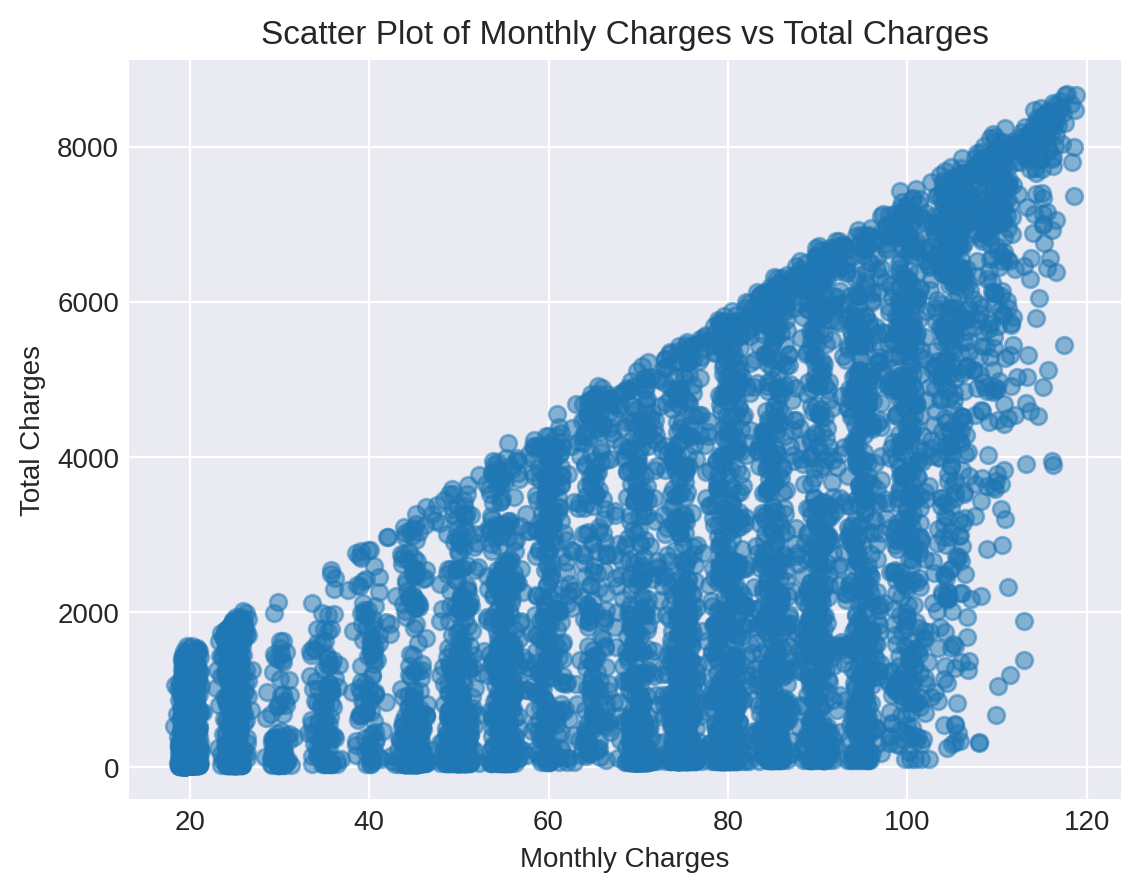

In [47]:
# Gráfico de dispersión de MonthlyCharges vs TotalCharges
plt.scatter(df_contract_new['MonthlyCharges'], df_contract_new['TotalCharges'], alpha=0.5)
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.title('Scatter Plot of Monthly Charges vs Total Charges')
plt.show()

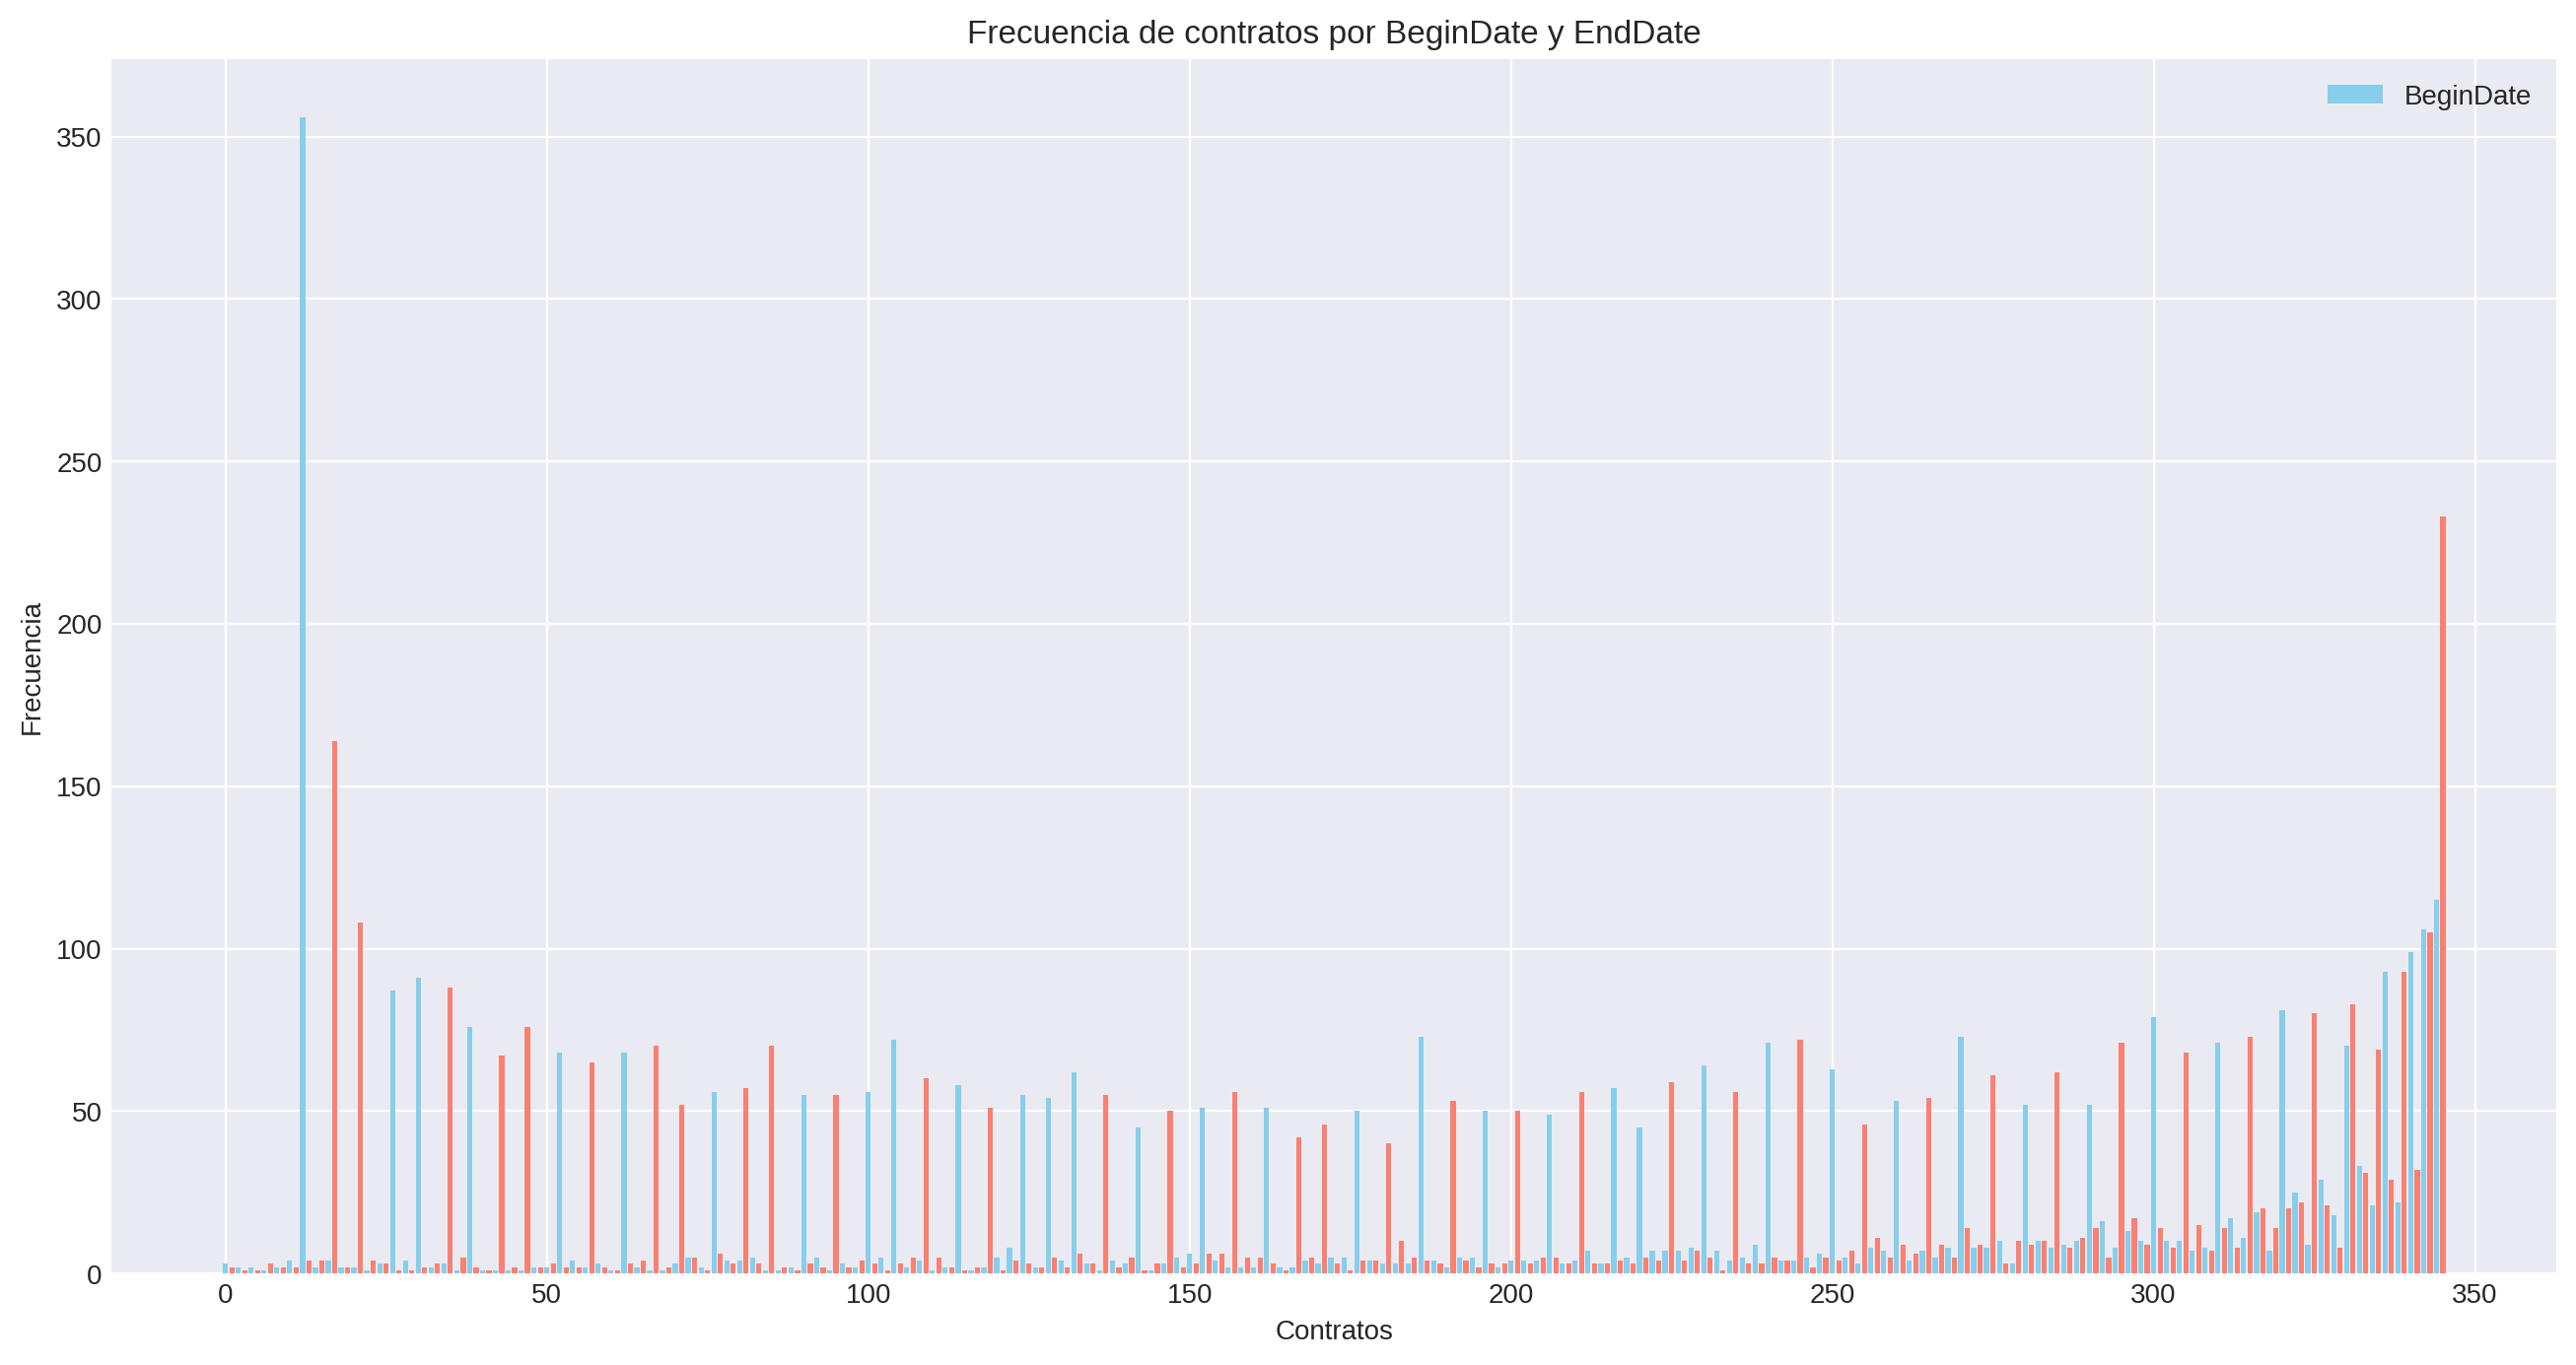

In [48]:
# Contar el número de contratos por BeginDate y EndDate
contract_counts = df_contract_new.groupby(['BeginDate', 'EndDate']).size().reset_index(name='Counts')

# Crear un gráfico de barras más grande
plt.figure(figsize=(16, 8))

# Definir colores diferentes para BeginDate y EndDate
colors = ['skyblue', 'salmon']

# Crear un gráfico de barras con colores distintos para BeginDate y EndDate
plt.bar(contract_counts.index, contract_counts['Counts'], color=colors)
plt.xlabel('Contratos')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de contratos por BeginDate y EndDate')
plt.legend(['BeginDate', 'EndDate'])
plt.show()

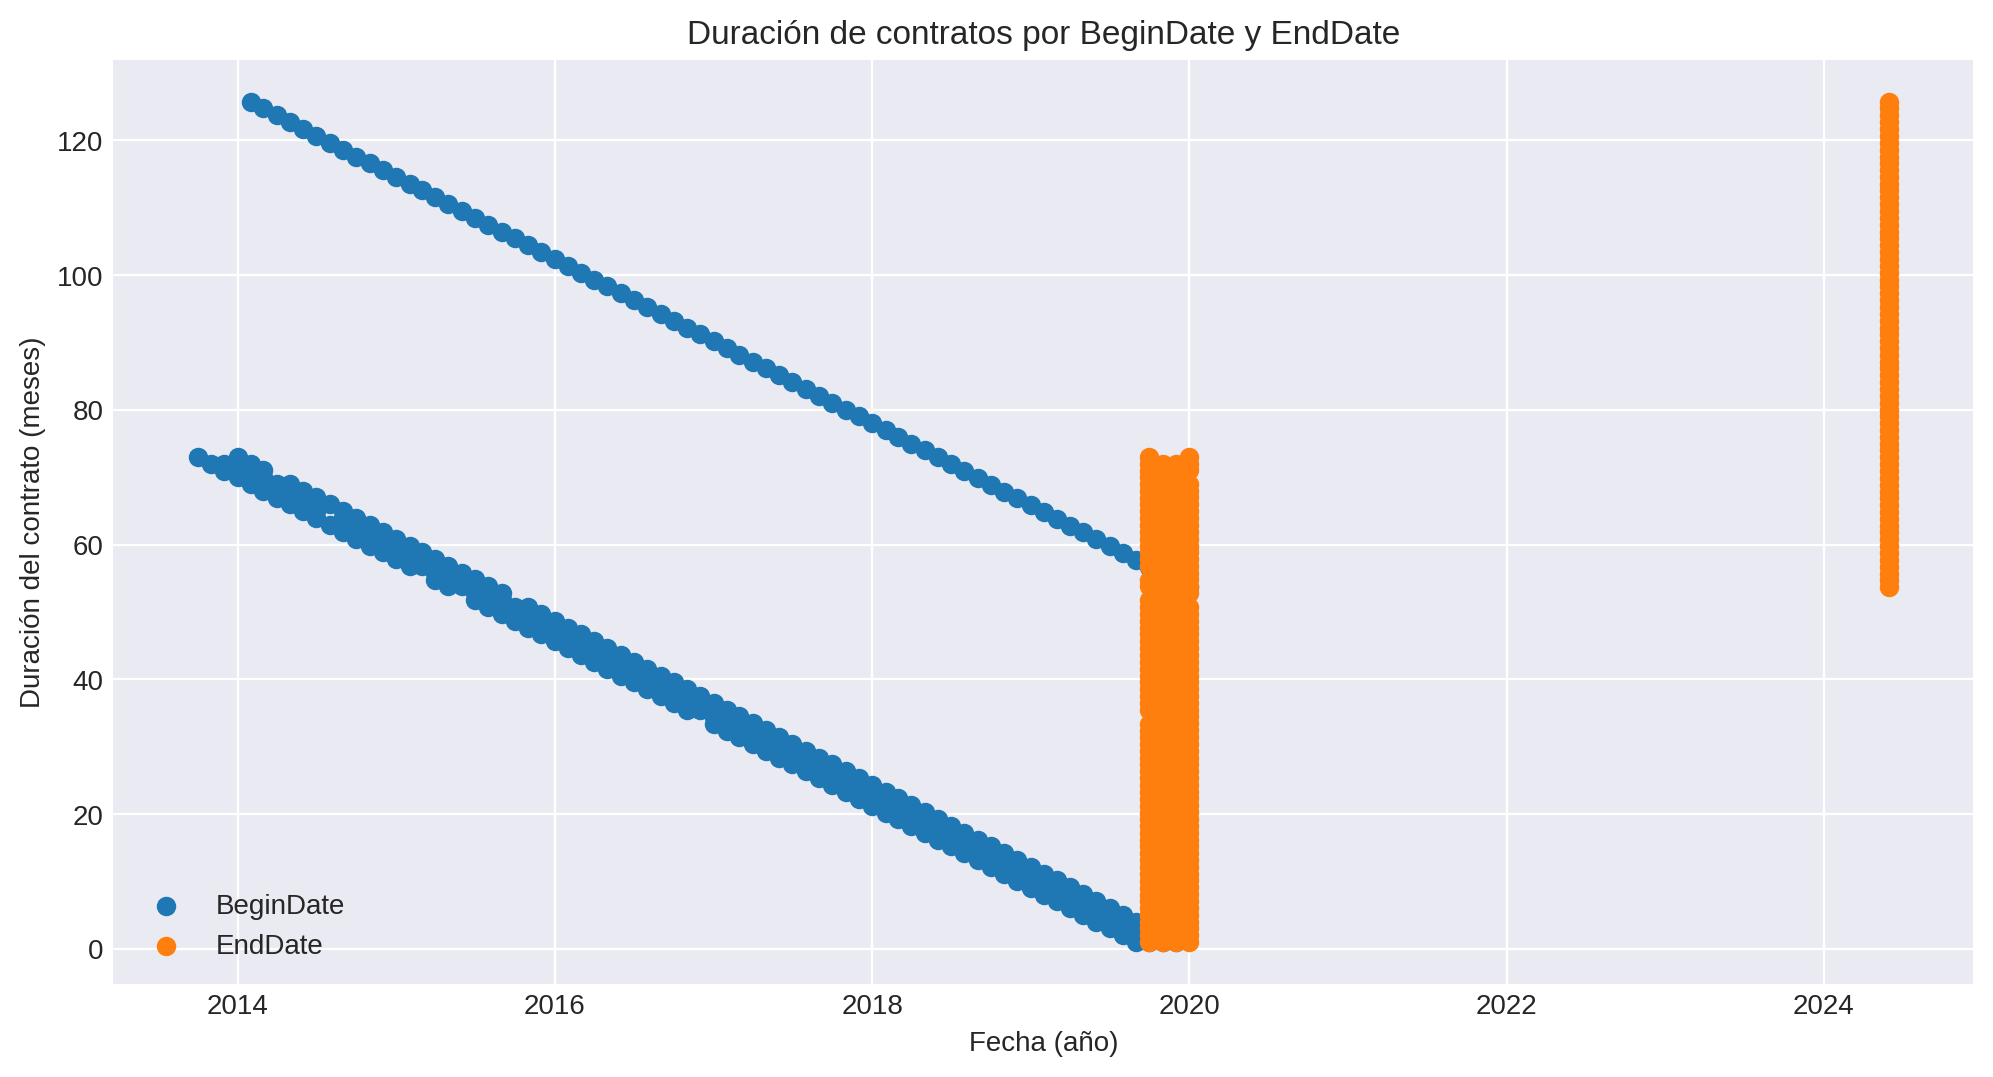

In [49]:
# Calcular la duración del contrato restando EndDate - BeginDate
contract_counts['Duration'] = (contract_counts['EndDate'] - contract_counts['BeginDate']).dt.days / 30

# Crear un gráfico de dispersión
plt.figure(figsize=(12, 6))
plt.scatter(contract_counts['BeginDate'], contract_counts['Duration'], label='BeginDate')
plt.scatter(contract_counts['EndDate'], contract_counts['Duration'], label='EndDate')
plt.xlabel('Fecha (año)')
plt.ylabel('Duración del contrato (meses)')
plt.title('Duración de contratos por BeginDate y EndDate')
plt.legend()
plt.show()

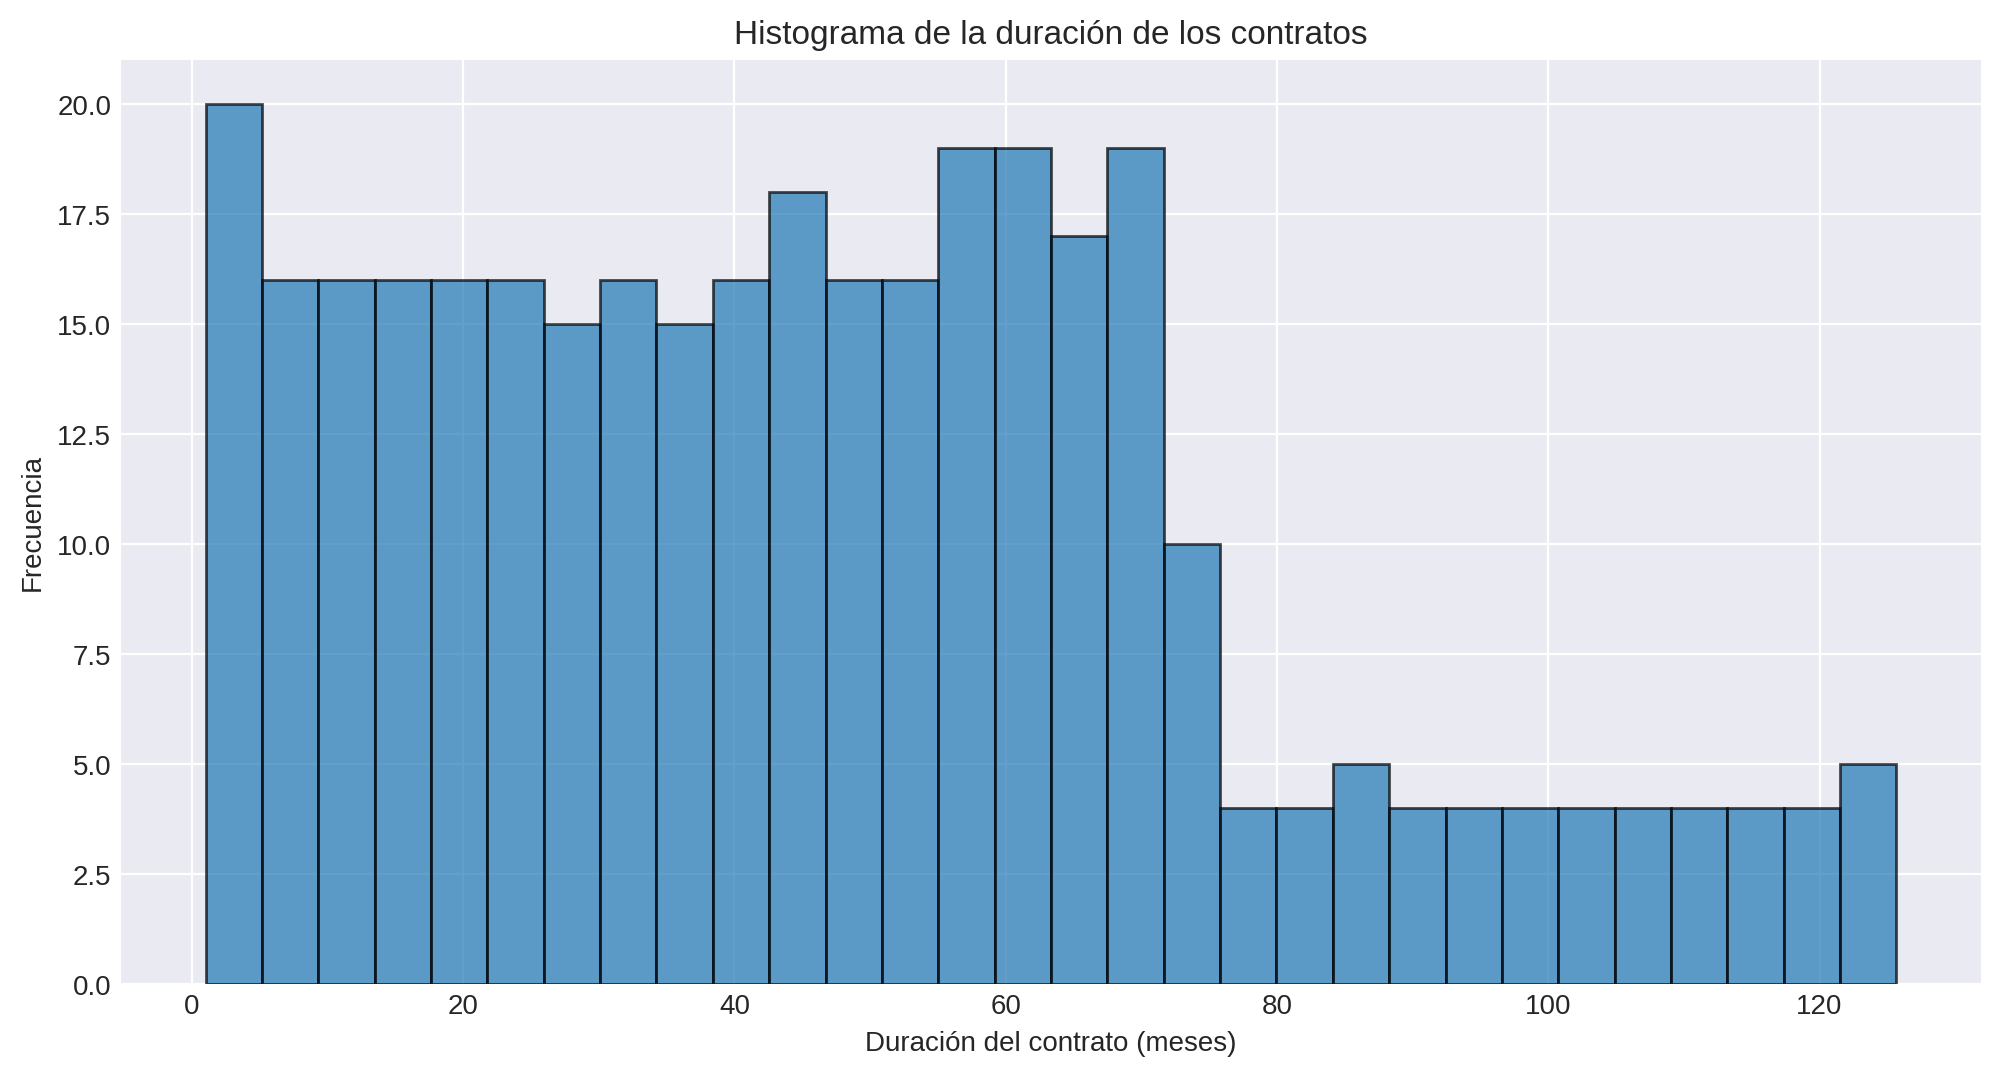

In [50]:
# Calcular la duración del contrato restando EndDate - BeginDate
contract_counts['Duration'] = (contract_counts['EndDate'] - contract_counts['BeginDate']).dt.days / 30

# Crear un histograma de la duración de los contratos
plt.figure(figsize=(12, 6))
plt.hist(contract_counts['Duration'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Duración del contrato (meses)')
plt.ylabel('Frecuencia')
plt.title('Histograma de la duración de los contratos')
plt.show()

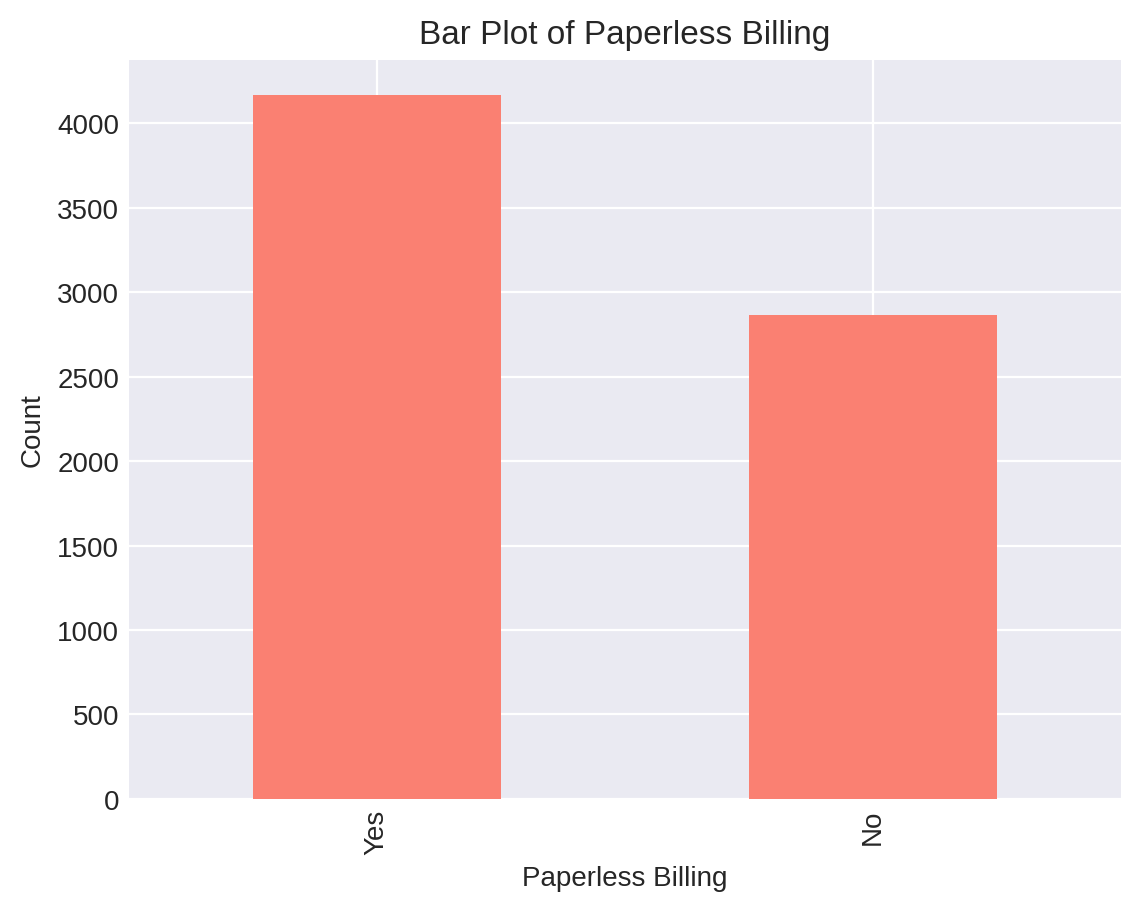

In [51]:
# Gráfico de barras de PaperlessBilling
df_contract_new['PaperlessBilling'].value_counts().plot(kind='bar', color='salmon')
plt.xlabel('Paperless Billing')
plt.ylabel('Count')
plt.title('Bar Plot of Paperless Billing')
plt.show()

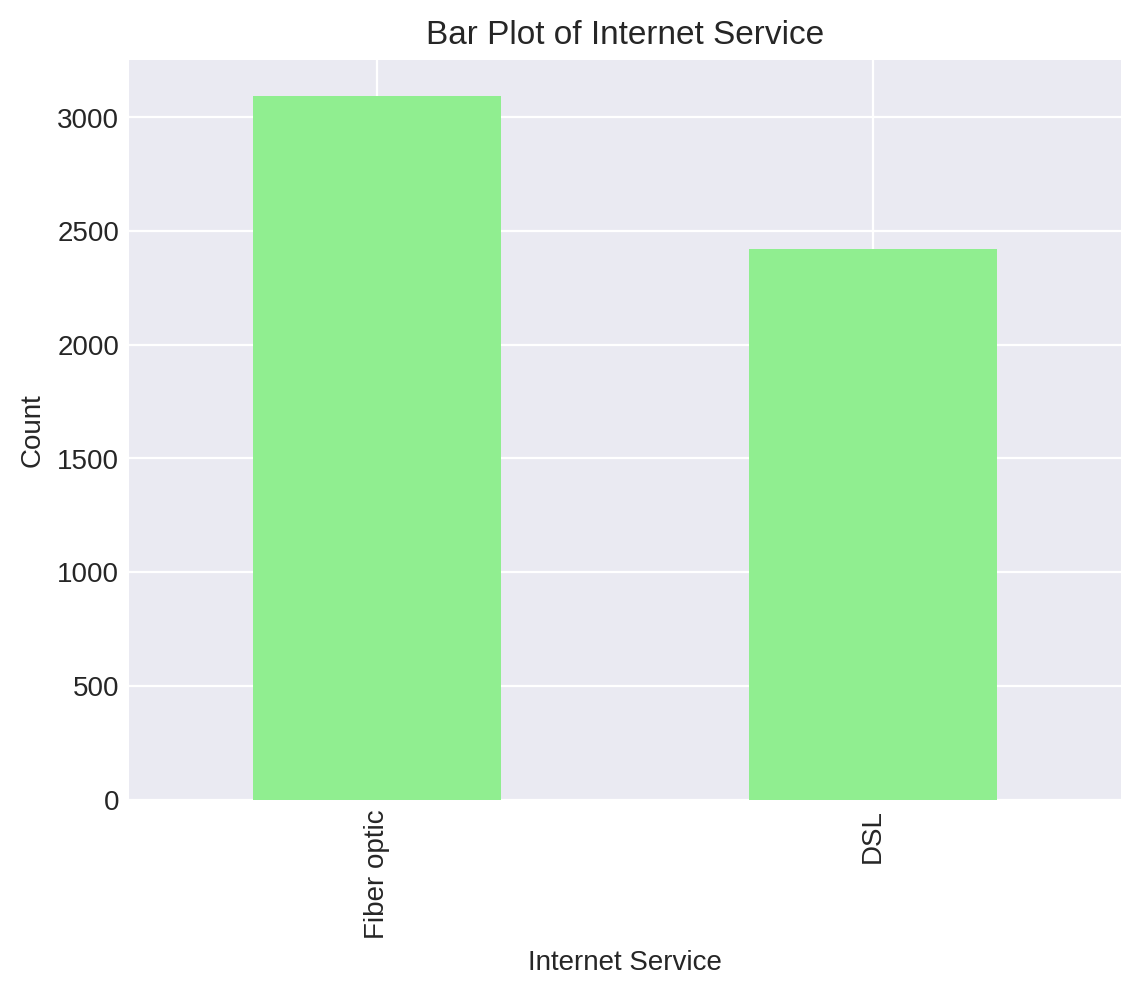

In [52]:
# Gráfico de barras de InternetService
df_internet_new['InternetService'].value_counts().plot(kind='bar', color='lightgreen')
plt.xlabel('Internet Service')
plt.ylabel('Count')
plt.title('Bar Plot of Internet Service')
plt.show()

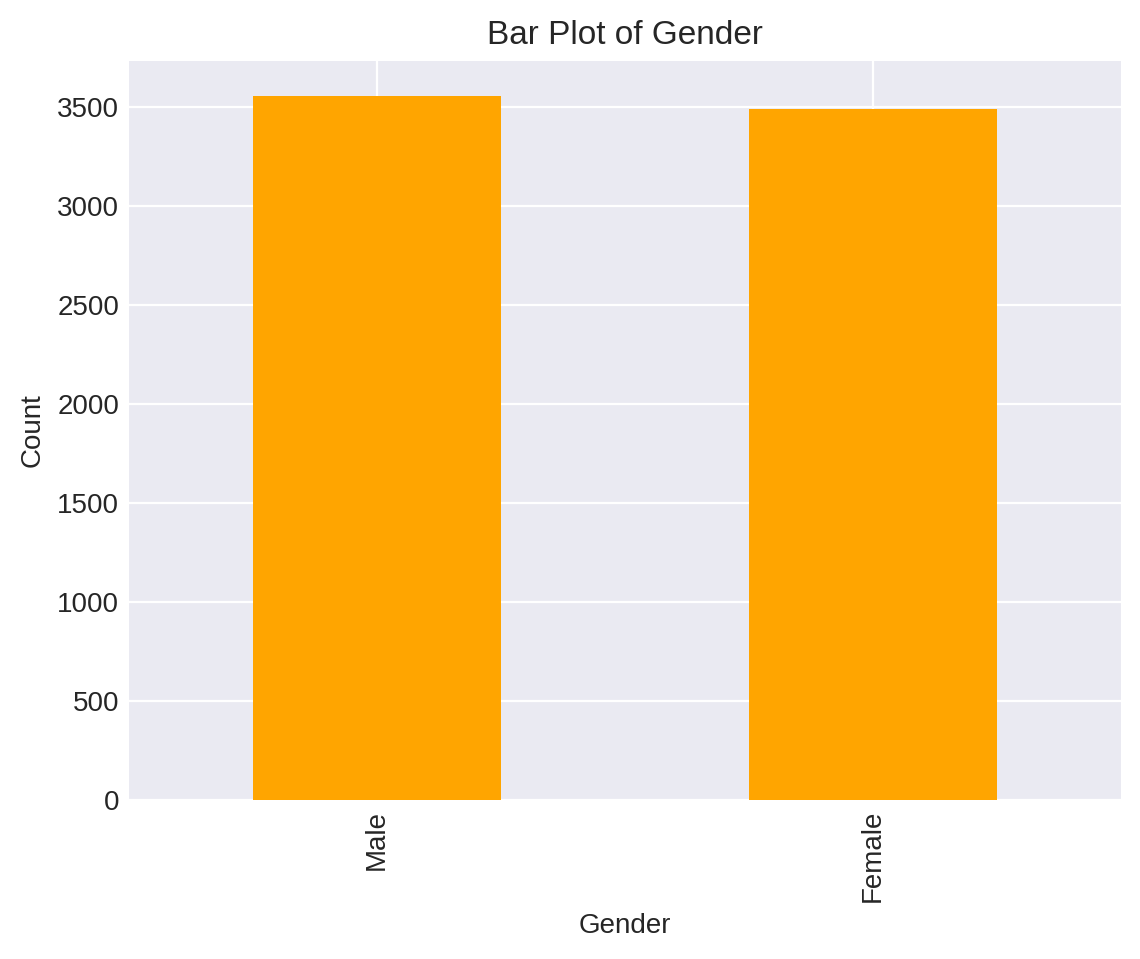

In [53]:
# Gráfico de barras de gender
df_personal_new['gender'].value_counts().plot(kind='bar', color='orange')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Bar Plot of Gender')
plt.show()

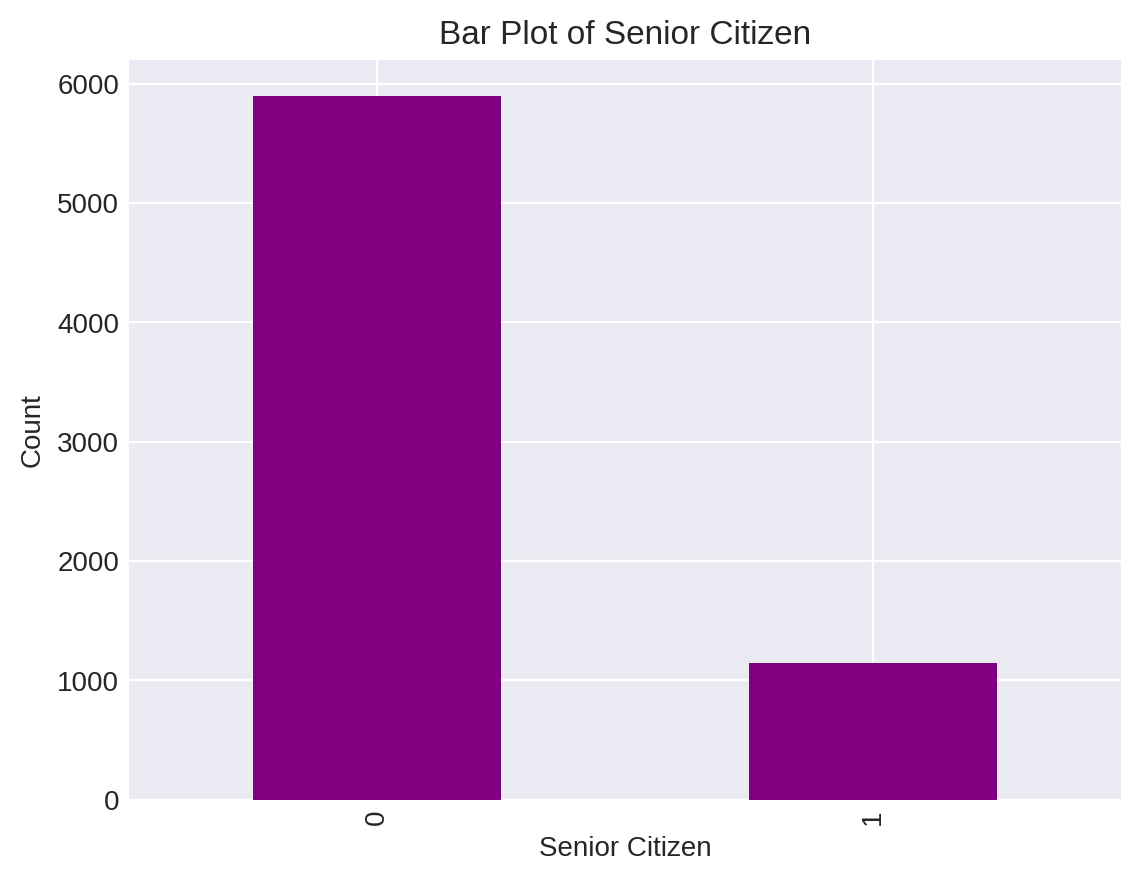

In [54]:
# Gráfico de barras de SeniorCitizen
df_personal_new['SeniorCitizen'].value_counts().plot(kind='bar', color='purple')
plt.xlabel('Senior Citizen')
plt.ylabel('Count')
plt.title('Bar Plot of Senior Citizen')
plt.show()

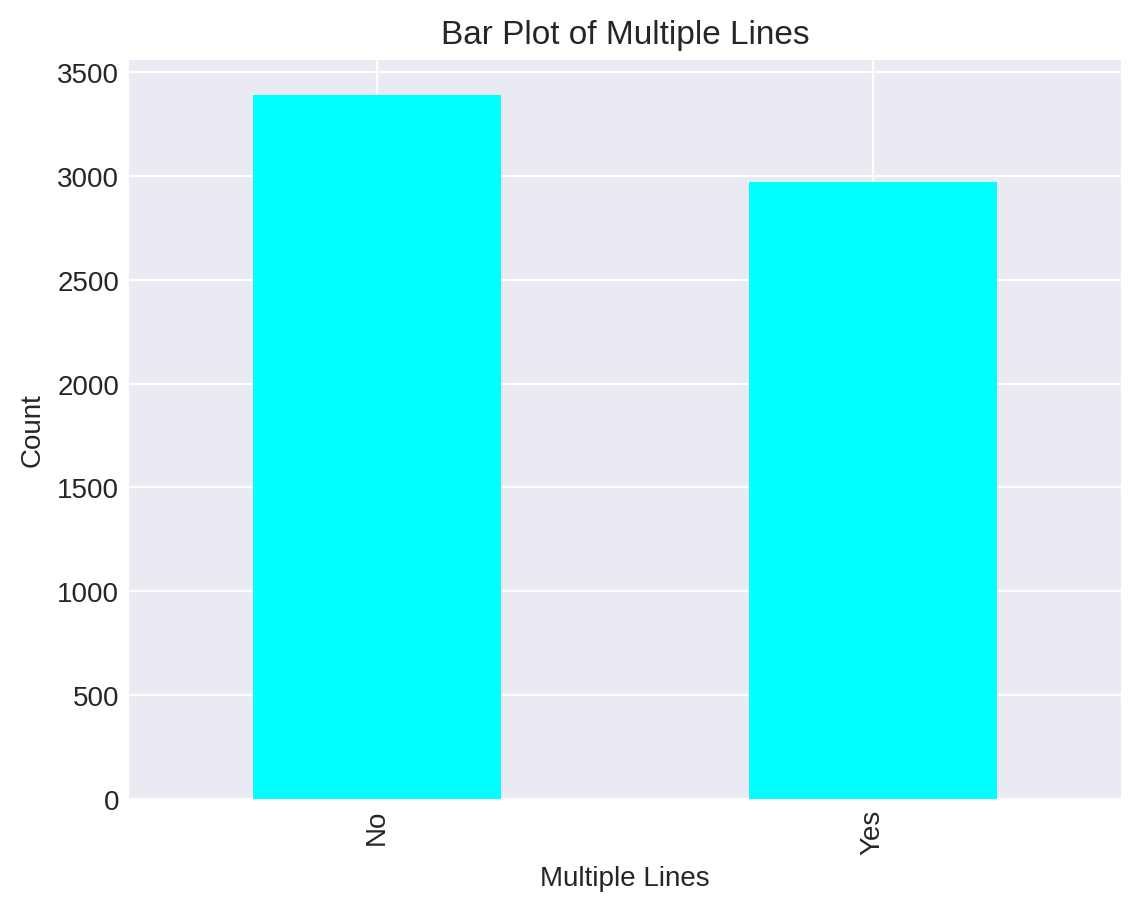

In [55]:
# Gráfico de barras de MultipleLines
df_phone_new['MultipleLines'].value_counts().plot(kind='bar', color='cyan')
plt.xlabel('Multiple Lines')
plt.ylabel('Count')
plt.title('Bar Plot of Multiple Lines')
plt.show()

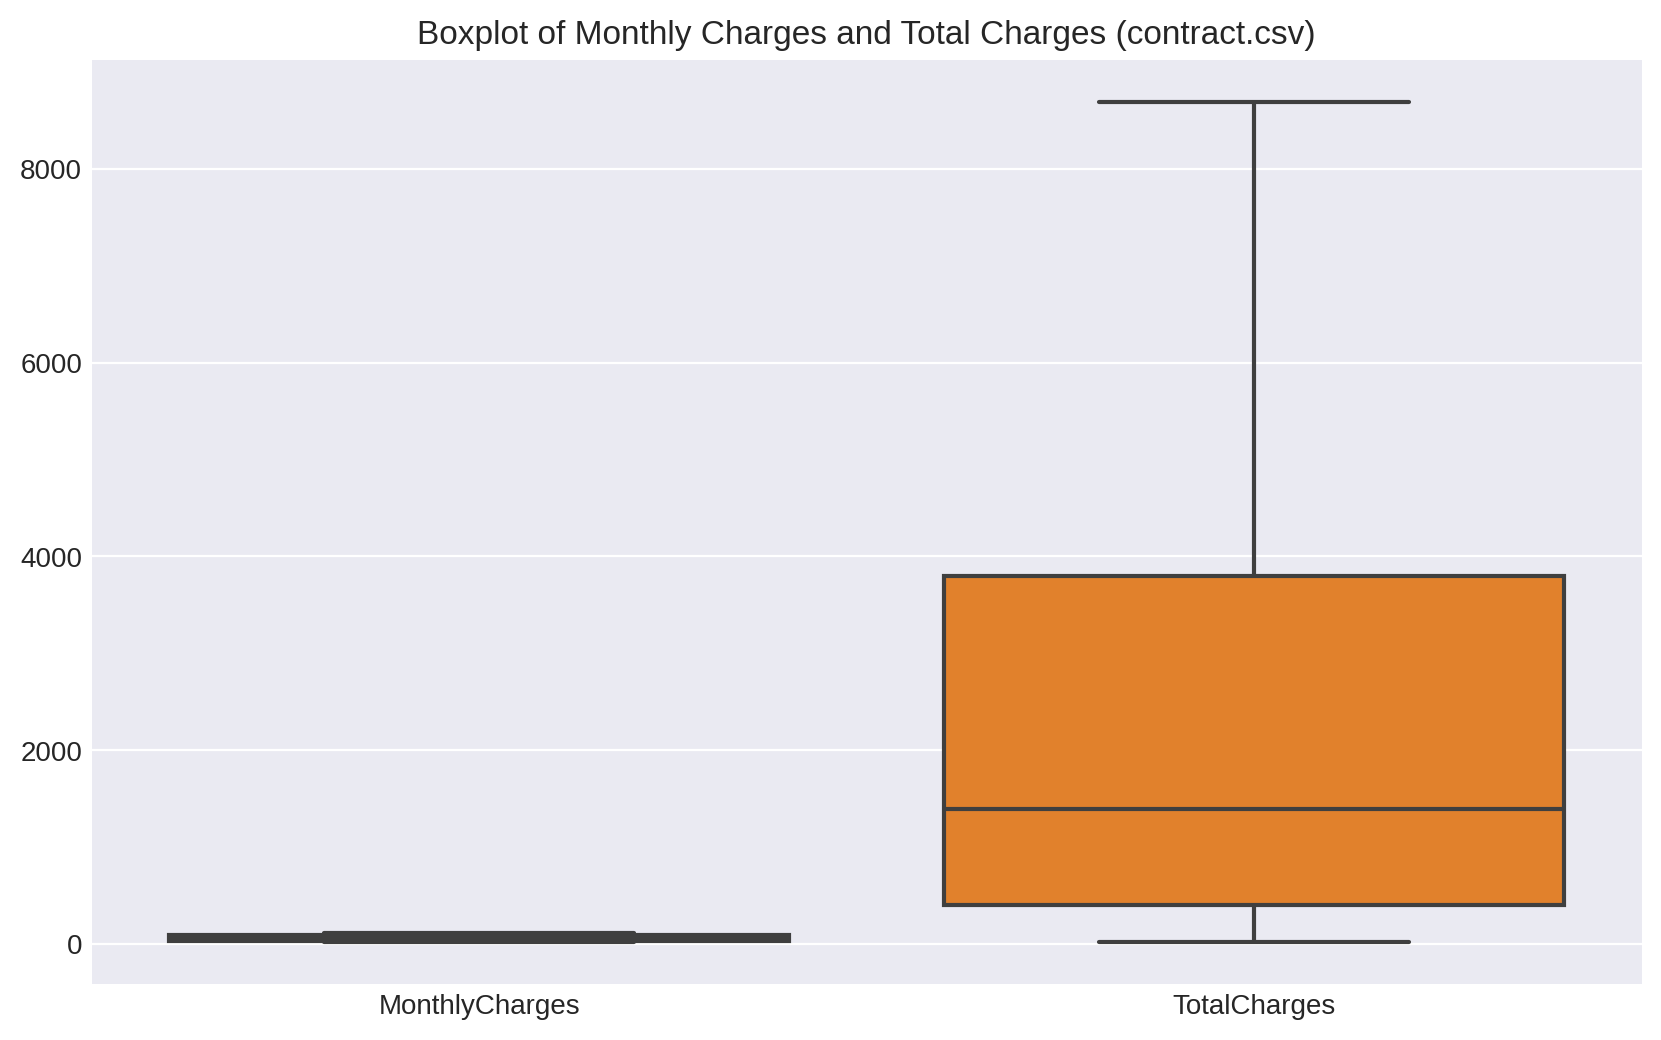

Valores atípicos en contract.csv:
Empty DataFrame
Columns: [BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges]
Index: []


In [56]:
# Convertir la columna 'TotalCharges' a tipo numérico
df_contract_new['TotalCharges'] = pd.to_numeric(df_contract_new['TotalCharges'], errors='coerce')

# Visualización con gráfico de caja
plt.figure(figsize=(10,6))
sns.boxplot(data=df_contract_new[['MonthlyCharges', 'TotalCharges']])
plt.title('Boxplot of Monthly Charges and Total Charges (contract.csv)')
plt.show()

# Cálculo del rango intercuartílico (IQR)
Q1 = df_contract_new['TotalCharges'].quantile(0.25)
Q3 = df_contract_new['TotalCharges'].quantile(0.75)
IQR = Q3 - Q1

# Límites superior e inferior para valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificación de valores atípicos
outliers_contract = df_contract_new[(df_contract_new['TotalCharges'] < lower_bound) | (df_contract_new['TotalCharges'] > upper_bound)]
print("Valores atípicos en contract.csv:")
print(outliers_contract)

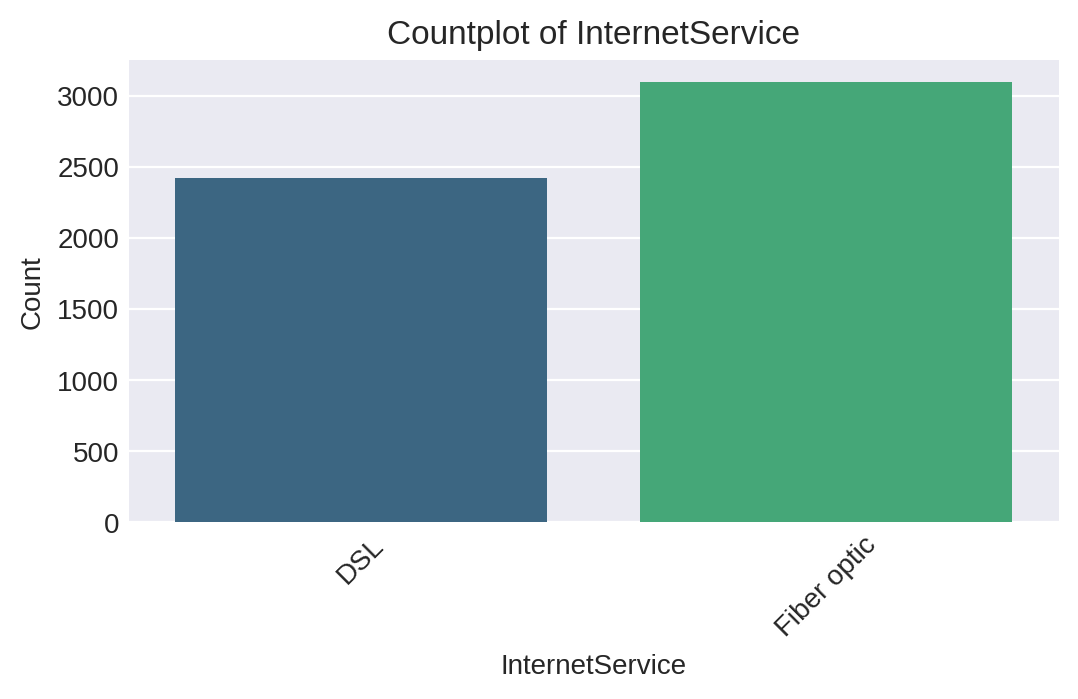

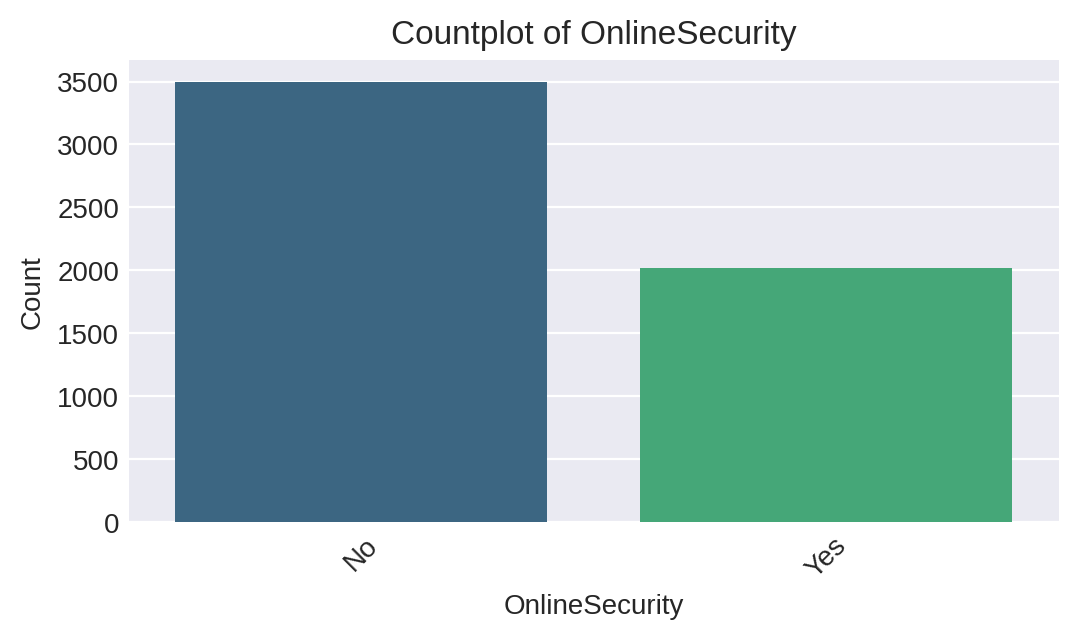

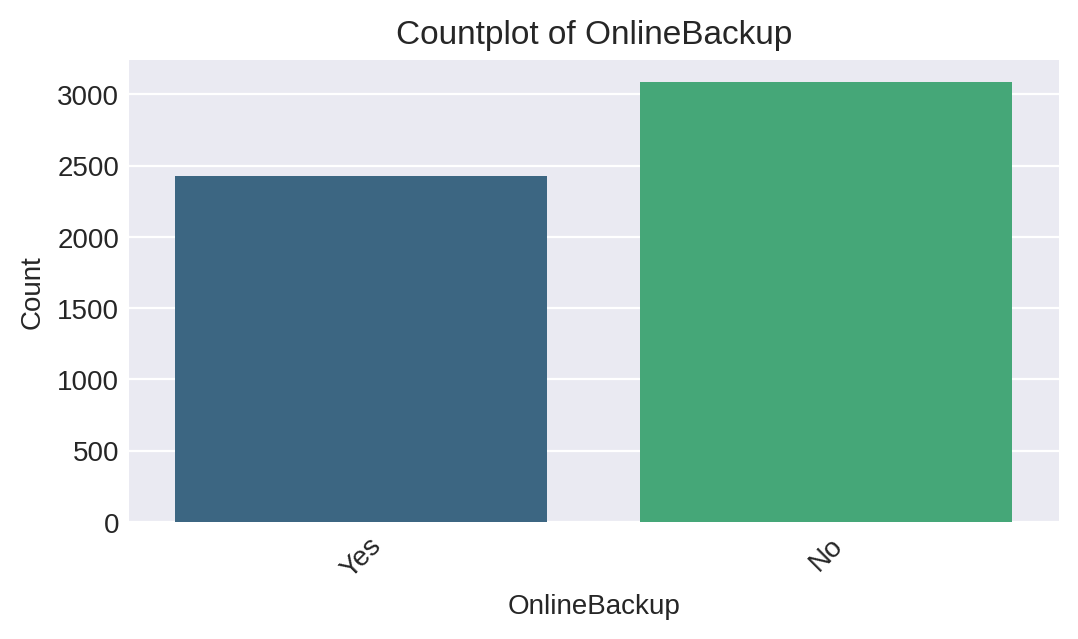

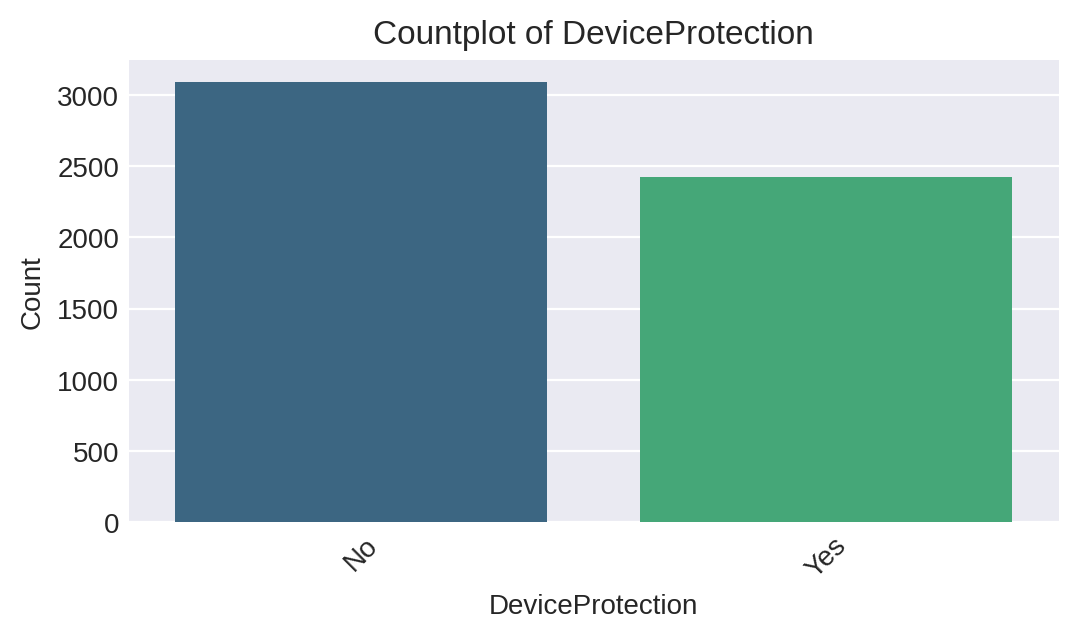

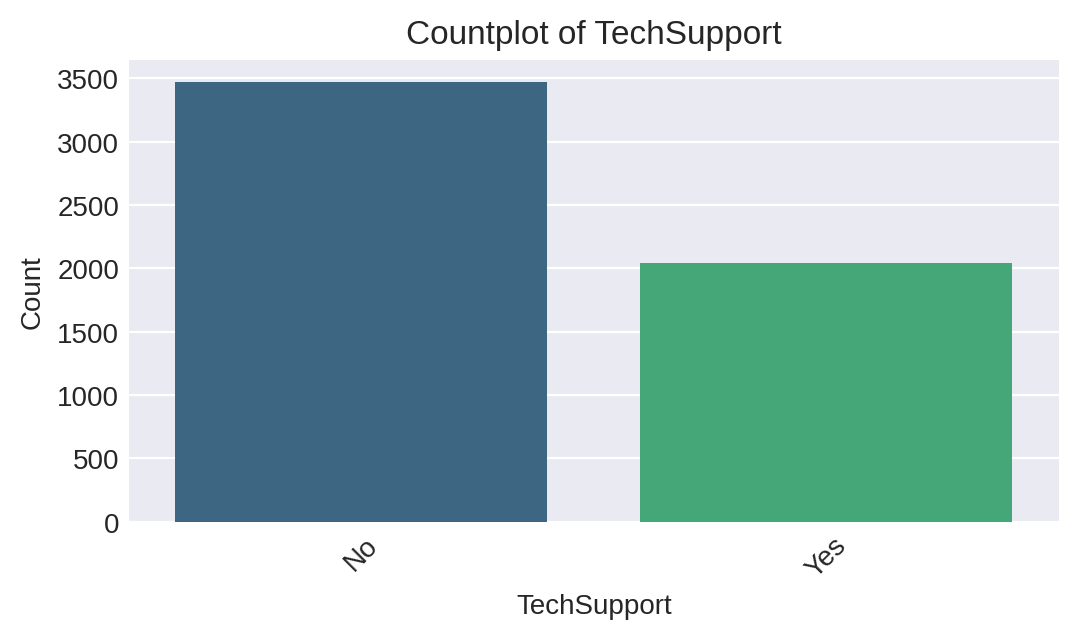

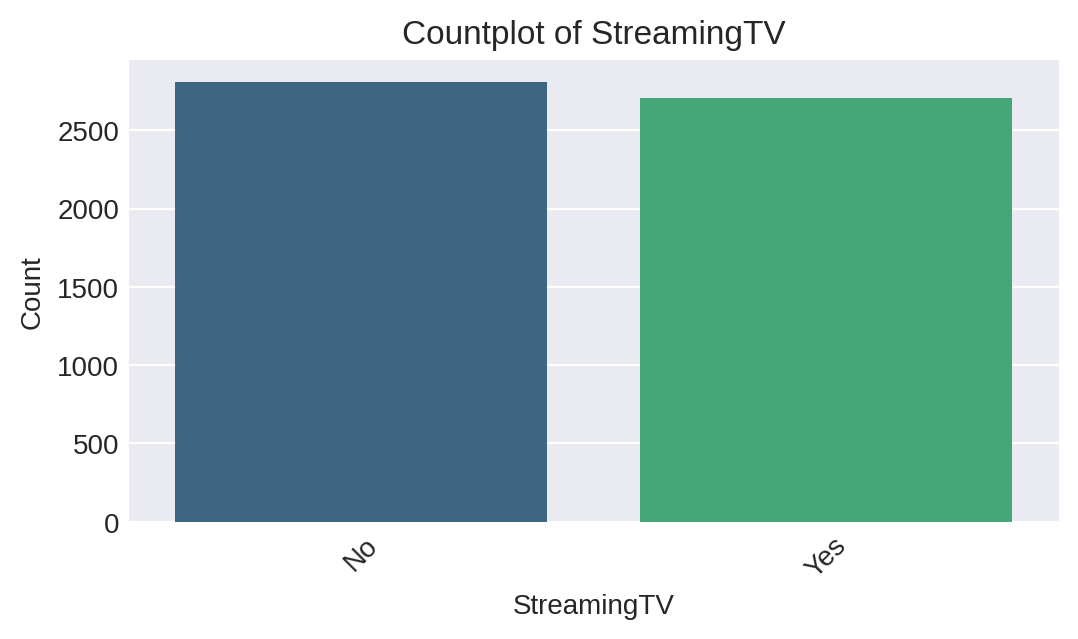

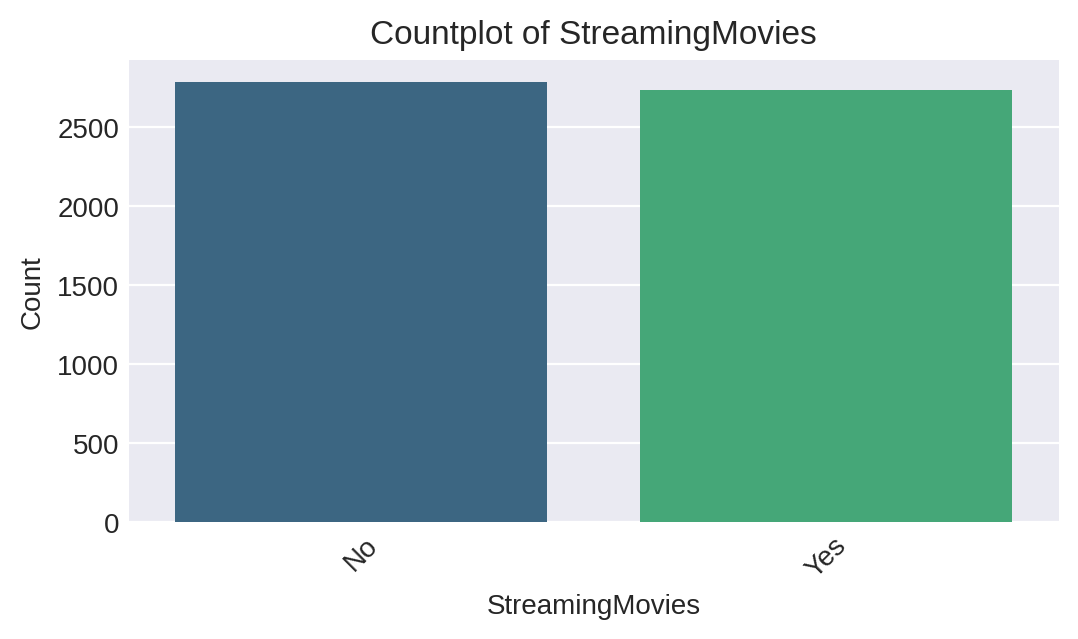

In [57]:
# Visualización con gráfico de barras para cada columna
for column in df_internet_new.columns:
    plt.figure(figsize=(6,3))
    sns.countplot(data=df_internet, x=column, palette='viridis')
    plt.title(f'Countplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

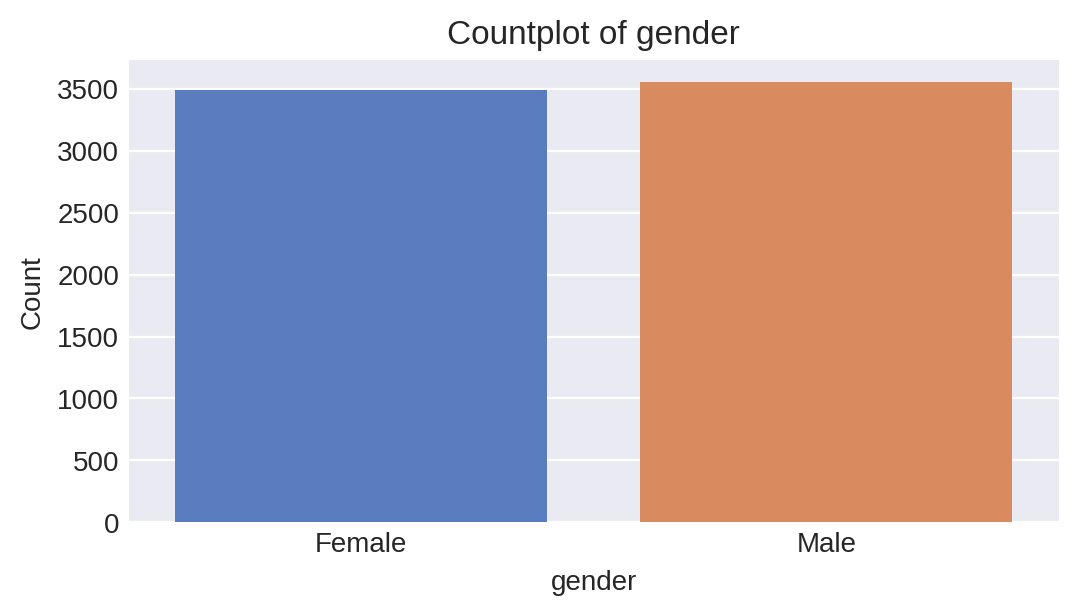

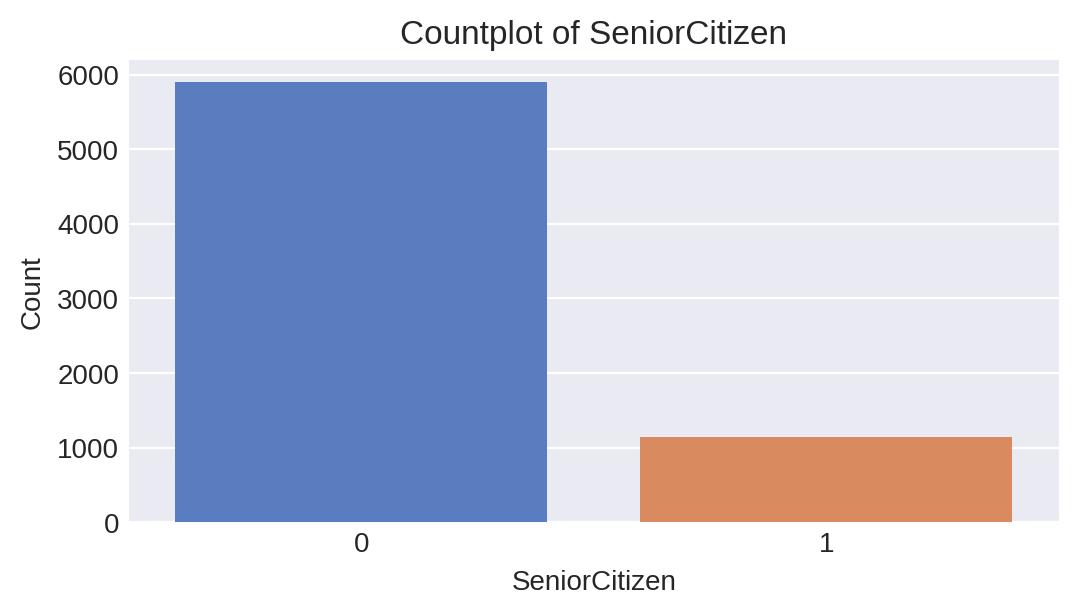

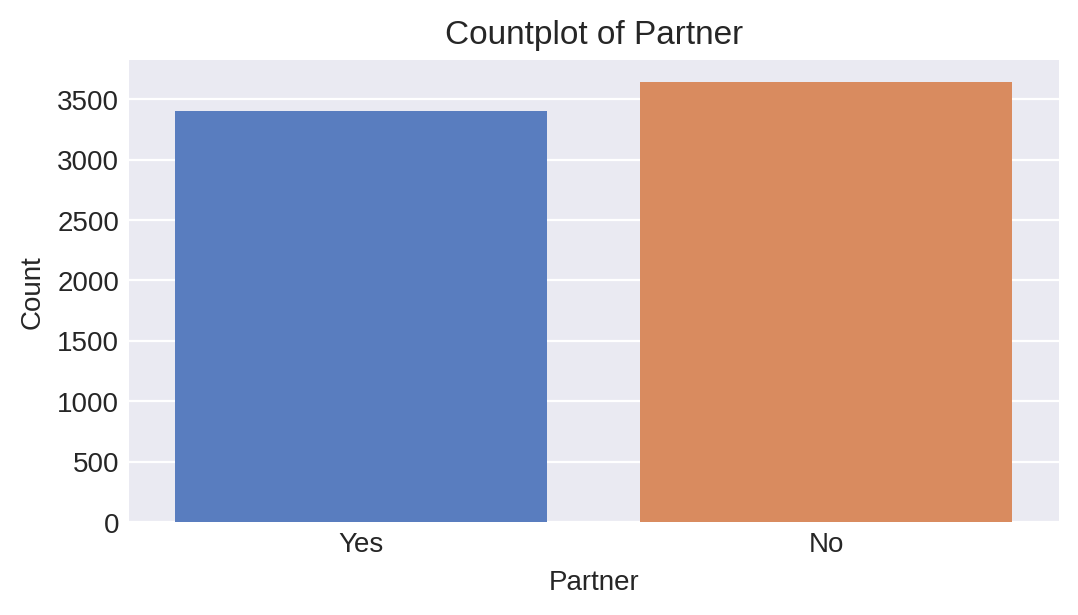

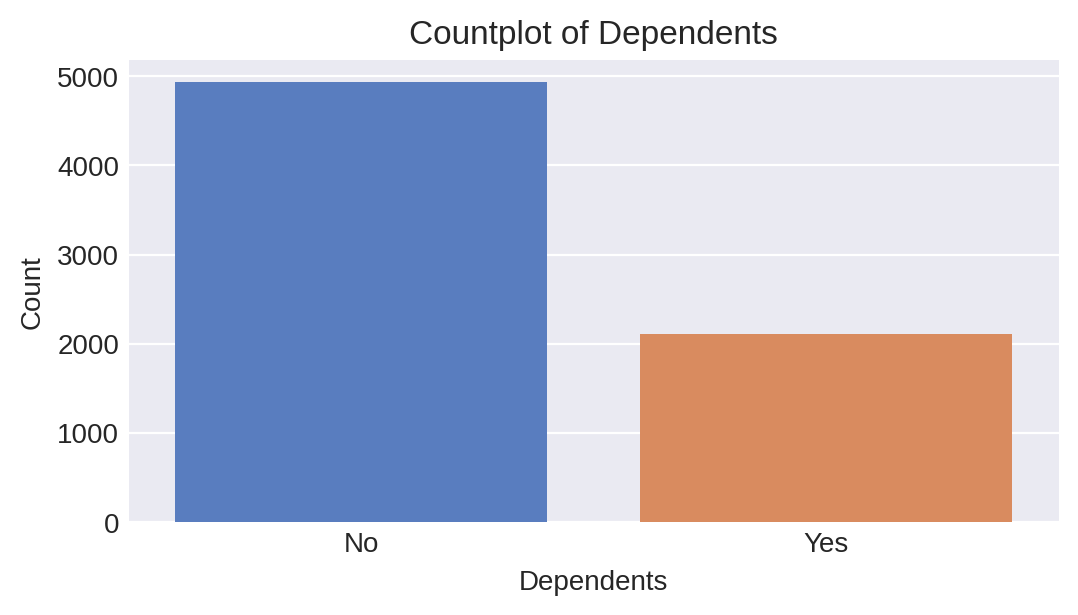

In [58]:
# Visualización con gráfico de barras para cada columna en personal.csv
for column in df_personal_new.columns:
    plt.figure(figsize=(6,3))
    sns.countplot(data=df_personal, x=column, palette='muted')
    plt.title(f'Countplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

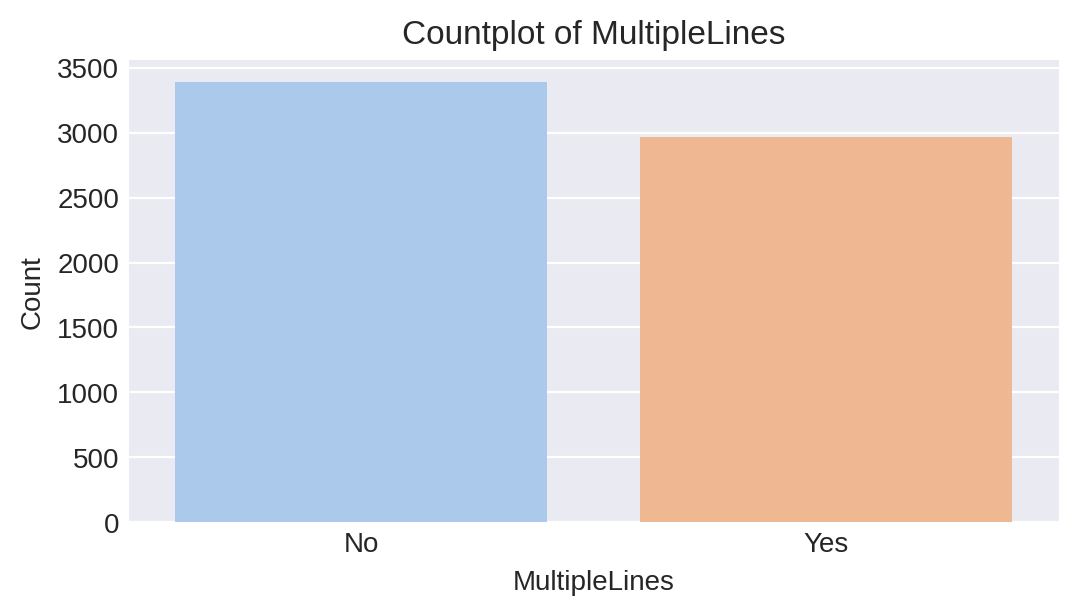

In [59]:
# Visualización con gráfico de barras para la columna 'MultipleLines' en phone.csv
plt.figure(figsize=(6,3))
sns.countplot(data=df_phone_new, x='MultipleLines', palette='pastel')
plt.title('Countplot of MultipleLines')
plt.xlabel('MultipleLines')
plt.ylabel('Count')
plt.show()

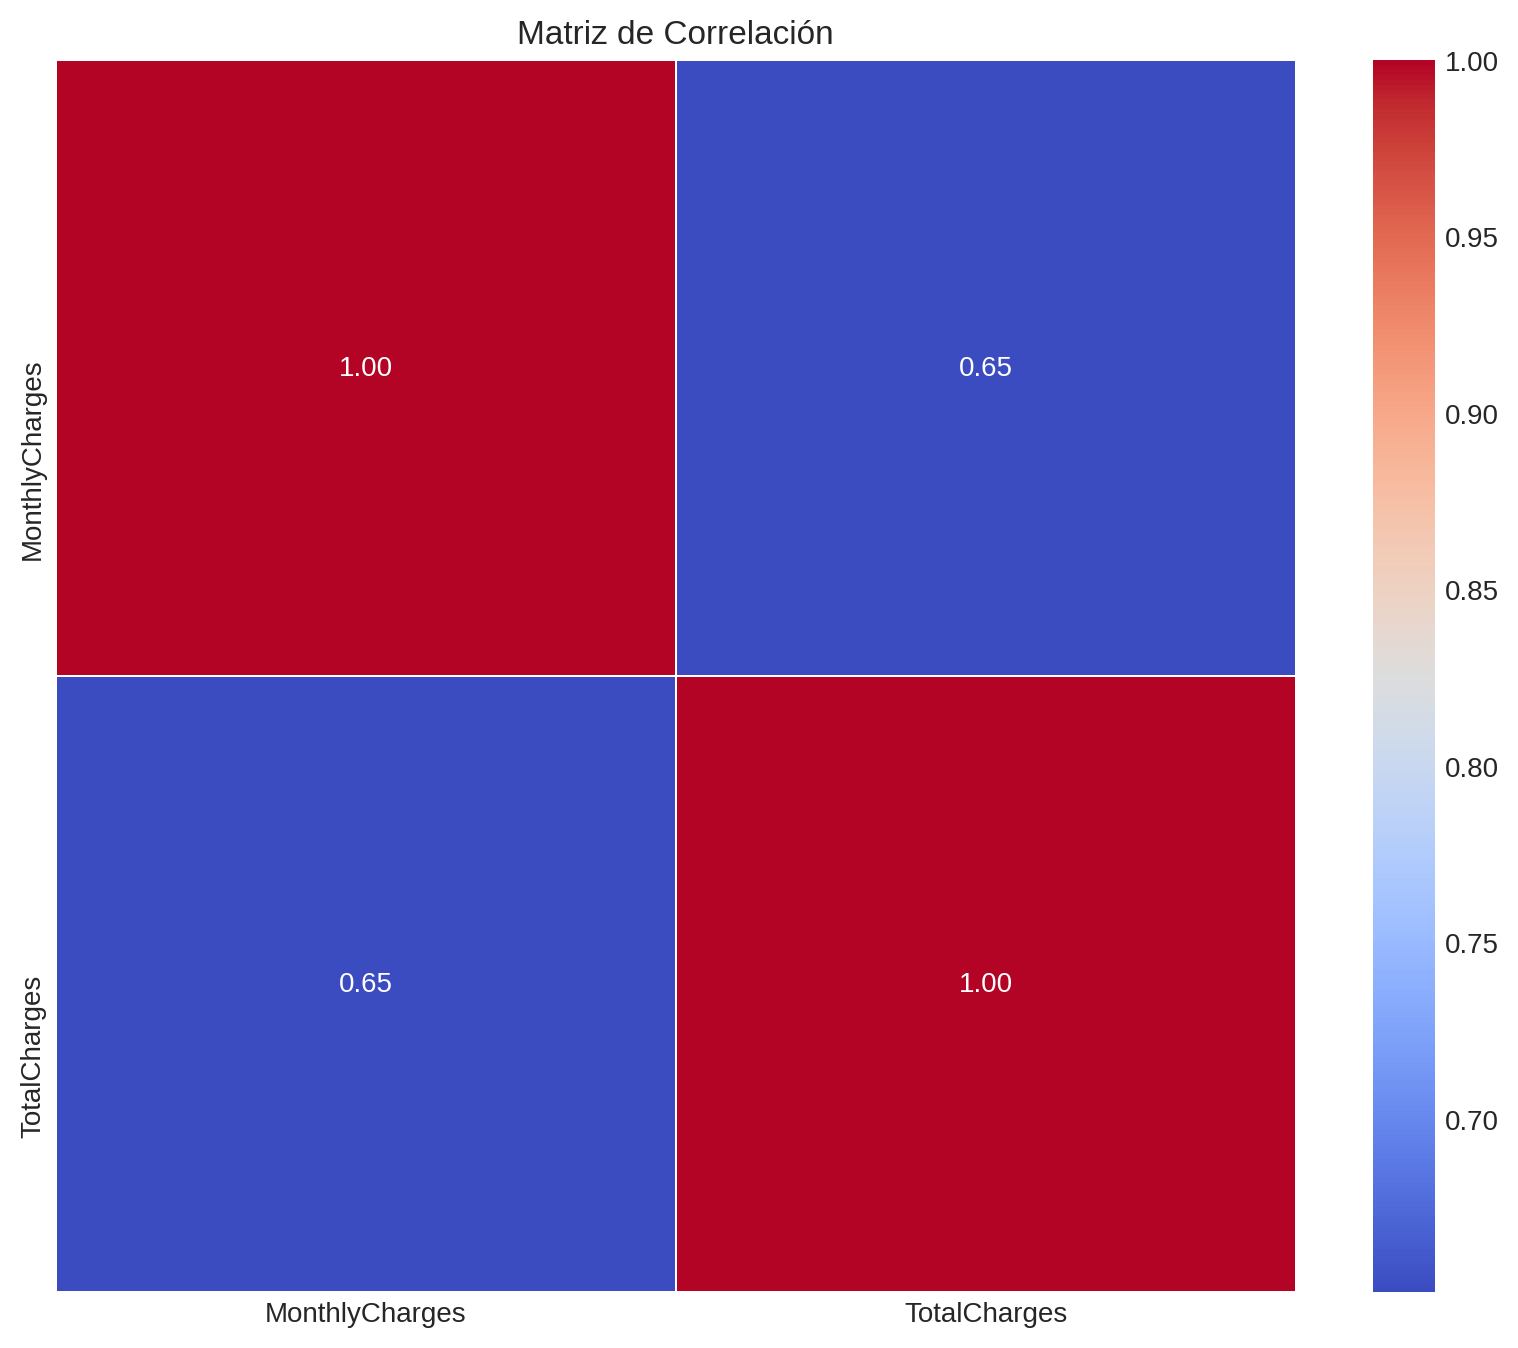

In [60]:
# Calcular la matriz de correlación
correlation_matrix = df_contract_new.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [61]:
# Tabla de contingencia entre InternetService y OnlineSecurity
contingency_table = pd.crosstab(df_internet_new['InternetService'], df_internet_new['OnlineSecurity'])
print(contingency_table)

OnlineSecurity     No   Yes
InternetService            
DSL              1241  1180
Fiber optic      2257   839


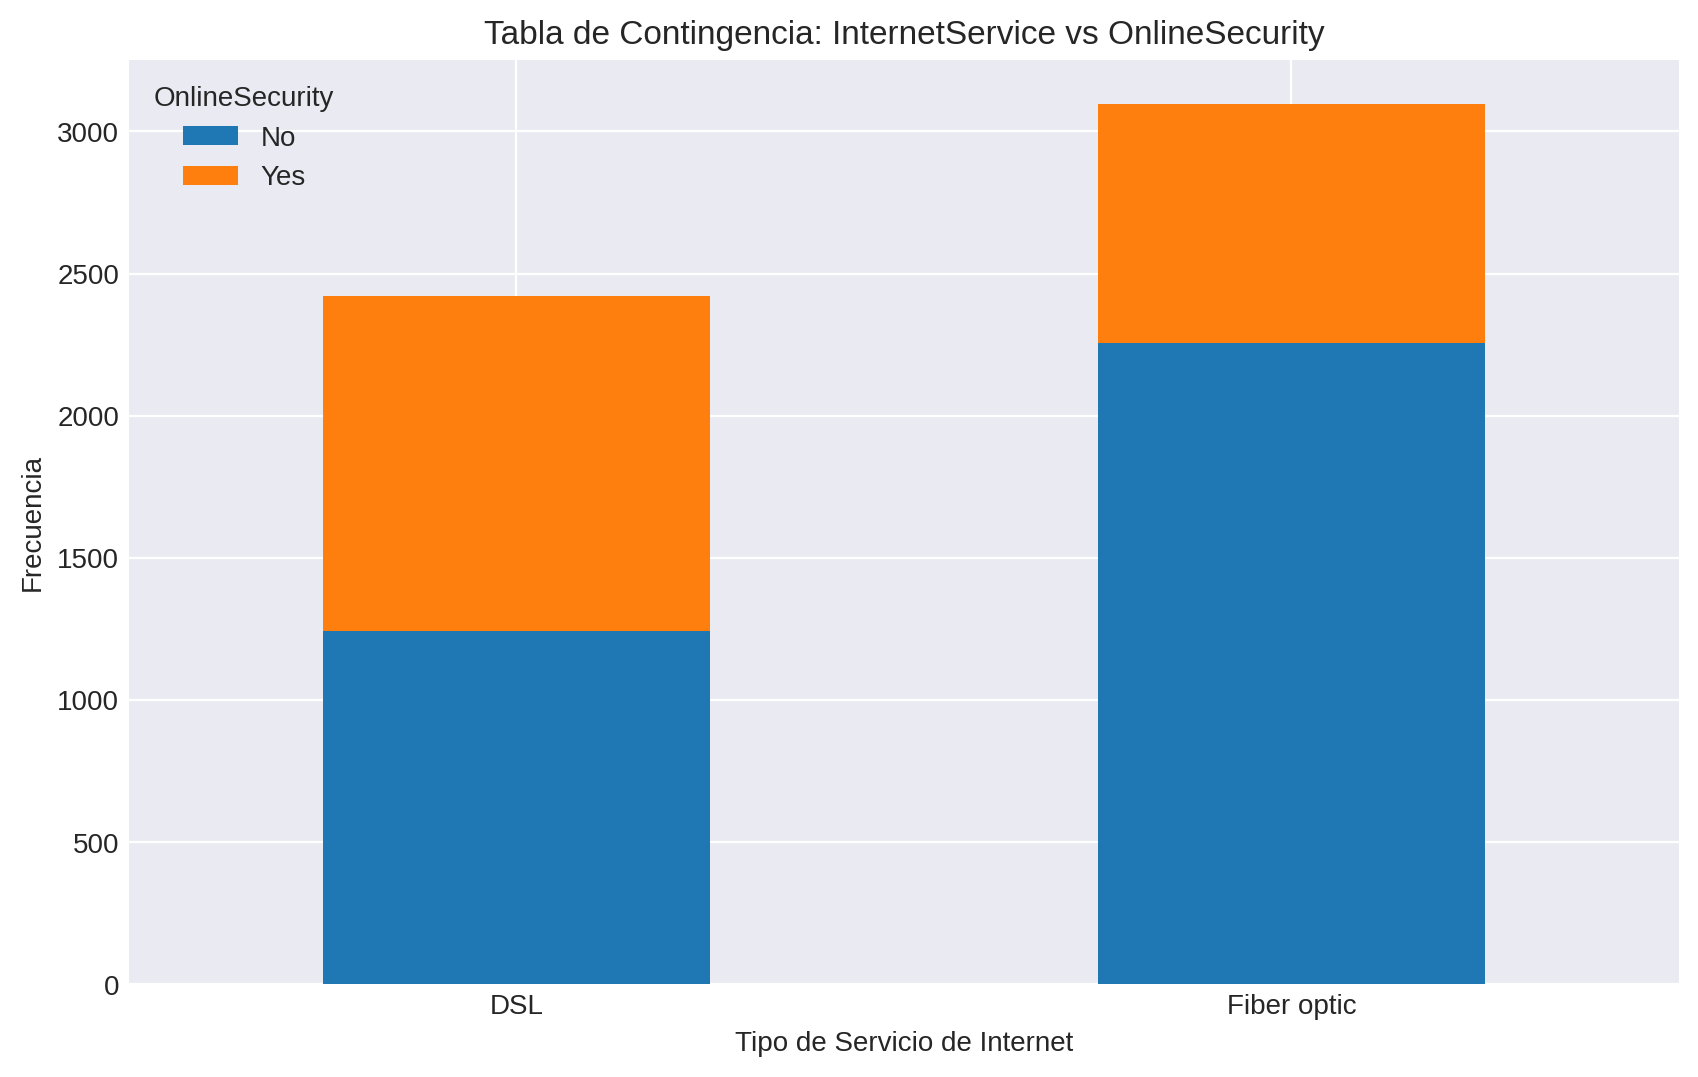

In [62]:
# Visualizar la tabla de contingencia como un gráfico de barras
contingency_table.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Tabla de Contingencia: InternetService vs OnlineSecurity')
plt.xlabel('Tipo de Servicio de Internet')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.legend(title='OnlineSecurity')
plt.show()

In [63]:
# Prueba chi-cuadrado entre InternetService y OnlineSecurity
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-square Statistic:", chi2)
print("p-value:", p)

Chi-square Statistic: 273.27952312896764
p-value: 2.1886037909525943e-61


## Preprocesamiento de Datos

### Creacion Dataset Combinado (df)

In [64]:
# Combinamos los cuatro datasets en un nuevo DataFrame `df` usando la función merge
df = (df_contract.merge(df_personal, how='left', on='customerID')
      .merge(df_internet, how='left', on='customerID')
      .merge(df_phone, how='left', on='customerID')
     )

# Comprobamos los cambios efectuados
df.head(10)

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01        NaT        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01        NaT        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   
5  9305-CDSKC 2019-03-01 2019-11-01  Month-to-month              Yes   
6  1452-KIOVK 2018-04-01        NaT  Month-to-month              Yes   
7  6713-OKOMC 2019-04-01        NaT  Month-to-month               No   
8  7892-POOKP 2017-07-01 2019-11-01  Month-to-month              Yes   
9  6388-TABGU 2014-12-01        NaT        One year               No   

               PaymentMethod  MonthlyCharges TotalCharges  gender  \
0           Electronic check           29.85        29.85  Female   
1               Mailed check           56.95       1889.5    Male   
2               Mailed check           53.85       108.15    Male   
3  Bank transfer (automatic)           42.30      1840.75    Male   
4           Electronic check           70.70       151.65  Female   
5           Electronic check           99.65        820.5  Female   
6    Credit card (automatic)           89.10       1949.4    Male   
7               Mailed check           29.75        301.9  Female   
8           Electronic check          104.80      3046.05  Female   
9  Bank transfer (automatic)           56.15      3487.95    Male   

   SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0              0     Yes         No             DSL             No   
1              0      No         No             DSL            Yes   
2              0      No         No             DSL            Yes   
3              0      No         No             DSL            Yes   
4              0      No         No     Fiber optic             No   
5              0      No         No     Fiber optic             No   
6              0      No        Yes     Fiber optic             No   
7              0      No         No             DSL            Yes   
8              0     Yes         No     Fiber optic             No   
9              0      No        Yes             DSL            Yes   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0          Yes               No          No          No              No   
1           No              Yes          No          No              No   
2          Yes               No          No          No              No   
3           No              Yes         Yes          No              No   
4           No               No          No          No              No   
5           No              Yes          No         Yes             Yes   
6          Yes               No          No         Yes              No   
7           No               No          No          No              No   
8           No              Yes         Yes         Yes             Yes   
9          Yes               No          No          No              No   

  MultipleLines  
0           NaN  
1            No  
2            No  
3           NaN  
4            No  
5           Yes  
6           Yes  
7           NaN  
8           Yes  
9            No

In [65]:
# Imprimimos información del nuevo dataset `df`
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

### Correccion Nombres de Columnas

In [66]:
# Imprimimos los nombre de las columnas 
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [67]:
# Normalizamos los nombres de las columnas
df.columns = df.columns.str.replace(r'([A-Z][a-z]|[A-Z][A-Z])', r' \1', regex=True).str.strip()
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('__', '_')

# Comprobamos los cambios generados
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [68]:
# Imprimimos información del nuevo dataset `df`
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [69]:
# Construimos un dataframe que presentará el porcentaje y número de valores ausentes
nan_data = pd.DataFrame(df.isna().sum())
nan_data['nan_percentage'] = nan_data[0] * 100 / len(df)
nan_data.columns = ['nan_count', 'nan_percentage']

# Filtramos por aquellas columnas que registran valores NaN
nan_data[nan_data['nan_count'] != 0]

nan_count  nan_percentage
end_date                5174       73.463013
internet_service        1526       21.666903
online_security         1526       21.666903
online_backup           1526       21.666903
device_protection       1526       21.666903
tech_support            1526       21.666903
streaming_tv            1526       21.666903
streaming_movies        1526       21.666903
multiple_lines           682        9.683374

### Rellenar Valores Ausentes

In [70]:
# Imputamos los valores ausentes con la moda para las columnas categóricas
categorical_columns = ['internet_service', 'online_security', 'online_backup', 
                       'device_protection', 'tech_support', 'streaming_tv', 
                       'streaming_movies', 'multiple_lines']

for column in categorical_columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

# Comprobamos de nuevo los valores ausentes
nan_data = pd.DataFrame(df.isna().sum())
nan_data['nan_percentage'] = nan_data[0] * 100 / len(df)
nan_data.columns = ['nan_count', 'nan_percentage']
nan_data[nan_data['nan_count'] != 0]

nan_count  nan_percentage
end_date       5174       73.463013

In [71]:
# Reemplazar los valores faltantes con la fecha actual
df['end_date'].fillna(datetime.now(), inplace=True)

In [72]:
# Imprimimos información del nuevo dataset `df`
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

In [73]:
# Comprobamos los cambios efectuados
df.head(10)

customer_id begin_date                   end_date            type  \
0  7590-VHVEG 2020-01-01 2024-05-29 04:24:33.503342  Month-to-month   
1  5575-GNVDE 2017-04-01 2024-05-29 04:24:33.503342        One year   
2  3668-QPYBK 2019-10-01 2019-12-01 00:00:00.000000  Month-to-month   
3  7795-CFOCW 2016-05-01 2024-05-29 04:24:33.503342        One year   
4  9237-HQITU 2019-09-01 2019-11-01 00:00:00.000000  Month-to-month   
5  9305-CDSKC 2019-03-01 2019-11-01 00:00:00.000000  Month-to-month   
6  1452-KIOVK 2018-04-01 2024-05-29 04:24:33.503342  Month-to-month   
7  6713-OKOMC 2019-04-01 2024-05-29 04:24:33.503342  Month-to-month   
8  7892-POOKP 2017-07-01 2019-11-01 00:00:00.000000  Month-to-month   
9  6388-TABGU 2014-12-01 2024-05-29 04:24:33.503342        One year   

  paperless_billing             payment_method  monthly_charges total_charges  \
0               Yes           Electronic check            29.85         29.85   
1                No               Mailed check            56.95        1889.5   
2               Yes               Mailed check            53.85        108.15   
3                No  Bank transfer (automatic)            42.30       1840.75   
4               Yes           Electronic check            70.70        151.65   
5               Yes           Electronic check            99.65         820.5   
6               Yes    Credit card (automatic)            89.10        1949.4   
7                No               Mailed check            29.75         301.9   
8               Yes           Electronic check           104.80       3046.05   
9                No  Bank transfer (automatic)            56.15       3487.95   

   gender  senior_citizen partner dependents internet_service online_security  \
0  Female               0     Yes         No              DSL              No   
1    Male               0      No         No              DSL             Yes   
2    Male               0      No         No              DSL             Yes   
3    Male               0      No         No              DSL             Yes   
4  Female               0      No         No      Fiber optic              No   
5  Female               0      No         No      Fiber optic              No   
6    Male               0      No        Yes      Fiber optic              No   
7  Female               0      No         No              DSL             Yes   
8  Female               0     Yes         No      Fiber optic              No   
9    Male               0      No        Yes              DSL             Yes   

  online_backup device_protection tech_support streaming_tv streaming_movies  \
0           Yes                No           No           No               No   
1            No               Yes           No           No               No   
2           Yes                No           No           No               No   
3            No               Yes          Yes           No               No   
4            No                No           No           No               No   
5            No               Yes           No          Yes              Yes   
6           Yes                No           No          Yes               No   
7            No                No           No           No               No   
8            No               Yes          Yes          Yes              Yes   
9           Yes                No           No           No               No   

  multiple_lines  
0             No  
1             No  
2             No  
3             No  
4             No  
5            Yes  
6            Yes  
7             No  
8            Yes  
9             No

### Extraccion de Caracteristicas Nuevas

In [74]:
# Creamos la variable `years_contract` 
df['years_contract'] = df['end_date'].dt.year - df['begin_date'].dt.year

# Comprobamos los valores únicos generados por año
df['years_contract'].value_counts()

10    1246
5     1069
6      751
9      729
0      725
7      646
8      618
1      498
4      378
2      226
3      157
Name: years_contract, dtype: int64

In [75]:
# Creamos una función que devolverá el número de servicios por usuario
def num_services(row):
    
    '''
    Devuelve el número de servicios por usuario iterando por cada fila del dataset. Considera servicios varios, incluyendo
    si contrata o no telefonía e internet. 
    
    :row: fila del dataframe
    
    '''
    
    num_services = 0
    
    services = ['online_security', 'online_backup', 'device_protection',
                'tech_support', 'streaming_tv', 'streaming_movies']
    
    if row['internet_service'] != 'no_service':
        num_services += 1

    if row['multiple_lines'] != 'no_service':
        num_services += 1
        
    for service in services:
        if row[service] == 'Yes':
            num_services += 1
        
    return num_services

In [76]:
# Comprobamos que la función trabaje correctamente
num_services(df.iloc[1005])

4

In [77]:
# Aplicamos la función a nuestro dataset, generando la nueva variable 'num_services'
df['num_services'] = df.apply(num_services, axis=1)

In [78]:
# Comprobamos los cambios generados llamado al método head
df.head()

customer_id begin_date                   end_date            type  \
0  7590-VHVEG 2020-01-01 2024-05-29 04:24:33.503342  Month-to-month   
1  5575-GNVDE 2017-04-01 2024-05-29 04:24:33.503342        One year   
2  3668-QPYBK 2019-10-01 2019-12-01 00:00:00.000000  Month-to-month   
3  7795-CFOCW 2016-05-01 2024-05-29 04:24:33.503342        One year   
4  9237-HQITU 2019-09-01 2019-11-01 00:00:00.000000  Month-to-month   

  paperless_billing             payment_method  monthly_charges total_charges  \
0               Yes           Electronic check            29.85         29.85   
1                No               Mailed check            56.95        1889.5   
2               Yes               Mailed check            53.85        108.15   
3                No  Bank transfer (automatic)            42.30       1840.75   
4               Yes           Electronic check            70.70        151.65   

   gender  senior_citizen  ... internet_service online_security online_backup  \
0  Female               0  ...              DSL              No           Yes   
1    Male               0  ...              DSL             Yes            No   
2    Male               0  ...              DSL             Yes           Yes   
3    Male               0  ...              DSL             Yes            No   
4  Female               0  ...      Fiber optic              No            No   

  device_protection tech_support streaming_tv streaming_movies multiple_lines  \
0                No           No           No               No             No   
1               Yes           No           No               No             No   
2                No           No           No               No             No   
3               Yes          Yes           No               No             No   
4                No           No           No               No             No   

  years_contract num_services  
0              4            3  
1              7            4  
2              0            4  
3              8            5  
4              0            2  

[5 rows x 22 columns]

In [79]:
# Comprobamos los cambios generados llamando al método info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

## Analisis Exploratorio de Datos (EDA)

### Numero de Clientes Nuevos por Fecha

Empezaremos analizando las variables begin_date y end_date a través de gráficos de barras y líneas para entender cómo ha cambiado la proporción de clientes que han cancelado sus cuentas a lo largo del tiempo.

0    5174
1    1869
Name: exited, dtype: int64


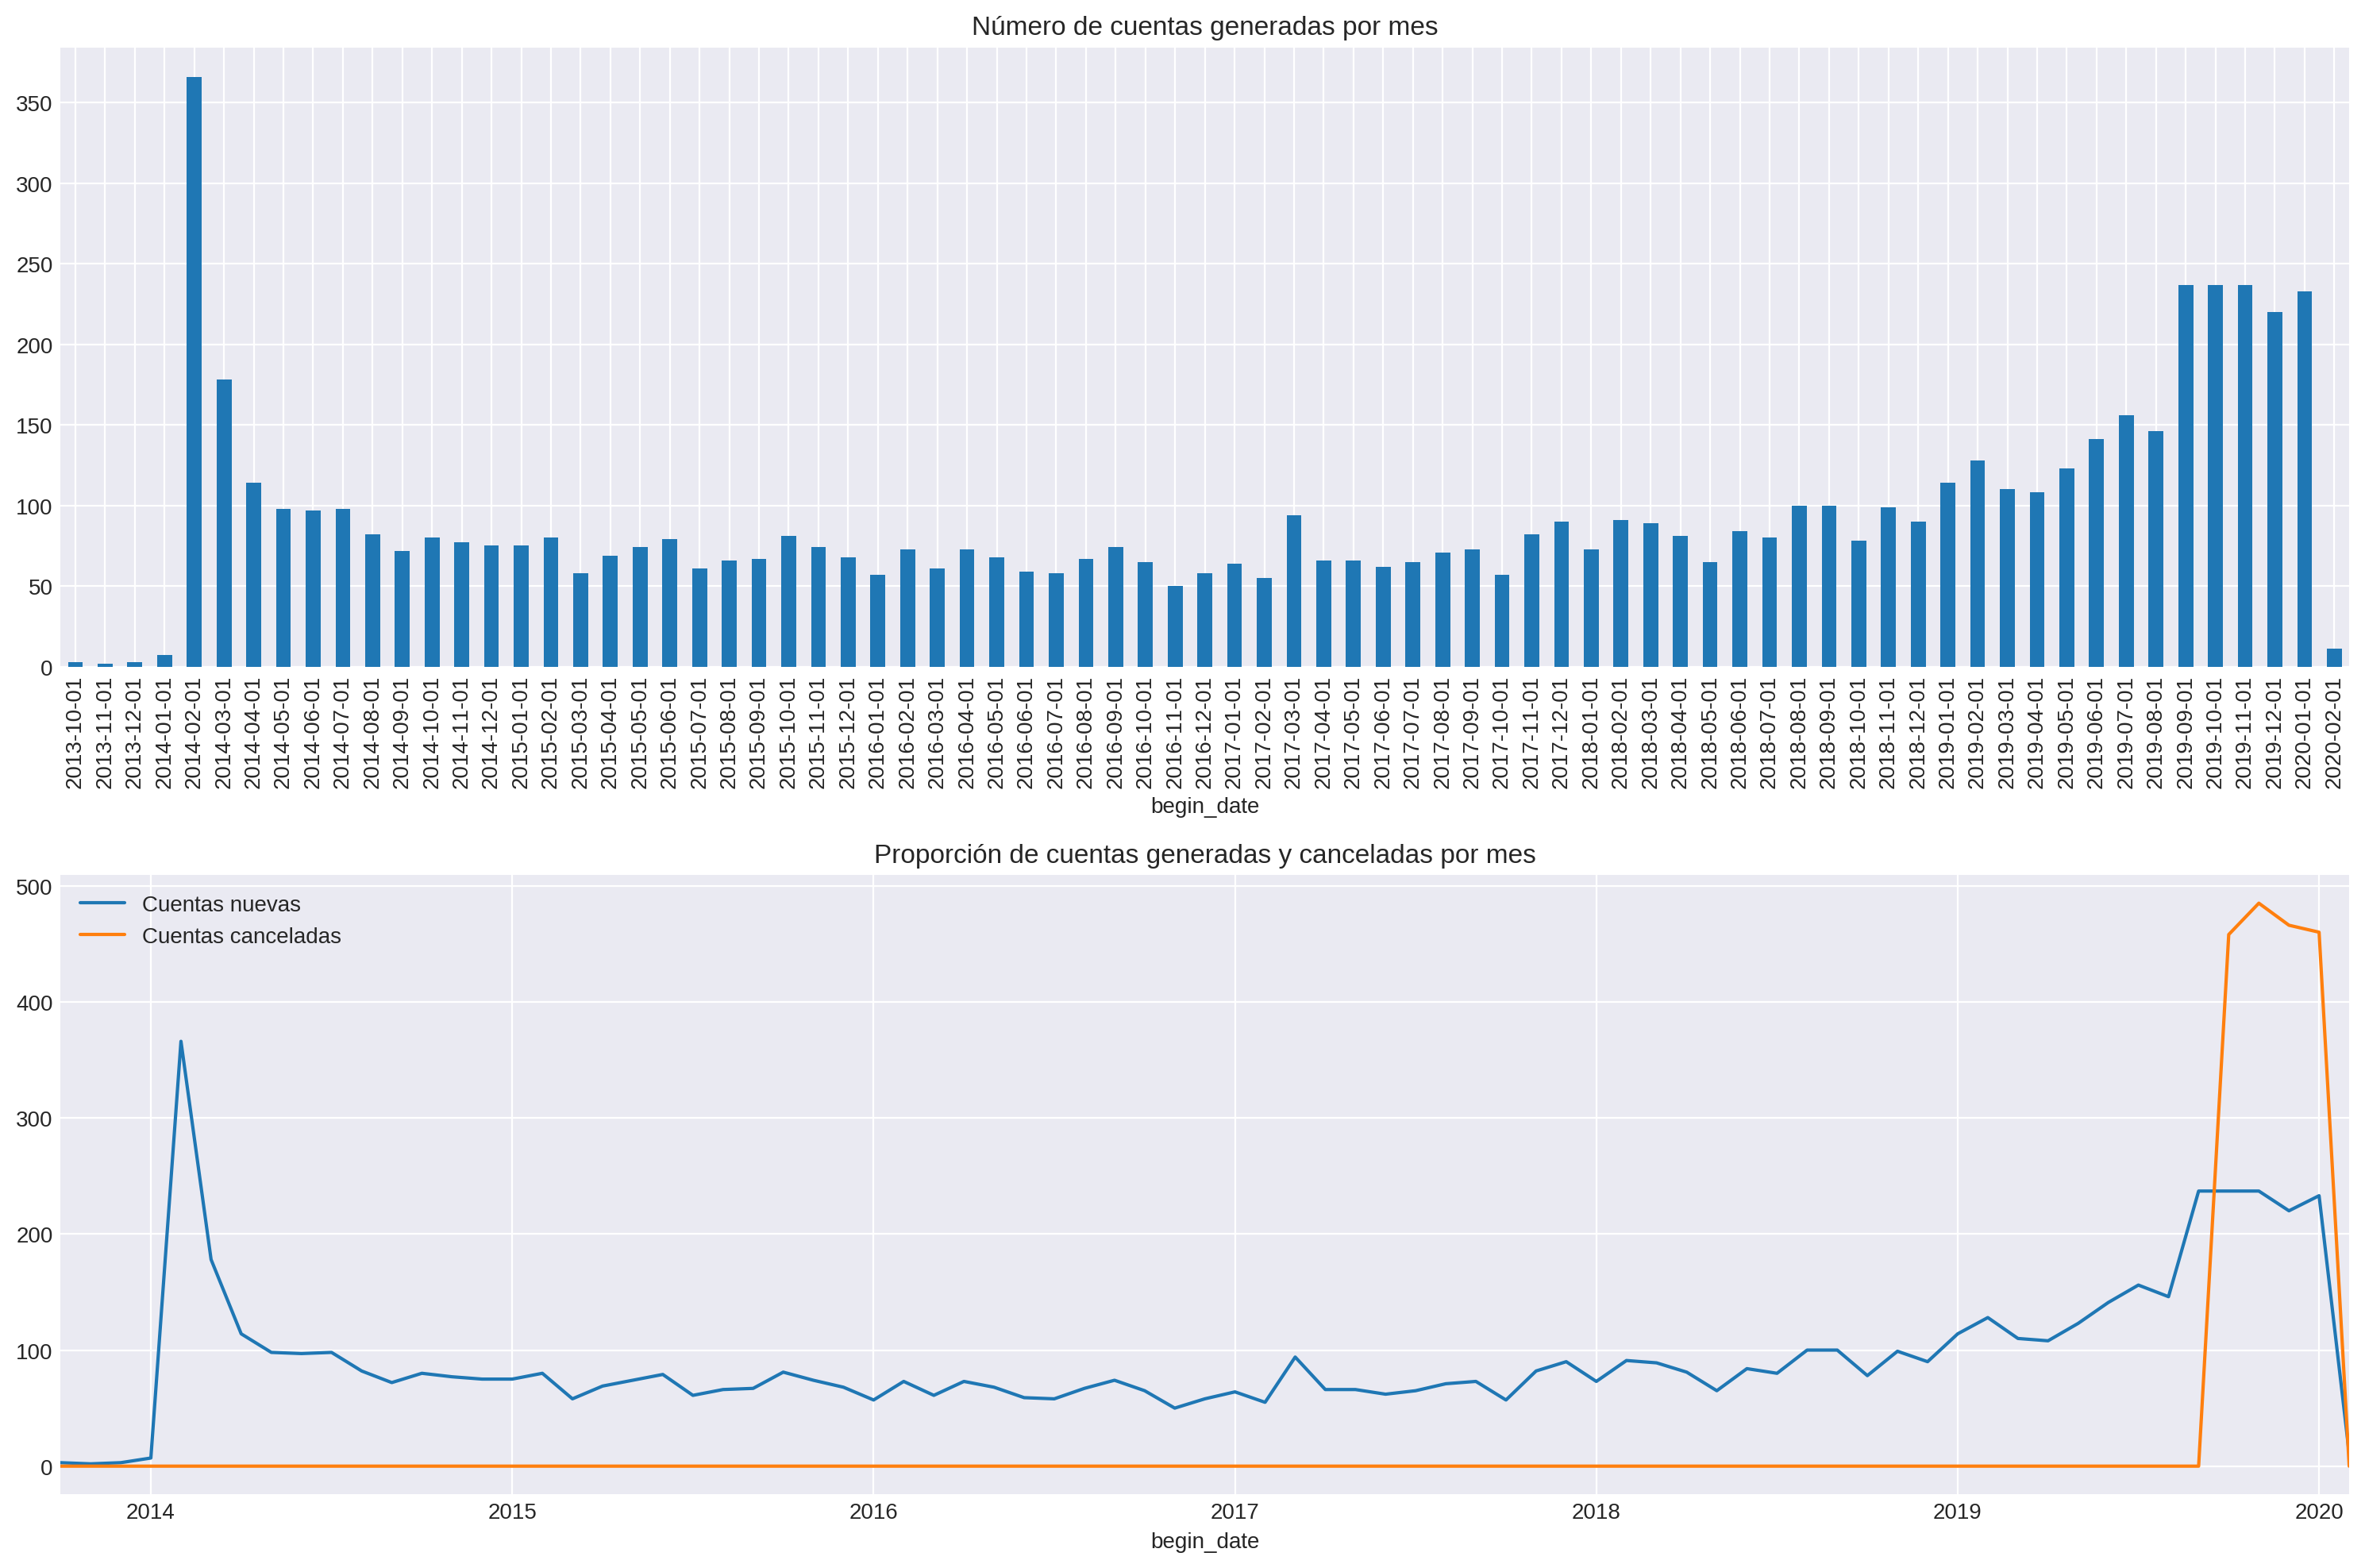

In [80]:
# Definimos la fecha actual
fecha_actual = datetime.now().date()

# Convertir 'end_date' a tipo datetime si no lo está
df['end_date'] = pd.to_datetime(df['end_date']).dt.date

# Asegúrate de que la columna 'end_date' indica la cancelación de cuentas
# La cuenta está cancelada si 'end_date' es diferente a la fecha actual
df['exited'] = (df['end_date'] != fecha_actual).astype(int)

# Verificar los valores únicos en la columna 'exited' y su cuenta
print(df['exited'].value_counts())

# Definimos el número de subplots y tamaño de la figura
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Trazamos un gráfico de barras en el eje 1
ax = axs[0]
begin_date_grouped = df.groupby('begin_date')['customer_id'].count()
begin_date_grouped.plot(kind='bar', ax=ax, title='Número de cuentas generadas por mes')
ax.set_xticklabels([x.strftime("%Y-%m-%d") for x in begin_date_grouped.index], rotation=90)

# Trazamos un gráfico de líneas en el eje 2
ax = axs[1]
# Obtenemos la distribución de cuentas canceladas por mes
filtered = df.query('exited == 1').groupby('end_date')['exited'].count()
filtered = filtered.reindex(index=begin_date_grouped.index).fillna(0)

begin_date_grouped.plot(ax=ax)
filtered.plot(ax=ax, title='Proporción de cuentas generadas y canceladas por mes')
plt.legend(['Cuentas nuevas', 'Cuentas canceladas'])

fig.tight_layout()
plt.show()

El mayor número de cuentas se registran durante el mes de febrero de 2014, con más de 350 cuentas nuevas generadas en este período. A partir de marzo de 2014, disminuye el número de clientes mensuales a aproximadamente 170, y desde mayo del mismo año, se empieza a distinguir un menor número de registros nuevos. ES así que puede observarse un patrón de menos de 100 clientes nuevos mensuales, comportamiento que inicia en mayo 2014 y se mantiene hasta inicios del año 2019. Durante el año 2019, se evidencia un incremento en la generación de cuentas nuevas, alcanzando los picos más altos, de cerca de 250 nuevas cuentas por mes, durante los meses de octubre, noviembre y diciembre, este incremento se mantiene al principio del año 2020.

Si bien hay un incremento en el número de registros a finales del año 2019, en estos meses se evidencia por primera vez un incremento marcado de la tasa de cancelación de cuentas, llegando a cerca de 500 cancelaciones en el mes de noviembre de 2019. Hay que recalcar que la empresa no presentó clientes que abandonen sus cuentas durante un período de cinco años, por lo que será necesario analizar que factor fue el determinante para que los usuarios cambien sus preferencias y decidan cancelar los servicios contratados.

### Análisis Univariado por Servicio

Al analizar la proporción de cuentas generadas y canceladas por mes, observamos que durante los últimos meses del año 2019 se registra la tasa más alta de cancelación. Considerando esto, vamos a realizar un análisis de la distribución de cada variable o característica en función del abandono o no de servicios.

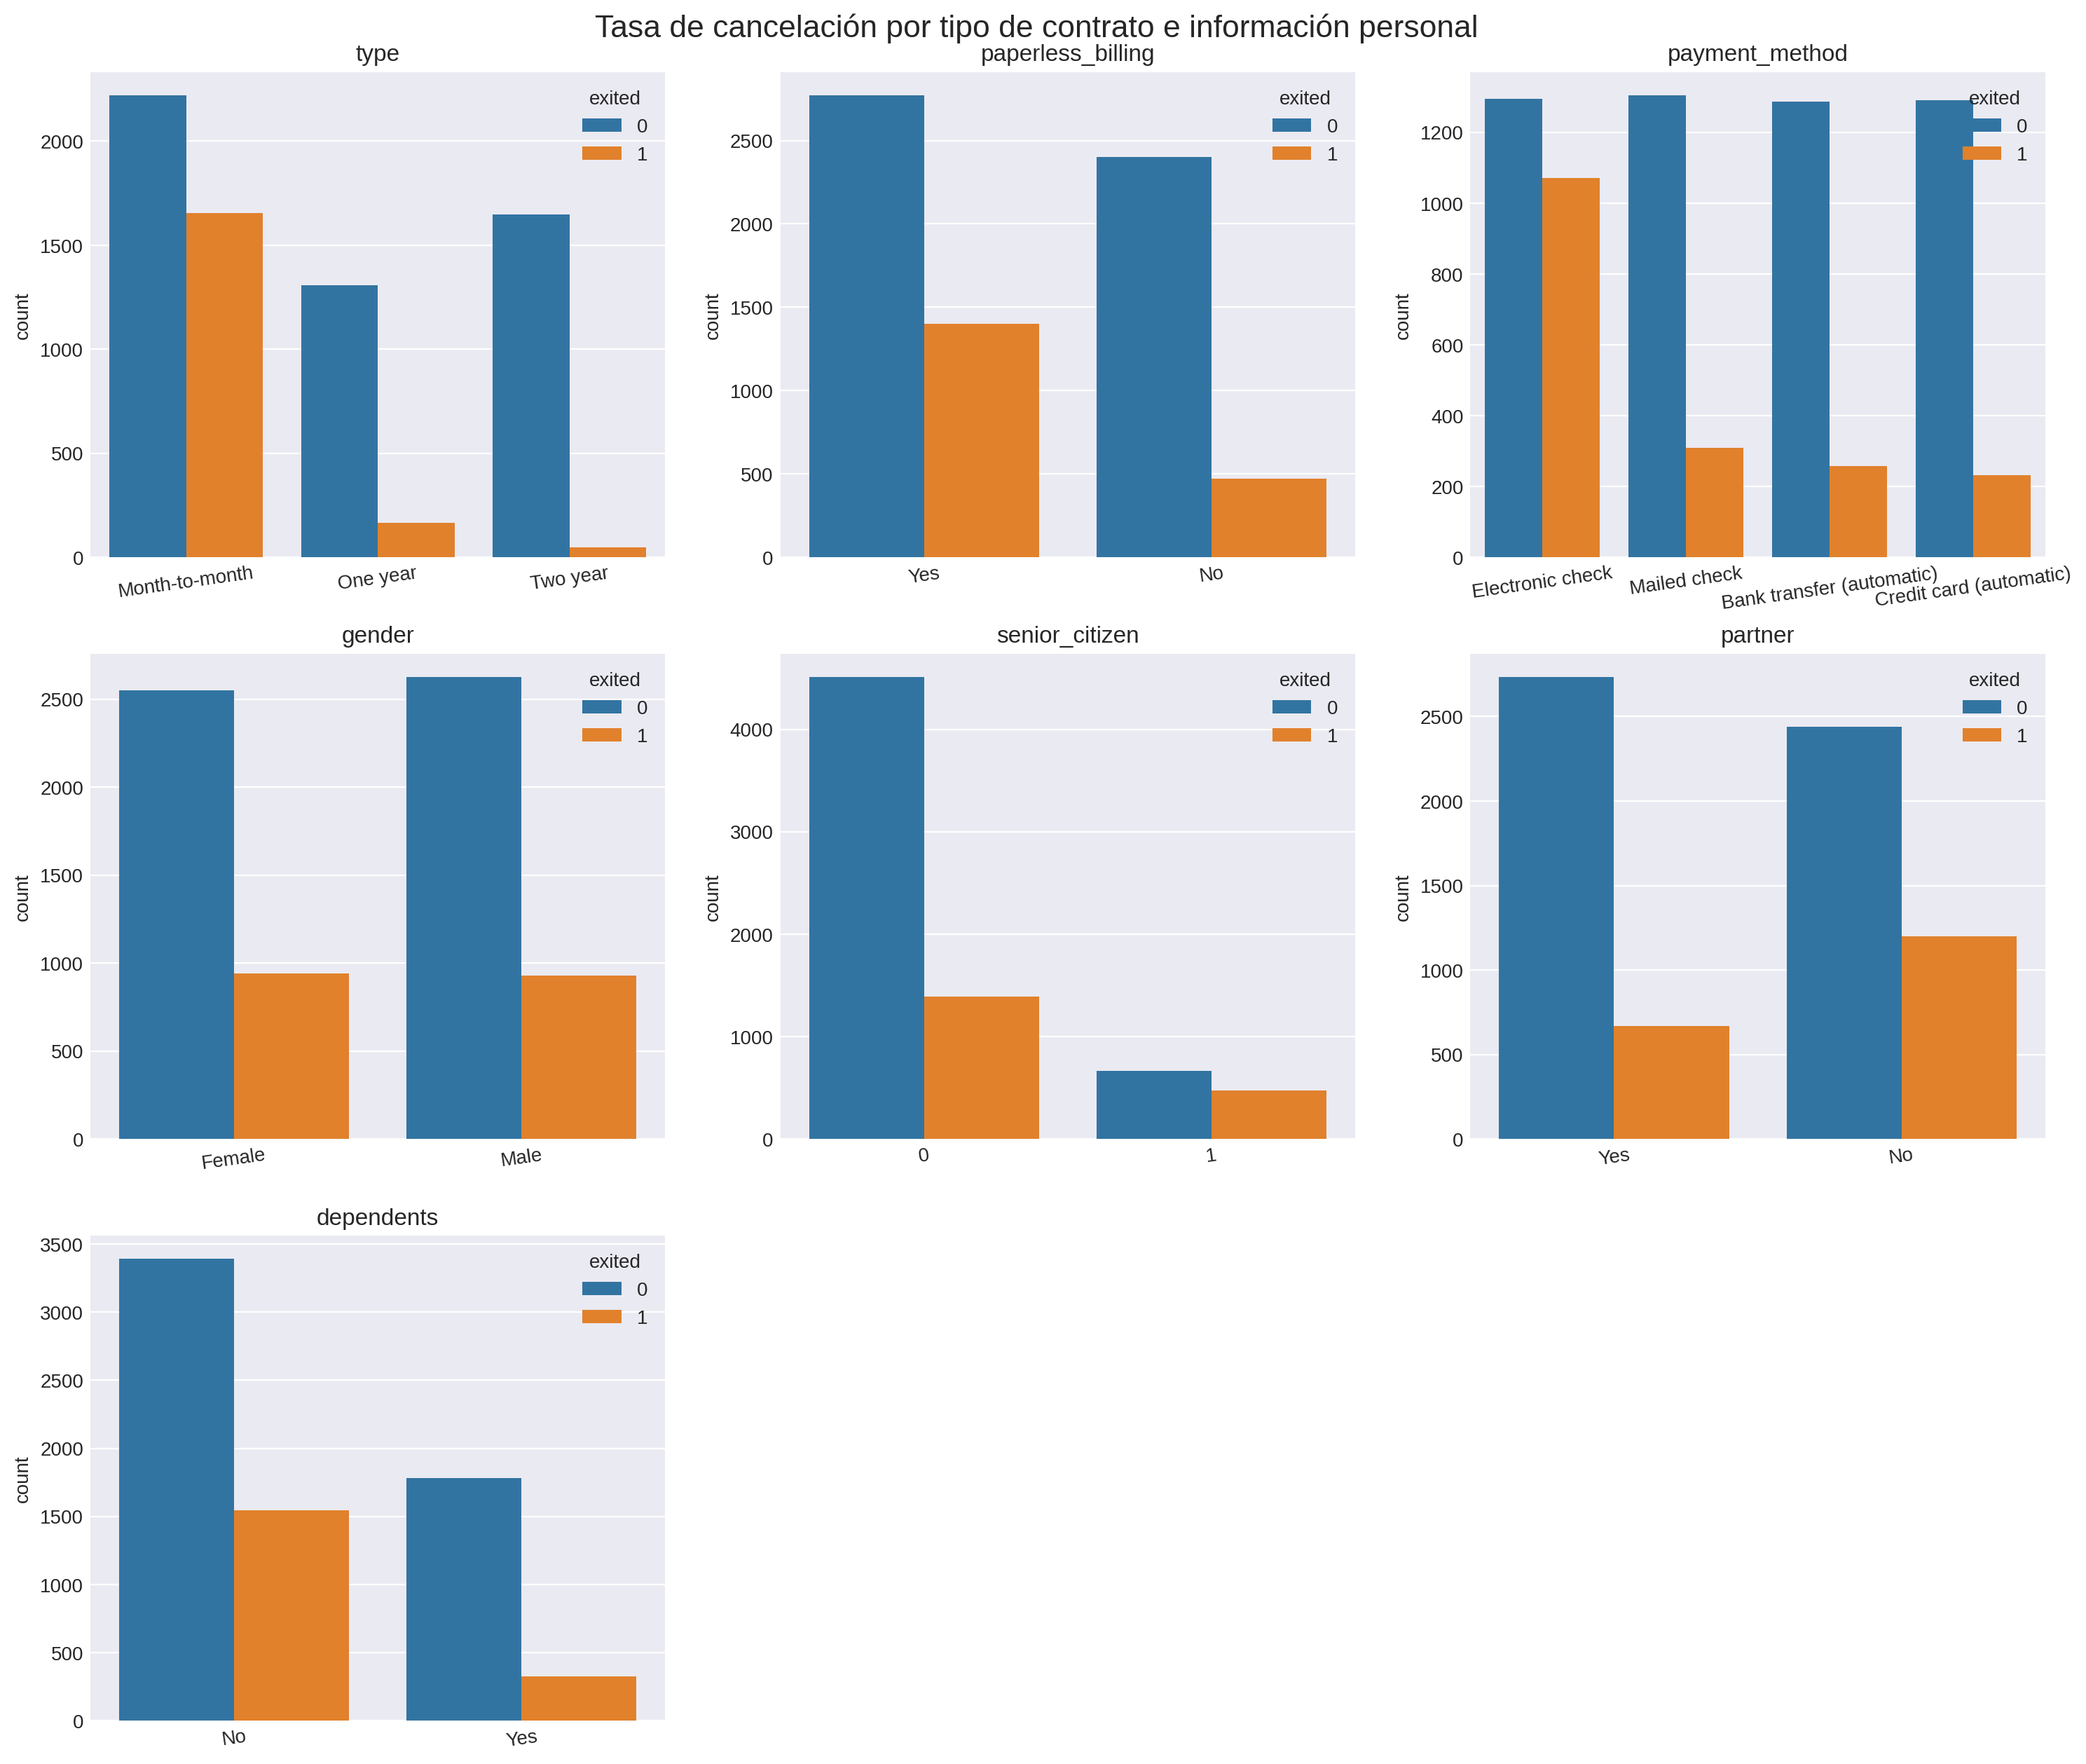

In [81]:
# Trazamos gráficos de barras por contrato e información personal
fig = plt.figure(figsize=(18, 14))

for n, col in enumerate(['type', 'paperless_billing', 'payment_method', 'gender', 
                         'senior_citizen', 'partner', 'dependents']):
    ax = plt.subplot(3, 3, n + 1)
    ax.set_ylabel('Proporción clientes')
    sns.countplot(x=df[col], hue=df['exited'], ax=ax)
    plt.title(col)
    plt.xticks(rotation=8)
    plt.xlabel('')

fig.suptitle('Tasa de cancelación por tipo de contrato e información personal', fontsize=16)
fig.subplots_adjust(top=0.95)
plt.show()

Se evidencia una mayor proporción de clientes que conservan sus cuentas, sin embargo se observan ciertos patrones en cada variable:

* `type`: hay una mayor proporción de clientes con pagos mensuales que abandonan sus cuentas, y aquellos que mantienen sus cuentas optan por pagos mensuales o de dos años.
* `paperless_billing`: aquellos con facturación sin papel tienen una mayor tendencia a abandonar sus contratos, pero este patrón se repite en clientes que no han cancelado sus cuentas.
* `payment_method`: aquellos clientes que optaron por facturación electrónica son los que abandonan en mayor proporción sus cuentas frente a cualquier otro método de pago.
* `gender`: no se observa una diferencia marcada entre hombres y mujeres que abandonaron sus cuentas, es decir que ambos sexos tienen la misma probabilidad de terminar los servicios contratados.
* `senior_citizen`: se observa una menor proporción de clientes jubilados, siendo más probable que clientes no jubilados cancelen sus cuentas.
* `partner`: en clientes que no han cancelado sus cuentas hay una mayor proporción con pareja, mientras que del grupo que canceló sus cuentas la mayoría no tiene pareja.
* `dependents`: hay una mayor proporción de clientes sin dependientes que abandonan sus cuentas.

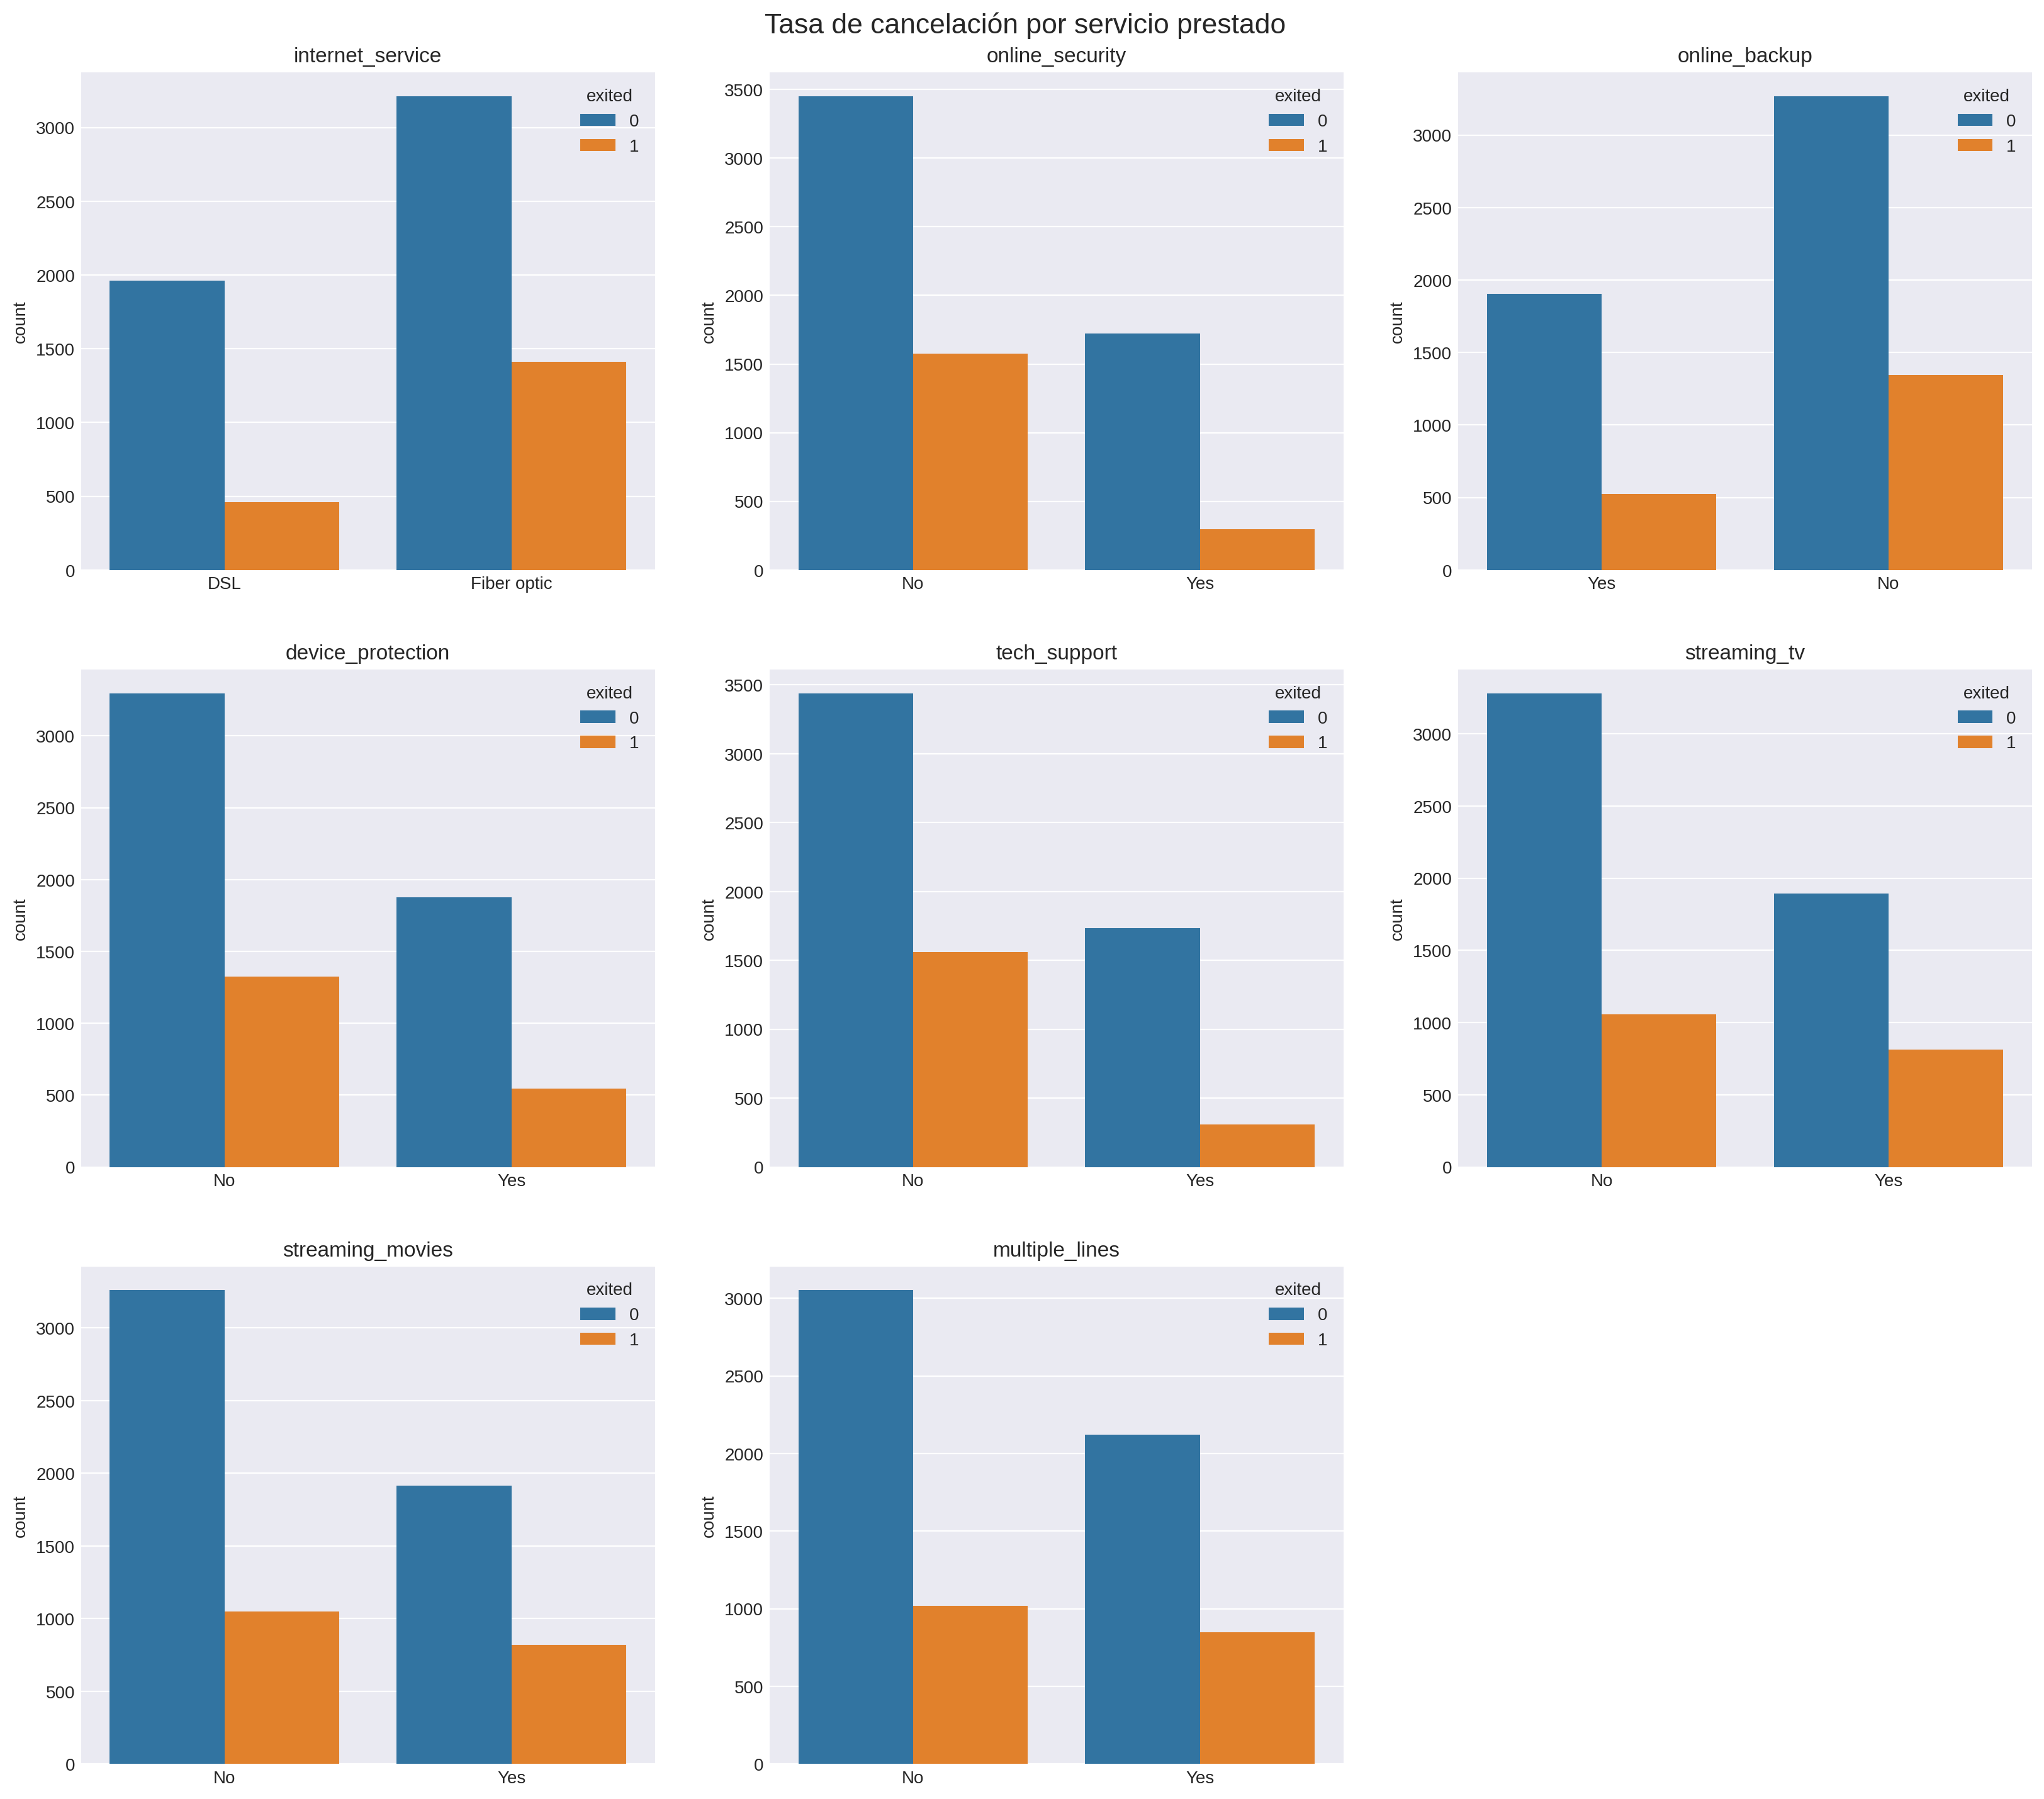

In [82]:
# Trazamos gráficos de barras por tipo de servicio
fig = plt.figure(figsize=(20, 16))

for n, col in enumerate(['internet_service', 'online_security', 'online_backup', 'device_protection', 
                         'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']):
    ax = plt.subplot(3, 3, n + 1)
    ax.set_ylabel('Proporción clientes')
    sns.countplot(x=df[col], hue=df['exited'], ax=ax)
    plt.title(col)
    plt.xlabel('')

fig.suptitle('Tasa de cancelación por servicio prestado', fontsize=16)
fig.subplots_adjust(top=0.95)

En relación al tipo de servicio prestado podemos establecer:

* `internet_service`: aquellos usuarios que optan por el servicio de fibra óptica tienden a cancelar sus cuentas en mayor proporción que aquellos que contratan DSL.
* Los clientes que no contratan los servicios de `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv` y `streaming_movies` tienen una mayor probabilidad de cancelar sus cuentas, frente a los que sí contraron estos servicios, los cuales es menos probable que abandonen o cancelen sus contratos. Los servicios que registran una mayor proporción de usuarios, por encima de los 1750, son: `online_backup`, `device_protection`, `streaming_tv` y `streaming_movies`.
* En cuanto al servicio de varias líneas de telefonía fija `multiple_lines`, se registra un número casi similar de clientes que abandonan sus cuentas, independientemente de si contratan o no múltiples líneas.

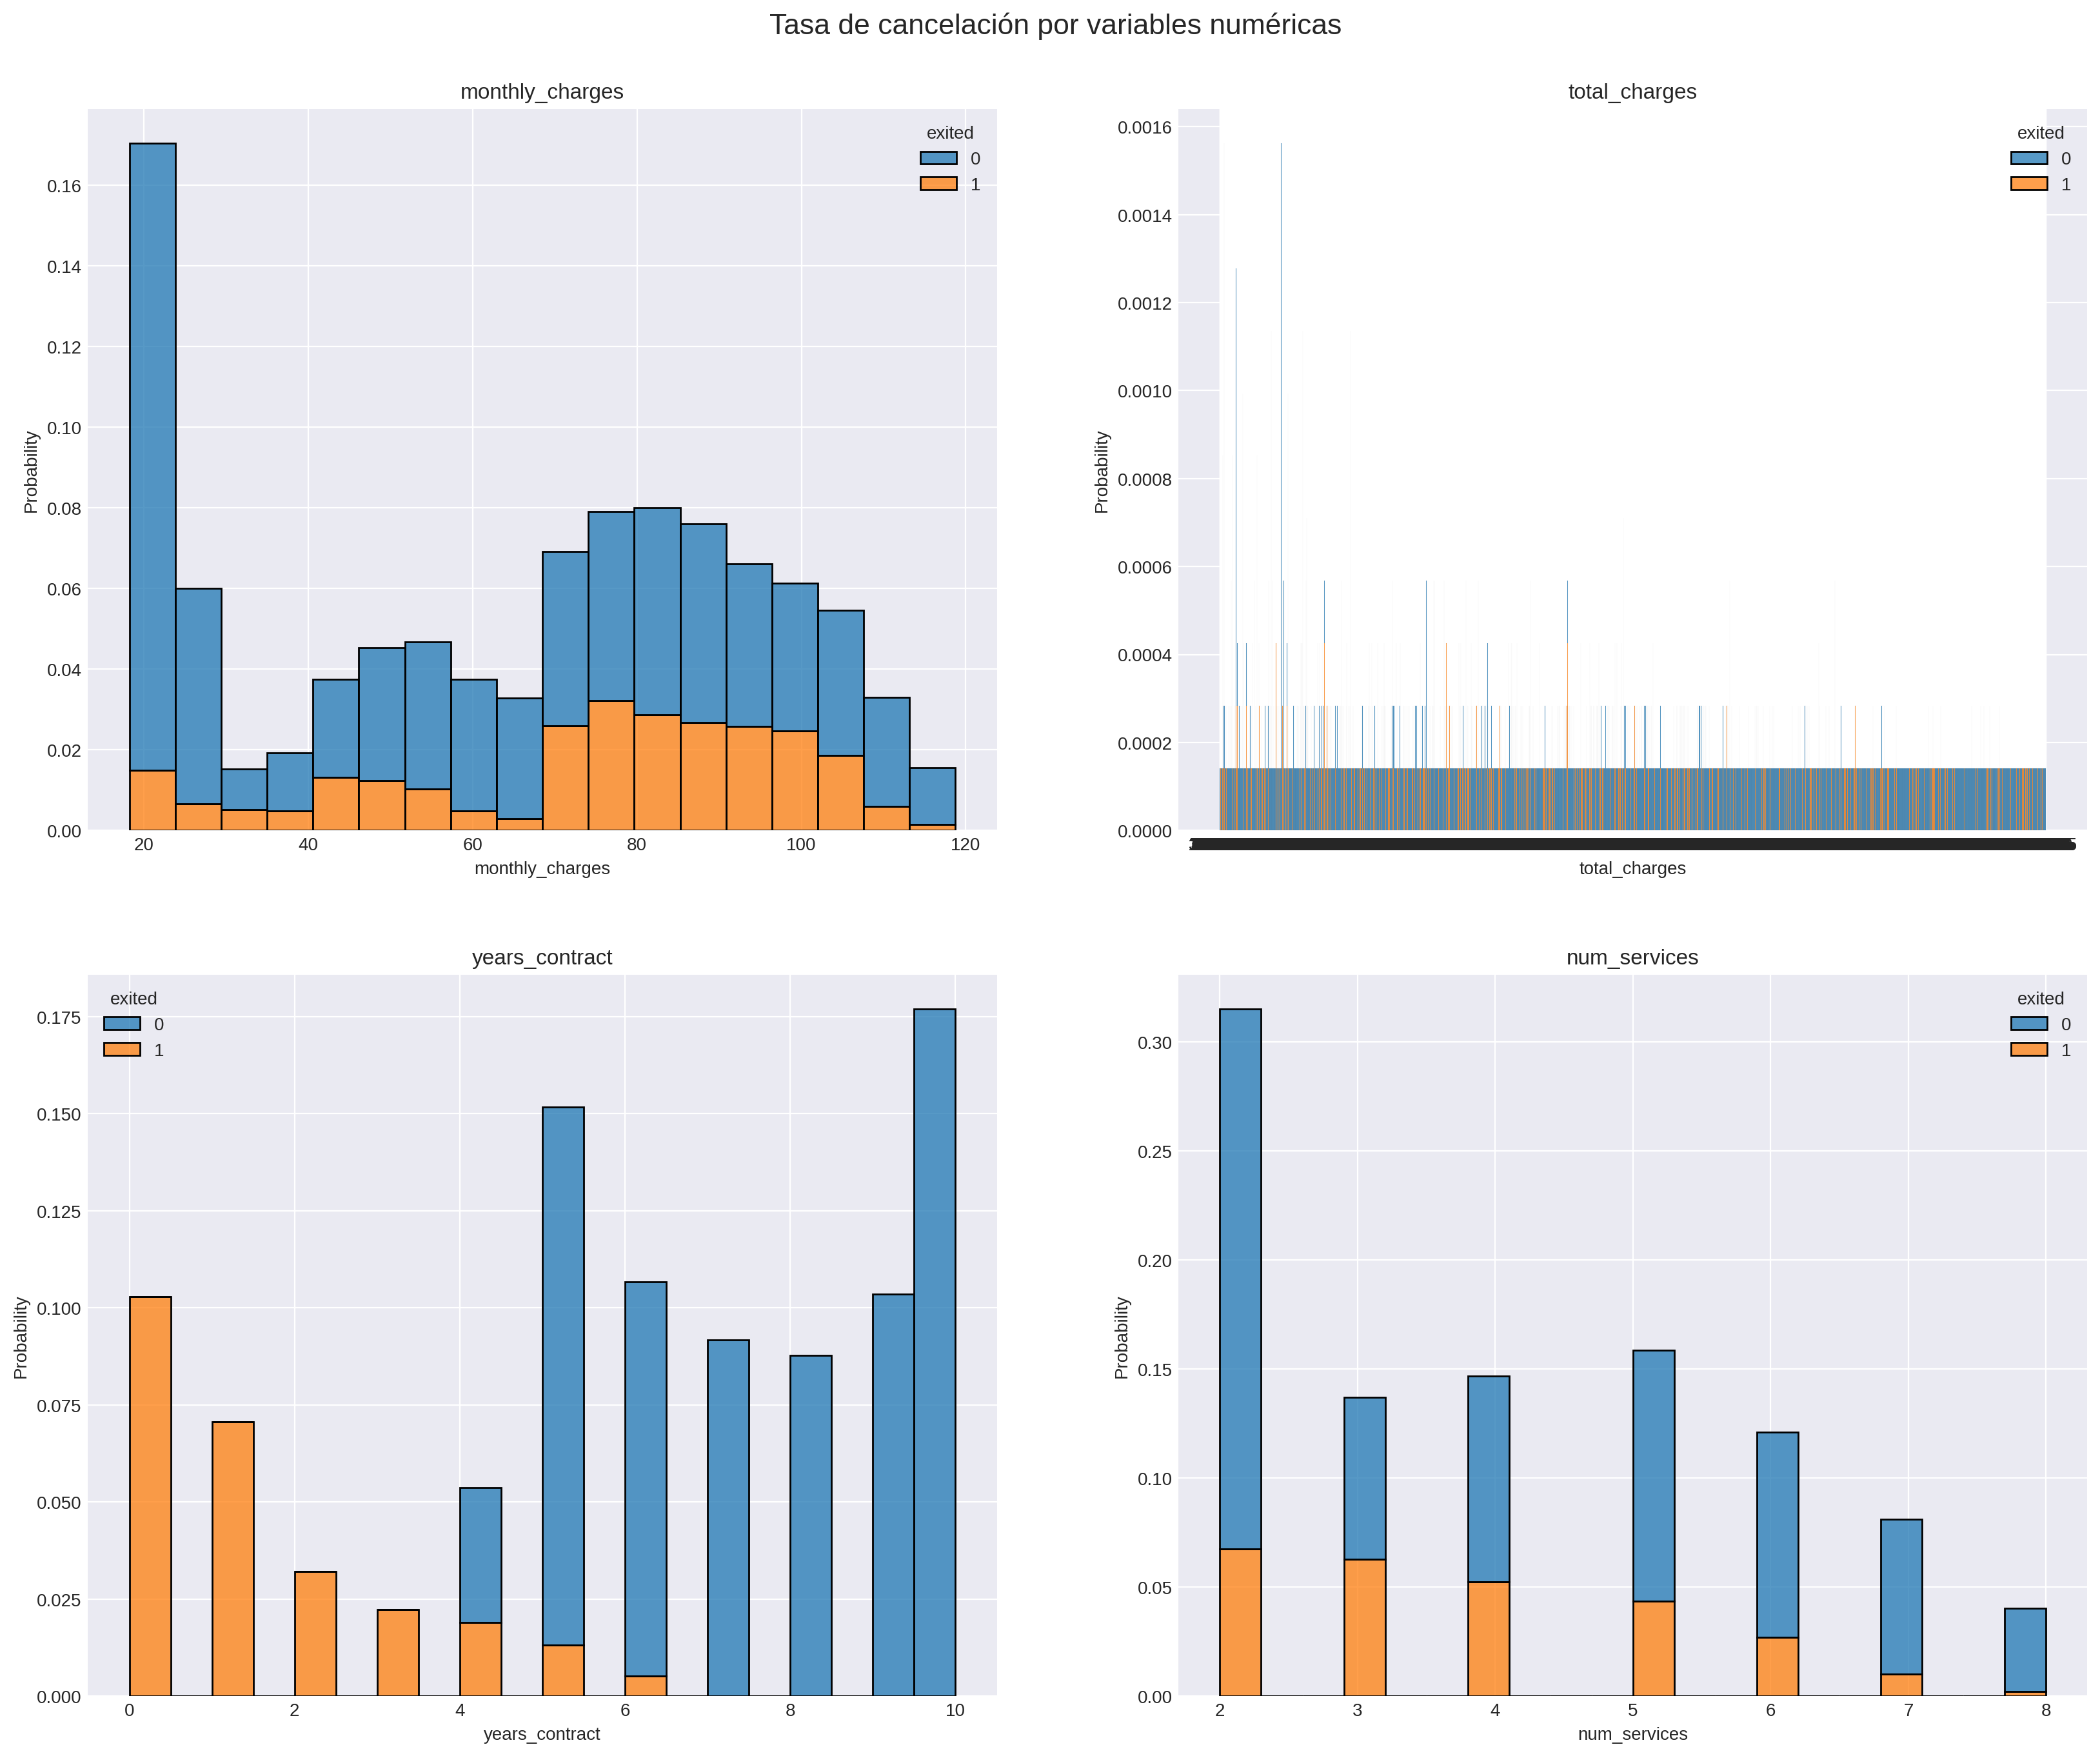

In [83]:
# Trazamos histogramas para las variables numéricas
fig = plt.figure(figsize=(20, 15))

for n, col in enumerate(['monthly_charges', 'total_charges', 'years_contract', 'num_services']):
    ax = plt.subplot(2, 2, n + 1)
    sns.histplot(df, x=col, hue='exited', stat='probability', multiple='stack')
    plt.title(col)

fig.suptitle('Tasa de cancelación por variables numéricas', fontsize=16)
fig.subplots_adjust(top=0.93)

En cuanto a la distribución de variables numéricas en función de la probabilidad de cancelación, podemos establecer los siguiente:

* `monthly_charges`: el número de clientes que cancelan sus cuentas incrementan con el aumento del cargo mensual por servicios. La mayoría de usuarios que mantienen sus cuentas presentan una mayor proporción de clientes con cargas mensuales bajas.
* `years`: se observa un patrón similar en ambos grupos, a mayor el valor de cargos totales, menor es el número de clientes que cancelan sus cuentas.
* `years_contract`: cuentas de clientes recientes con pocos meses o hasta un año de permanencia presentan una mayor probabilidad de cancelación, frente a aquellos clientes que han utilizado los servicios durante más de dos años o hasta seis.
* `num_services`: a mayor número de servicios contratados, menor es la probabilidad que un cliente cancele su contrato. Aquellos usuarios que contratan entre 2 a 5 servicios, presentan las tasas de cancelación más altas.

Podemos establecer en base a la información personal, de contrato y servicios que es más probable que un cliente abandone sus cuenta si presenta:

* plan de pago mensual
* facturación sin papel
* pago electrónico
* no jubilado
* sin pareja
* sin dependientes
* internet de fibra óptica
* sin contrato de otros servicios varios o pocos servicios contratados
* servicio de telefonía fija
* altos cargos mensuales y bajos totales
* cuenta reciente de menos de un año

Hay que señalar que el tipo de pago, carga mensual, método de pago y el tipo de servicio de internet son las variables que registraron la mayor tasa de cancelación frente a otras. Por otro lado, la implementación de facturación electrónica pudo haberse dado a finales del año 2019, siendo esta una de las causas que llevó a un incremento del número de cancelaciones mensuales a finales de este período. Quizás se registraron problemas en la plataforma de pago que llevó a que los usuarios busquen otras opciones en el mercado.

Aquellos clientes que conservan una cuenta por un período más amplio de tiempo y contratan más servicios tienen menores probabilidades de abandonar sus cuentas, en comparación a clientes recientes con pocos servicios contratados.

### Analisis Correlacion

Ahora realizaremos un análisis bivariado a través de un análisis de correlación de Pearson entre variables numéricas, un análisis `chi-cuadrado` para determinar la correlación entre la variable objetivo `exited` y las variables categóricas, y finalmente una correlación `pointbiserial` para determinar si existe algún tipo de relación entre la variable objetivo y las variables continuas de nuestro dataset.

In [84]:
# Empezamos determinando las características categóricas y numéricas de nuestro dataset 

cat_features = ['type', 
                'paperless_billing', 
                'payment_method', 
                'internet_service', 
                'online_security', 
                'online_backup', 
                'device_protection', 
                'tech_support', 
                'streaming_tv',
                'streaming_movies', 
                'gender', 
                'senior_citizen', 
                'partner', 
                'dependents', 
                'multiple_lines']

num_features = ['monthly_charges', 
                'total_charges', 
                'years_contract', 
                'num_services']

**Correlación características numéricas**

In [85]:
# Realizamos un análisis de correlación de Pearson entre características numéricas
df.corr().style.background_gradient(cmap='viridis')

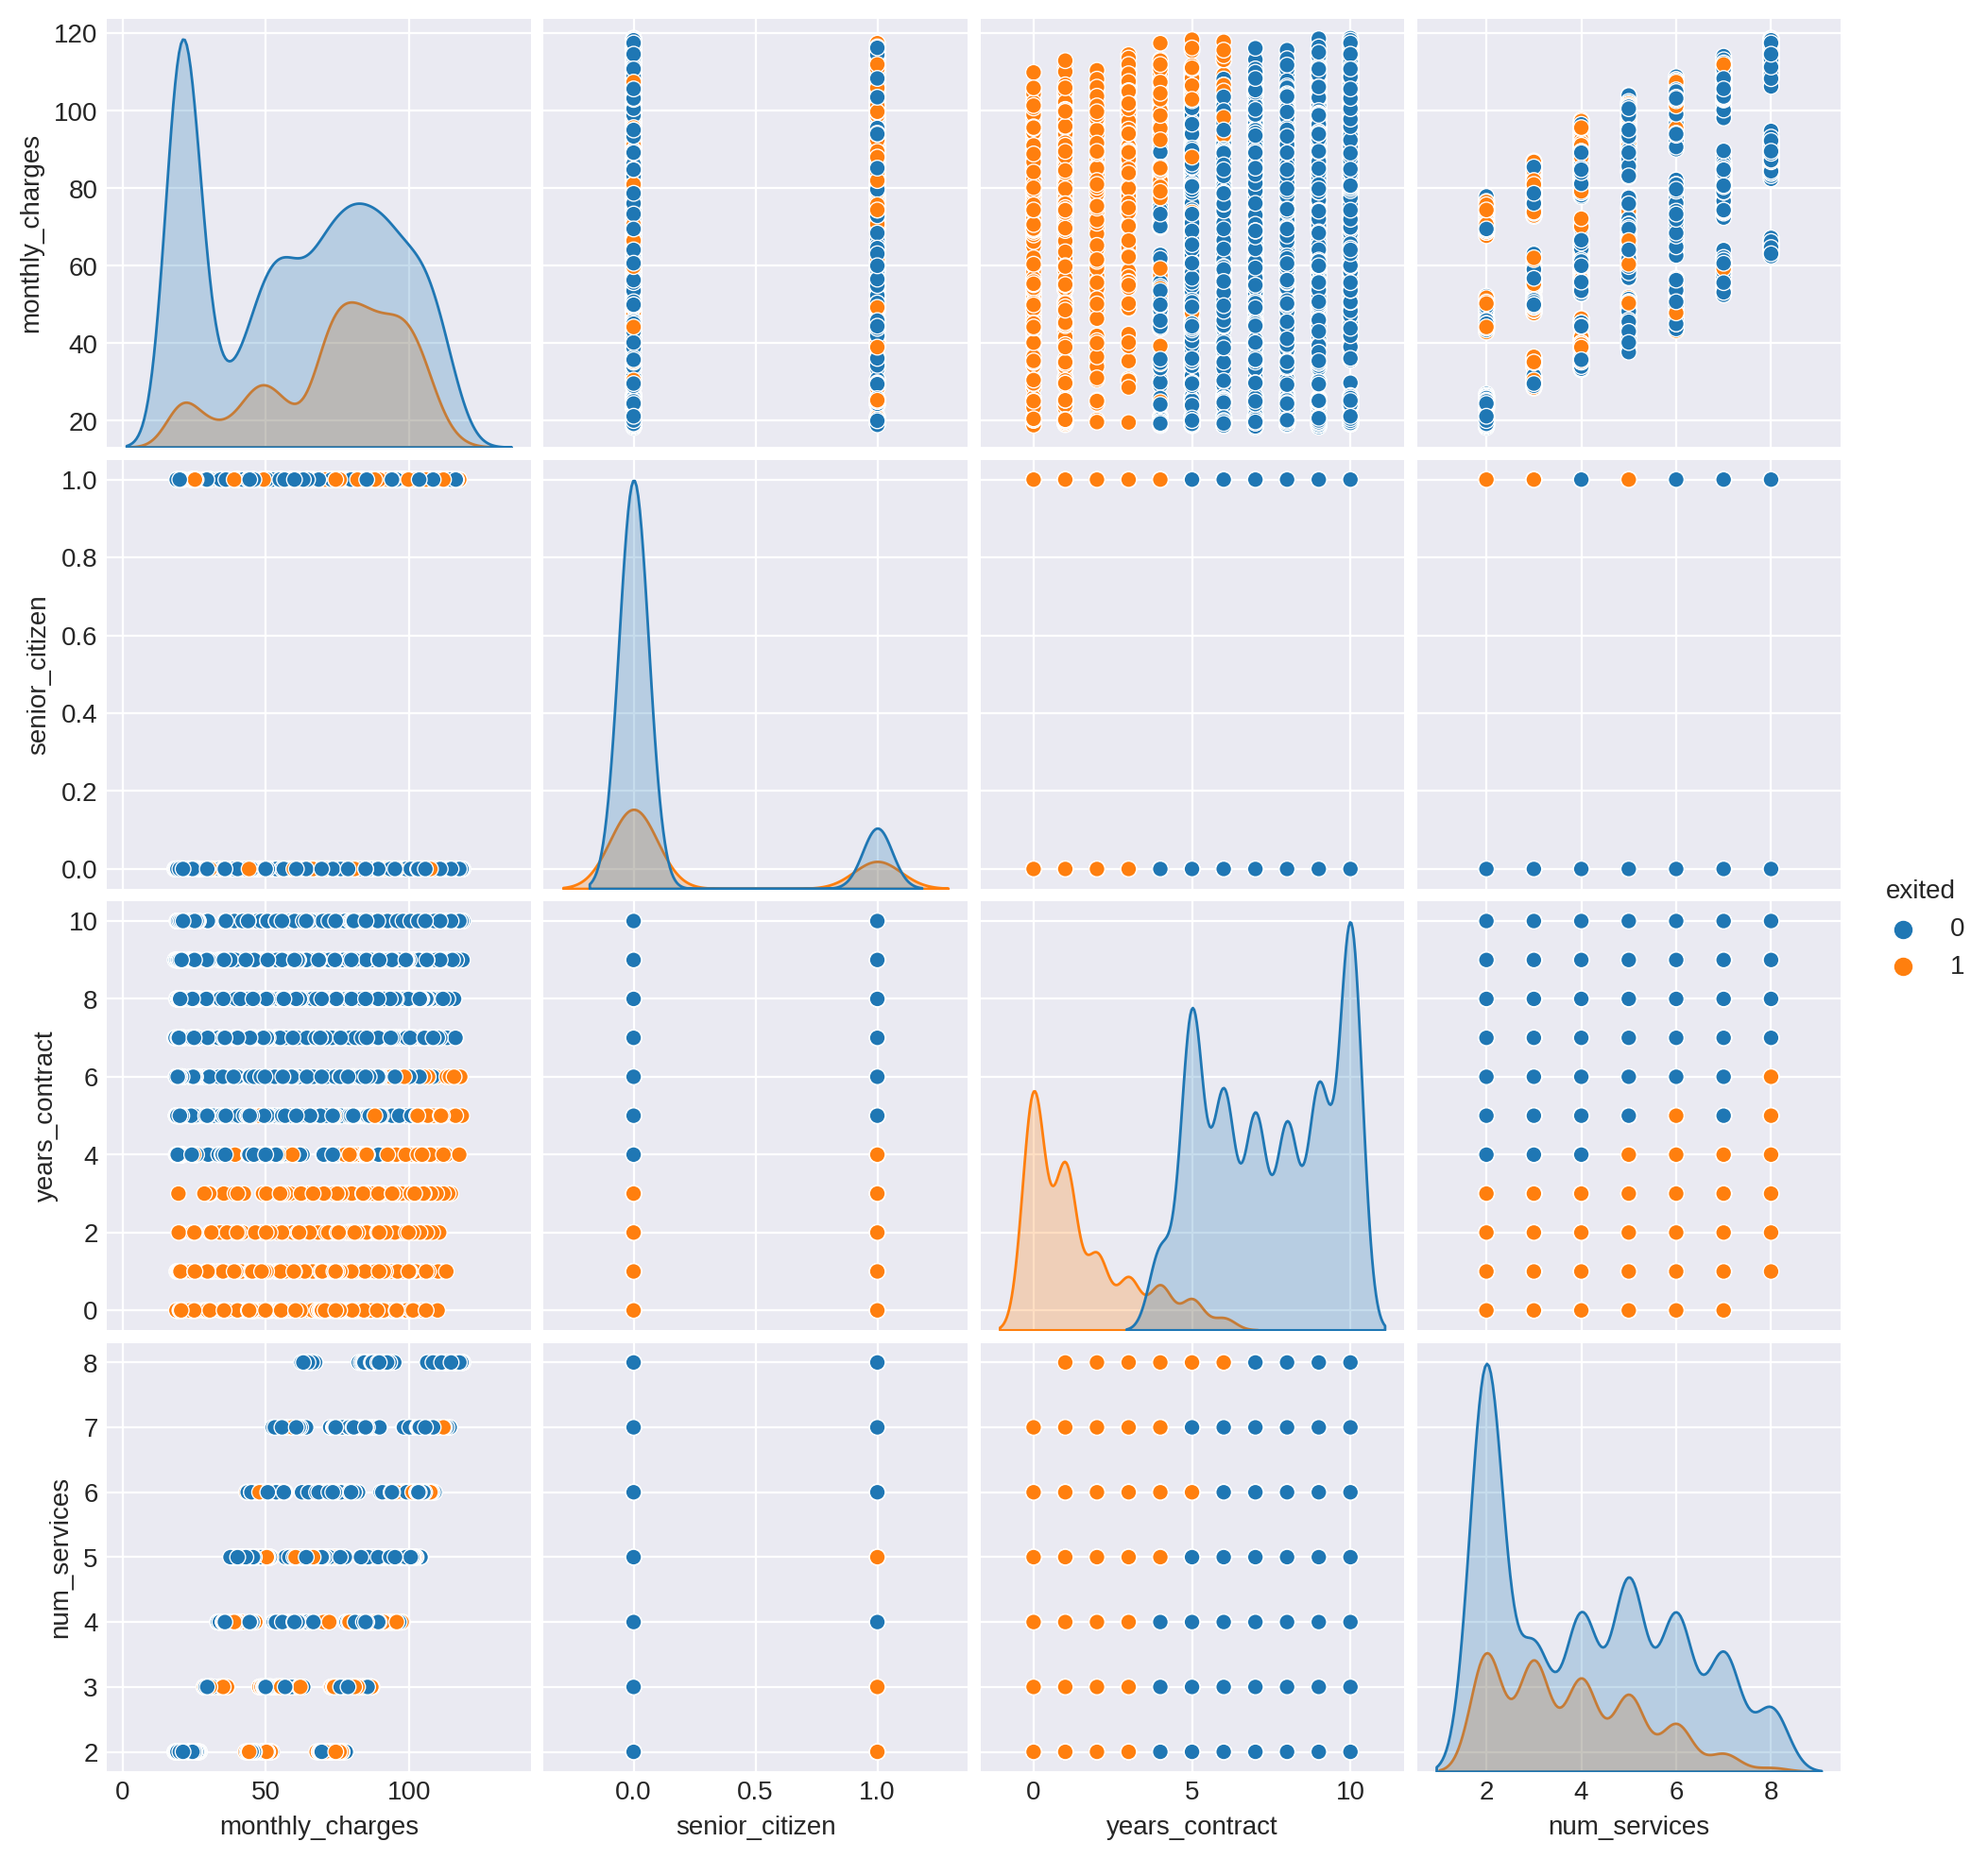

In [86]:
# Trazamos un gráfico de correlación de variables numérias en función de la probabilidad de salida de un cliente
sns.pairplot(df, hue='exited')
plt.show()

Al analizar los resultados de un análisis de correlación de Pearson, podemos observar que la variable objetivo `exited` presenta una correlación negativa alta, de -0.43, con los años de duración del contrato, es decir a menos años de uso de servicios es más probable que un cliente abandone su cuenta, esto lo pudimos verificar anteriormente a través de histogramas de frecuencias. A su vez se registra una correlación negativa leve entre `exited` y `total_charges`, siendo más probable que se produzca la cancelación de un contrato si el usuario registra bajos cargos totales.

Por otro lado, se observa una correlación positiva leve entre `exited` y las características `monthly_charges` y `senior_citizen`, es decir clientes con cargos mensuales altos y jubilados tienden a cancelar más sus cuentas que usuarios no jubilados con cargos mensuales bajos. Por último, la correlación entre `num_services` y `exited` es cercana a cero, por lo que no podemos afirmar una correlación lineal entre ambas variables.

En el caso de nuestro gráfico pairplot, se confirma ciertos patrones obtenidos a través de un análisis de correlación de Pearson, es así que a más cargos mensuales, incrementan los cargos totales. Pudiendo determinarse que aquellos clientes con cargos totales bajos pero mensuales altos son los que más abandonan sus cuentas. También se registra una correlación positiva alta entre los años de contrato con los cargos totales, existiendo una mayor probabilidad de cancelación para usuarios de cuentas recientes con pocos cargos totales, de igual manera esta patrón se repite para el cargo mensual.

En el caso del número de servicios, a pesar de que no se registró una correlación alta con la tasa de cancelación, si presenta una correlación positiva fuerte con los cargos totales y mensuales, pero no se puede determinar un patrón específico de salida de clientes. A su vez, el número de servicios presenta una correlación moderada con los años de contrato, a mayor duración del contrato, incrementa el número de servicios contratados, siendo más probable que clientes recientes y con pocos servicios abandonen sus cuentas.

**Correlación características categóricas**

Para poder establecer si existe una correlación entre la variable objetivo y las caracerísticas categóricas vamos a realizar un test `chi-cuadrado` de independencia de variables a partir de una tabla de contingencia. Primero trazamos una tabla de contingencia entre cada característica categórica y la variable objetivo, y luego aplicamos un test de `chi-cuadrado`, pudiendo determinarse que existe una relación entre las variables a través de una prueba de hipótesis, si el valor p es inferior a 0.05 las variables son dependientes y si el p valor es superior a 0.05, no existe una dependencia.

In [87]:
# Establecemos un bucle for que añade los valor p del test chi-cuadrado a la lista p-values y devuelve un dataframe
p_values = []

for col in cat_features:
    c, p, dof, expected = chi2_contingency(pd.crosstab(df['exited'], df[col]))
    p_values.append(p)
    
chi_table = pd.DataFrame(index=cat_features)
chi_table['p_values'] = p_values
chi_table

p_values
type               5.863038e-258
paperless_billing   4.073355e-58
payment_method     3.682355e-140
internet_service    2.587377e-25
online_security     1.232098e-46
online_backup       6.214093e-12
device_protection   3.315693e-08
tech_support        2.923567e-43
streaming_tv        1.302484e-07
streaming_movies    2.997474e-07
gender              4.865787e-01
senior_citizen      1.510067e-36
partner             2.139911e-36
dependents          4.924922e-43
multiple_lines      8.433795e-04

Se puede determinar que existe una dependencia fuerte entre las características categóricas y la variable objetivo `exited`, ya que los valores p son inferiores a 0.05 para todas las características, excepto para la característica `gender`, la cual presenta un p-value superior a 0.05. Por lo tanto, se puede concluir que no hay evidencia suficiente para afirmar que `gender` está asociado con la variable objetivo `exited`. Esto se corrobora con los gráficos de barras agrupados por la tasa de cancelación, donde no se observó una diferencia significativa en la tasa de abandono de servicios entre hombres y mujeres.

**Correlación características categóricas y numéricas**

Finalizaremos con un análisis de correlación pointbiserial para determinar si existe algún tipo de relación entre la variable objetivo y las variables continuas de nuestro dataset. Se obtendrá un valor de correlación entre -1 a 1, mientras más cercano a cero el valor, menor será la correlación entre variables. Corrobaremos estos resultados a través de una prueba de hipótesis obteniendo los valores p, si este valor es superior a 0.05 no hay un correlación y si es inferior a 0.05 si existe una correlación.

También añadiremos gráficos de cajas que nos permitan visualizar mejor al relación existente entre nuestra variable objetivo y las variables cuantitativas.

In [88]:
# Supongamos que df es tu DataFrame y num_features es la lista de características numéricas
num_features = ['monthly_charges', 'total_charges', 'years_contract', 'num_services']  # Ajusta según tus columnas

# Asegurarse de que todas las características numéricas sean de tipo numérico
for col in num_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convertir a numérico, NaN si no se puede convertir

# Llenar los NaN con la media de la columna (o cualquier otro método de imputación que prefieras)
df.fillna(df.mean(), inplace=True)

# Establecemos un bucle for que añade los valores p del test pointbiserialr a la lista p-values
# Añadimos los valores de correlación a la lista correlation
# Imprimimos los resultados a través de un dataframe 
correlation = []
p_value = []

for col in num_features:
    cor, p = pointbiserialr(df['exited'], df[col])
    correlation.append(cor)
    p_value.append(p)
    
result_table = pd.DataFrame(index=num_features)
result_table['correlation'] = correlation
result_table['p_values'] = p_value

# Mostrar los resultados
result_table

correlation      p_values
monthly_charges     0.193356  2.706646e-60
total_charges      -0.199428  4.233836e-64
years_contract     -0.815847  0.000000e+00
num_services       -0.087698  1.671374e-13

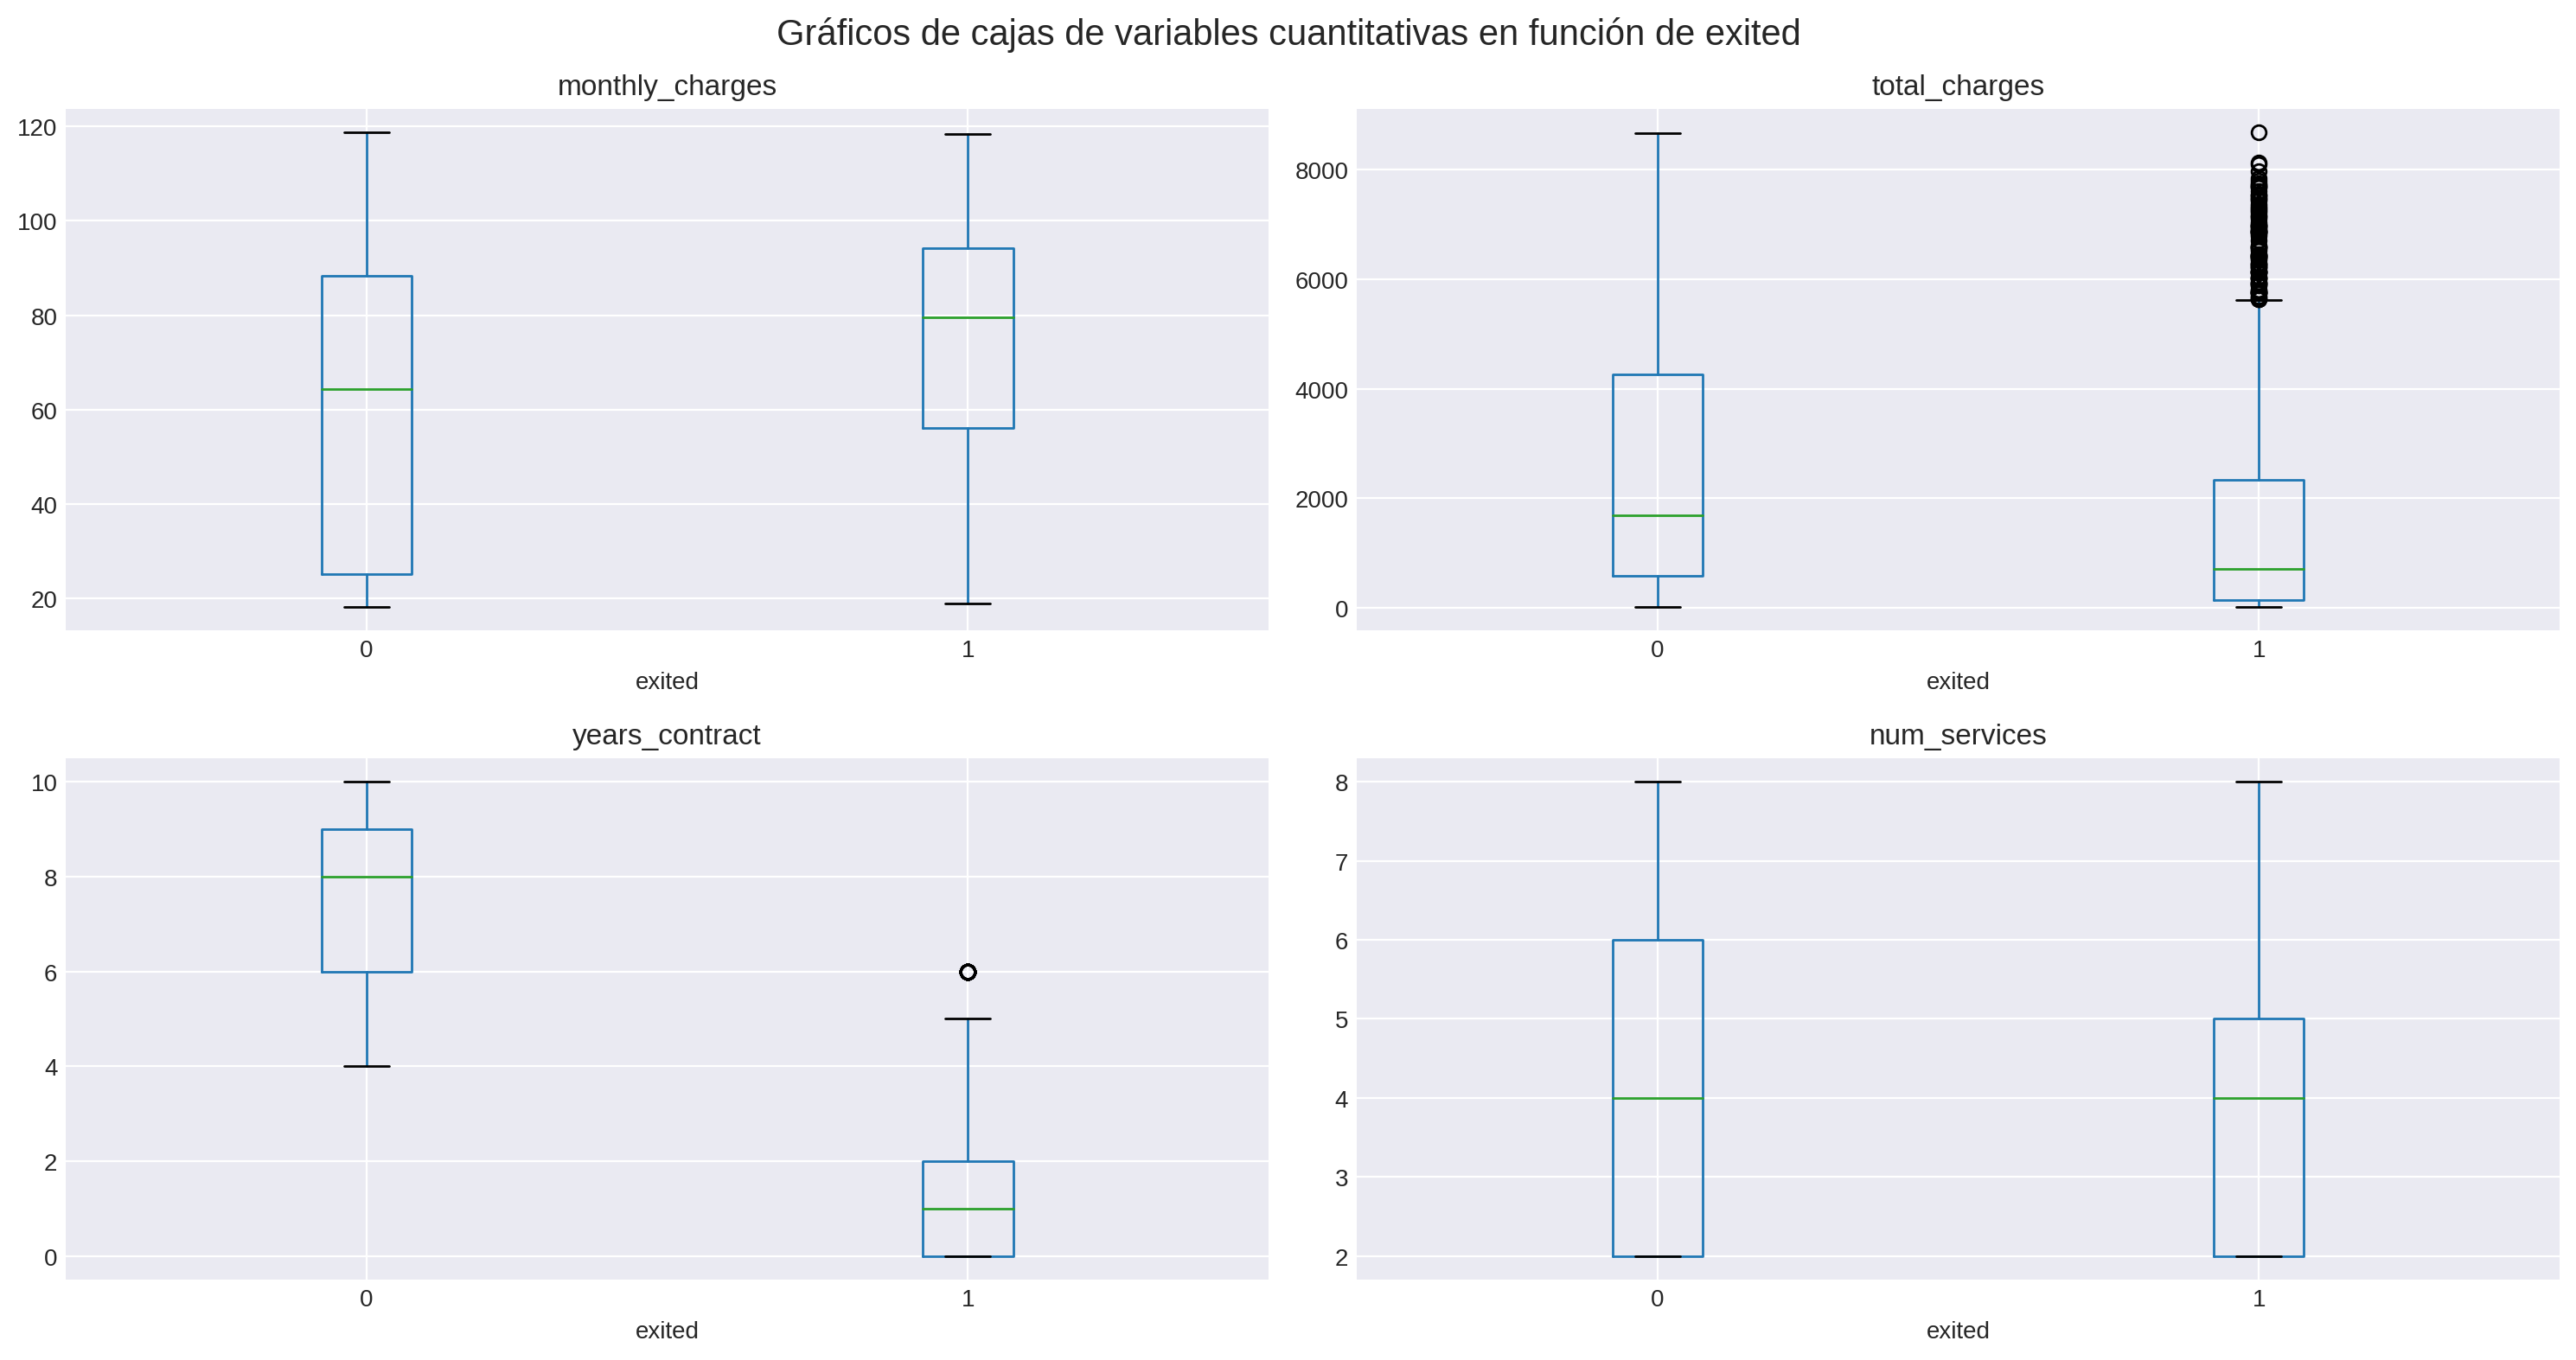

In [89]:
# Trazamos gráficos de cajas de cada variable cuantitativa en función de exited.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

for n, col in enumerate(num_features):
    ax = axes.flatten()[n]
    df.boxplot(column=col, by='exited', ax=ax)
    ax.set_title(col)

plt.suptitle('Gráficos de cajas de variables cuantitativas en función de exited', fontsize=15)
plt.tight_layout()

Todos los valores p obtenidos son inferiores a 0.05, por lo que aceptamos la hipótesis alternativa y existe una correlación entre las variables numéricas y nuestra variable objetivo categórica `exited`. A su vez, los valores de correlación son similares a los obtenidos en el análisis de correlación de Pearson, registrando una correlación positiva con `monthly_charges` y una correlación negativa con `total_charges`, `years_contract` y `num_services`.

Podemos verificar los resultados del análisis de correlación a través de gráficos de cajas, es así que para los cargos mensuales se observa una asimetría negativa, con un incremento de la tasa de cancelación a medida que aumenta el valor del monto a cobrar, sobretodo a partir de los 60 hasta los 100 dólares mensuales, corroborando la correlación positiva obtenida anteriormente. En el caso de los años de permanencia y los cargos totales, observamos una asimetría positiva, con una tasa más alta de cancelación a un menor número de años o cargos totales, coincidiendo con nuestra correlación negativa de Pearson. Hay que destacar la presencia de valroes atípicos en `total_charges`, indicando que son poco frecuentes los clientes que llegan a acumular cargos de más de 6000 dólares totales.

Finalmente, la correlación entre el número de servicios y la tasa de cancelación fue cercana a cero, pero aún así nuestra prueba de hipótesis arrojó un valor inferior a 0.05, pudiendo afirmar una relación entre el número de servicios y la probabilidad de cancelación de un cliente. Es así que en nuestro boxplot se observa un mayor número de usuarios que abandonan sus cuentas al contratatar entre 2 a 5 servicios, a menor número de servicios, mayor la tasa de cancelación.


### Analisis Variable Objetivo

Finalizaremos el análisis exploratorio de datos con un análisis de distribución de la variable objetivo para determinar si existe un desbalance de clases.

------------------------------------------------
Variable Objetivo
------------------------------------------------
   absolutos  relativos
0       5174    0.73463
1       1869    0.26537
------------------------------------------------


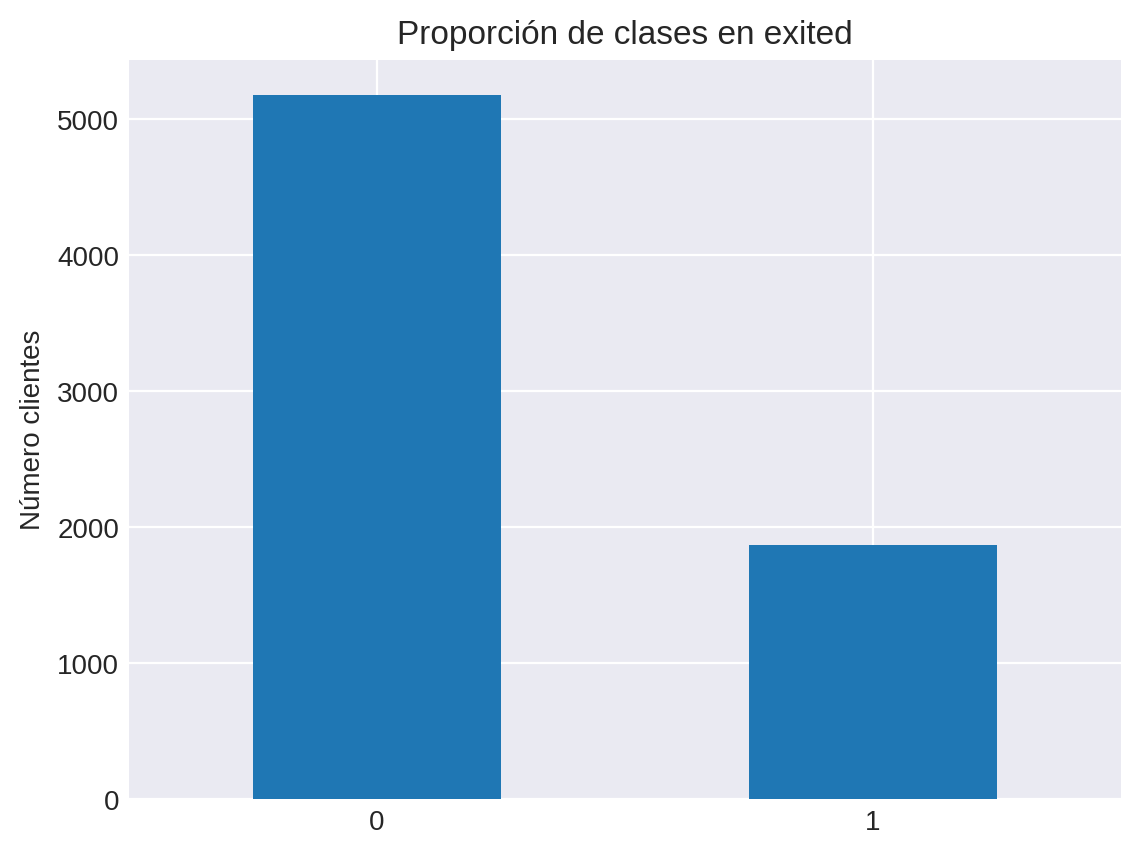

In [90]:
# Obtenemos el recuento de valores únicos absolutos y relativos para la variable MultipleLines
count_data = pd.DataFrame(df['exited'].value_counts())
count_data['relativos'] = df['exited'].value_counts(normalize=True)
count_data.columns = ['absolutos', 'relativos']
print('------------------------------------------------')
print('Variable Objetivo')
print('------------------------------------------------')
print(count_data)
print('------------------------------------------------')

#Trazamos un gráfico de barras 
df['exited'].value_counts().plot(kind='bar', rot=0, title='Proporción de clases en exited')
plt.ylabel('Número clientes')
plt.show()

Existe un desbalance de clases, con una tasa de cancelación del 26% y un 73% de clientes que no han abandonado sus cuentas. Si bien se recomienda aplicar técnicas como submuestreo, sobremuestreo o ajuste de peso de clases para mejorar la calidad del modelo. No las utilizaremos en este proyecto ya que introduciría un sesgo a nuestros datos, por esto trataremos de alcanzar una buena métrica a partir de otros métodos como ajuste de hiperparámetros y probando diferentes modelos, tanto tradicionales como de potenciación de gradiente.

# Plan de Trabajo

Como podemos observar la parte mas critica que observamos en los datos fue la ausencia de data en la columna `EndDate`, la cual presentaba `5174` valores ausentes, fuera de esto y de corregir las variables `BeginDate` y `EndDate`, para que representen `datetime` como deberia corresponder para que sea utilizable, podriamos pasar a estudiar los datos mas a fondo.

Luego de observar el histograma y graficos que utilizamos para poder estudiar la data, podemos concluir en que nuestro plan de trabajo deberia ser:

**Paso 1: Comprensión del problema y los datos**
1. **Definir el problema**: Comprender el objetivo del proyecto y qué se espera lograr.
2. **Revisar los datos**: Explorar la estructura y el contenido de los conjuntos de datos proporcionados para tener una idea inicial de las variables disponibles y su calidad.

**Paso 2: Preprocesamiento de datos**
1. **Lidiar con valores faltantes**: Identificar y decidir cómo manejar los valores faltantes en los datos.
2. **Exploración de características**: Analizar las características disponibles y seleccionar aquellas que puedan ser más relevantes para el objetivo del proyecto.
3. **Escalamiento de características**: Si es necesario, escalar las características para que tengan la misma importancia en el modelo.
4. **Dividir los datos**: Separar los datos en conjuntos de entrenamiento y prueba para evaluar el rendimiento del modelo.

**Paso 3: Construcción y evaluación del modelo**
1. **Selección de modelos**: Basandonos en el objetivo del proyecto y la naturaleza de los datos, elegir modelos adecuados para probar.
2. **Entrenamiento de modelos**: Entrenar varios modelos con los datos de entrenamiento y ajustar los hiperparámetros según sea necesario.
3. **Evaluación del rendimiento**: Evaluar el rendimiento de los modelos utilizando métricas relevantes, como precisión, recall, F1-score, AUC-ROC, etc.
4. **Selección del mejor modelo**: Comparar el rendimiento de los modelos y seleccionar el que mejor se ajuste al problema.

**Paso 4: Optimización del modelo**
1. **Ajuste de hiperparámetros**: Optimizar los hiperparámetros del modelo seleccionado para mejorar su rendimiento.
2. **Validación cruzada**: Utilizar la validación cruzada para verificar la estabilidad y generalización del modelo.
3. **Visualización del modelo**: Si es posible, visualizar el modelo para comprender mejor su funcionamiento y tomar decisiones más informadas.

**Paso 5: Interpretación de resultados y conclusiones**
1. **Interpretación de características importantes**: Identificar las características más importantes que contribuyen a las predicciones del modelo.
2. **Comunicación de resultados**: Presentar los resultados obtenidos de manera clara y comprensible, destacando las conclusiones clave y las implicaciones para el problema abordado.

## Entrenamiento de modelos

Una vez cumplido el preprocesamiento y análisis exploratorio de datos, procedemos a la construcción de modelos de machine learning que nos permitan predecir si un cliente abandonará o no los servicios de Interconnect. En este caso, trabajaremos con un modelo de aprendizaje automático supervisado para una tarea de clasificación binaria, es decir contaremos con un objetivo categórico que se encuentra definido en la variable `exited`.

Procederemos a entrenar varios modelos de machine learning que cumplan con lo establecido por la compañía. Es así que, compararemos modelos de árbol de decisión, bosque aleatorio y regresión lineal con métodos de potenciación de gradiente: LightGBM, CatBoost, XGBoost y HistGradientBoostingClassifier. También probaremos un modelo de redes neuronales de scikit-learn, MLPClassifier. Ya que contamos con una mayor prorpoción de características categóricas que numéricas, será necesario tomar en consideración el método de codificación y estandarización que se utilizará para cada modelo. Por lo que se generarán diferentes datasets preprocesados acorde al algoritmo de aprendizaje que se utilizará.

Para medir el rendimiento y calidad de cada modelo se utilizará como métrica principal AUC-ROC y también calcularemos la exactitud como métrica adicional. Entrenaremos cada modelo con ajuste de hiperparámetros, trazaremos gráficas y matrices de confusión para determinar el rendimiento de cada uno. Después, mediremos la calidad de cada modelo en el conjunto de prueba, y en base a esto escogeremos el modelo que alcance una métrica igual o mayor a 0.88 en el conjunto de prueba.


In [110]:
# Función para evaluar el modelo
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
        
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Precisión del {model_name}:", precision)
    print(f"F1-score del {model_name}:", f1)
    print(f"Recall del {model_name}:", recall)
    print(f"AUC-ROC del {model_name}:", auc_roc)
    print(f"Matriz de confusión del {model_name}:")
    print(conf_matrix)
    
    # Curvas de evaluación
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    precision_recall, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
    
    # Gráficos de las métricas
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    # Valor F1
    thresholds = np.arange(0.0, 1.1, 0.1)
    f1_scores = [f1_score(y_test, (y_pred_proba >= t).astype(int)) for t in thresholds]
    ax[0].plot(thresholds, f1_scores, marker='o', label=f'{model_name}, max={max(f1_scores):.2f} @ {thresholds[np.argmax(f1_scores)]:.2f}')
    ax[0].set_title("Valor F1")
    ax[0].set_xlabel("Threshold")
    ax[0].set_ylabel("F1")
    ax[0].legend()
    
    # Curva ROC
    ax[1].plot(fpr, tpr, label=f'{model_name}, AUC={auc_roc:.2f}')
    ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax[1].set_title("Curva ROC")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].legend()
    
    # PRC
    average_precision = average_precision_score(y_test, y_pred_proba)
    ax[2].plot(recall_pr, precision_recall, label=f'{model_name}, AP={average_precision:.2f}')
    ax[2].set_title("PRC")
    ax[2].set_xlabel("Recall")
    ax[2].set_ylabel("Precision")
    ax[2].legend()
    
    plt.tight_layout()
    plt.show()

In [91]:
# Dividimos los datos en características (X) y variable objetivo (y)
df_final = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)
X = df_final.drop('exited', axis=1)
y = df_final['exited']

# Dividimos los datos en conjuntos de entrenamiento y prueba de manera estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [92]:
# Codificar variables categóricas y convertir 'end_date' a variable binaria
df_processed = df.copy()
categorical_cols = ['gender', 'partner', 'dependents', 'internet_service', 'online_security', 
                    'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 
                    'streaming_movies', 'multiple_lines']
for col in categorical_cols:
    df_processed = pd.concat([df_processed, pd.get_dummies(df_processed[col], prefix=col)], axis=1)
    df_processed.drop(col, axis=1, inplace=True)
df_processed['contract_ended'] = (df_processed['end_date'] != datetime.now()).astype(int)
df_processed.drop(['customer_id', 'begin_date', 'end_date'], axis=1, inplace=True)

# Verificar valores faltantes y no numéricos
print(df_processed.isnull().sum())
print(df_processed.dtypes)

# Seleccionar columnas de tipo 'object'
categorical_cols = df_processed.select_dtypes(include=['object']).columns

# Crear variables dummy para las columnas categóricas
df_processed = pd.get_dummies(df_processed, columns=categorical_cols)

# Dividir los datos en características (X) y variable objetivo (y)
X = df_processed.drop(['exited', 'contract_ended'], axis=1)
y = df_processed['exited']

# Dividir los datos en conjuntos de entrenamiento y prueba de manera estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

type                            0
paperless_billing               0
payment_method                  0
monthly_charges                 0
total_charges                   0
senior_citizen                  0
years_contract                  0
num_services                    0
exited                          0
gender_Female                   0
gender_Male                     0
partner_No                      0
partner_Yes                     0
dependents_No                   0
dependents_Yes                  0
internet_service_DSL            0
internet_service_Fiber optic    0
online_security_No              0
online_security_Yes             0
online_backup_No                0
online_backup_Yes               0
device_protection_No            0
device_protection_Yes           0
tech_support_No                 0
tech_support_Yes                0
streaming_tv_No                 0
streaming_tv_Yes                0
streaming_movies_No             0
streaming_movies_Yes            0
multiple_lines

### DummyClassifier

In [93]:
# Crear un Dummy Classifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)

# Entrenar el modelo con los datos de entrenamiento
dummy_clf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = dummy_clf.predict(X_test)

# Calcular la precisión del modelo
precision = precision_score(y_test, y_pred)
print("Precisión del Dummy Classifier:", precision)

# Calcular el F1-score del modelo
f1 = f1_score(y_test, y_pred)
print("F1-score del Dummy Classifier:", f1)

# Calcular el recall del modelo
recall = recall_score(y_test, y_pred)
print("Recall del Dummy Classifier:", recall)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión del Dummy Classifier:")
print(conf_matrix)

Precisión del Dummy Classifier: 0.0
F1-score del Dummy Classifier: 0.0
Recall del Dummy Classifier: 0.0
Matriz de confusión del Dummy Classifier:
[[1552    0]
 [ 561    0]]


### Logistic Regression

In [94]:
# Modelo de regresión logística
model = LogisticRegression(max_iter=1000)

# RFE para selección de características
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X, y)

print("Número de características: %s" % (fit.n_features_))
print("Características seleccionadas: %s" % (fit.support_))
print("Ranking de características: %s" % (fit.ranking_))

# Características seleccionadas
selected_features = X.columns[fit.support_]
print("Características seleccionadas: ", selected_features)

# Dividir los datos en conjuntos de entrenamiento y prueba con las características seleccionadas
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

# Crear el clasificador de regresión logística
logistic_clf = LogisticRegression(random_state=42)

# Entrenar el modelo con los datos de entrenamiento
logistic_clf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_logistic = logistic_clf.predict(X_test)

# Calcular la precisión del modelo
precision_logistic = precision_score(y_test, y_pred_logistic)
print("Precisión del modelo de Regresión Logística:", precision_logistic)

# Calcular el F1-score del modelo
f1_logistic = f1_score(y_test, y_pred_logistic)
print("F1-score del modelo de Regresión Logística:", f1_logistic)

# Calcular el recall del modelo
recall_logistic = recall_score(y_test, y_pred_logistic)
print("Recall del modelo de Regresión Logística:", recall_logistic)

# Calcular la matriz de confusión
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)
print("Matriz de confusión del modelo de Regresión Logística:")
print(conf_matrix_logistic)

# Calcular el AUC-ROC del modelo
auc_roc_logistic = roc_auc_score(y_test, logistic_clf.predict_proba(X_test)[:, 1])
print("AUC-ROC del modelo de Regresión Logística:", auc_roc_logistic)

Número de características: 10
Características seleccionadas: [False False  True  True False False False  True False False False False
  True False False False  True False False False False  True False False
  True  True False  True False False False False False False False  True]
Ranking de características: [25 27  1  1 11 23 20  1  5  9  3  8  1 18 22  2  1 24 26 12 16  1 15 14
  1  1  4  1  7  6 13 19 10 17 21  1]
Características seleccionadas:  Index(['senior_citizen', 'years_contract', 'partner_No',
       'internet_service_Fiber optic', 'online_backup_Yes', 'streaming_tv_No',
       'streaming_movies_Yes', 'multiple_lines_No', 'type_Month-to-month',
       'payment_method_Mailed check'],
      dtype='object')
Precisión del modelo de Regresión Logística: 0.9785330948121646
F1-score del modelo de Regresión Logística: 0.9767857142857144
Recall del modelo de Regresión Logística: 0.9750445632798574
Matriz de confusión del modelo de Regresión Logística:
[[1540   12]
 [  14  547]]
AUC-RO

Precisión del Regresión Logística: 0.9768270944741533
F1-score del Regresión Logística: 0.9768270944741533
Recall del Regresión Logística: 0.9768270944741533
AUC-ROC del Regresión Logística: 0.9986791811382472
Matriz de confusión del Regresión Logística:
[[1539   13]
 [  13  548]]


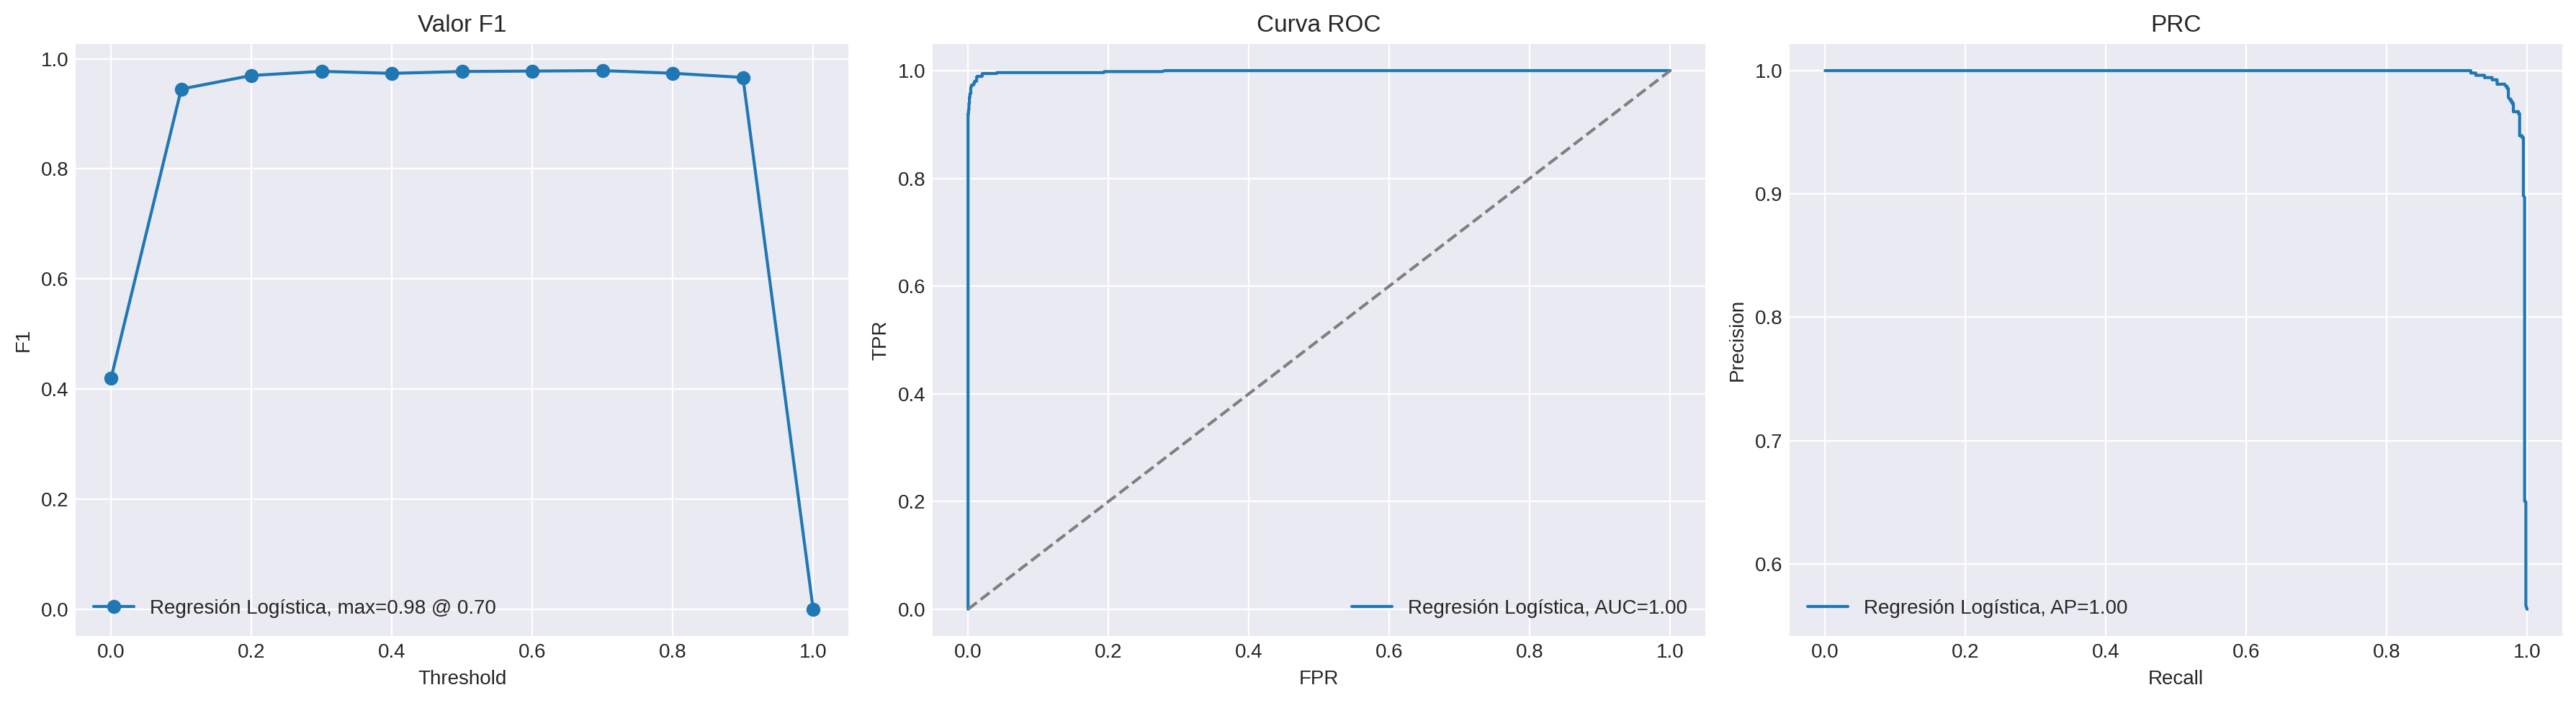

In [120]:
# Entrenamos nuestro primer modelo con los mejores hiperparámetros
logistic_clf = LogisticRegression(random_state=12345, 
                              solver='liblinear', 
                              penalty='l1', 
                              C=1.0,
                              )
logistic_clf.fit(X_train, y_train)

# Evaluamos el modelo en el conjunto de prueba a través de la función evaluate_model
evaluate_model(logistic_clf, X_train, y_train, X_test, y_test, 'Regresión Logística')

### Decision Tree Classifier

In [102]:
# Crear el clasificador de árbol de decisión
tree_clf = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo con los datos de entrenamiento
tree_clf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_tree = tree_clf.predict(X_test)

# Calcular la precisión del modelo
precision_tree = precision_score(y_test, y_pred_tree)
print("Precisión del modelo de Árbol de Decisión:", precision_tree)

# Calcular el F1-score del modelo
f1_tree = f1_score(y_test, y_pred_tree)
print("F1-score del modelo de Árbol de Decisión:", f1_tree)

# Calcular el recall del modelo
recall_tree = recall_score(y_test, y_pred_tree)
print("Recall del modelo de Árbol de Decisión:", recall_tree)

# Calcular la matriz de confusión
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
print("Matriz de confusión del modelo de Árbol de Decisión:")
print(conf_matrix_tree)

# Calcular el AUC-ROC del modelo
auc_roc_tree = roc_auc_score(y_test, tree_clf.predict_proba(X_test)[:, 1])
print("AUC-ROC del modelo de Árbol de Decisión:", auc_roc_tree)

Precisión del modelo de Árbol de Decisión: 0.9716312056737588
F1-score del modelo de Árbol de Decisión: 0.9742222222222221
Recall del modelo de Árbol de Decisión: 0.9768270944741533
Matriz de confusión del modelo de Árbol de Decisión:
[[1536   16]
 [  13  548]]
AUC-ROC del modelo de Árbol de Decisión: 0.9857173539518901


Precisión del Árbol de Decisión: 0.9595070422535211
F1-score del Árbol de Decisión: 0.9654561558901682
Recall del Árbol de Decisión: 0.9714795008912656
AUC-ROC del Árbol de Decisión: 0.9949912251686054
Matriz de confusión del Árbol de Decisión:
[[1529   23]
 [  16  545]]


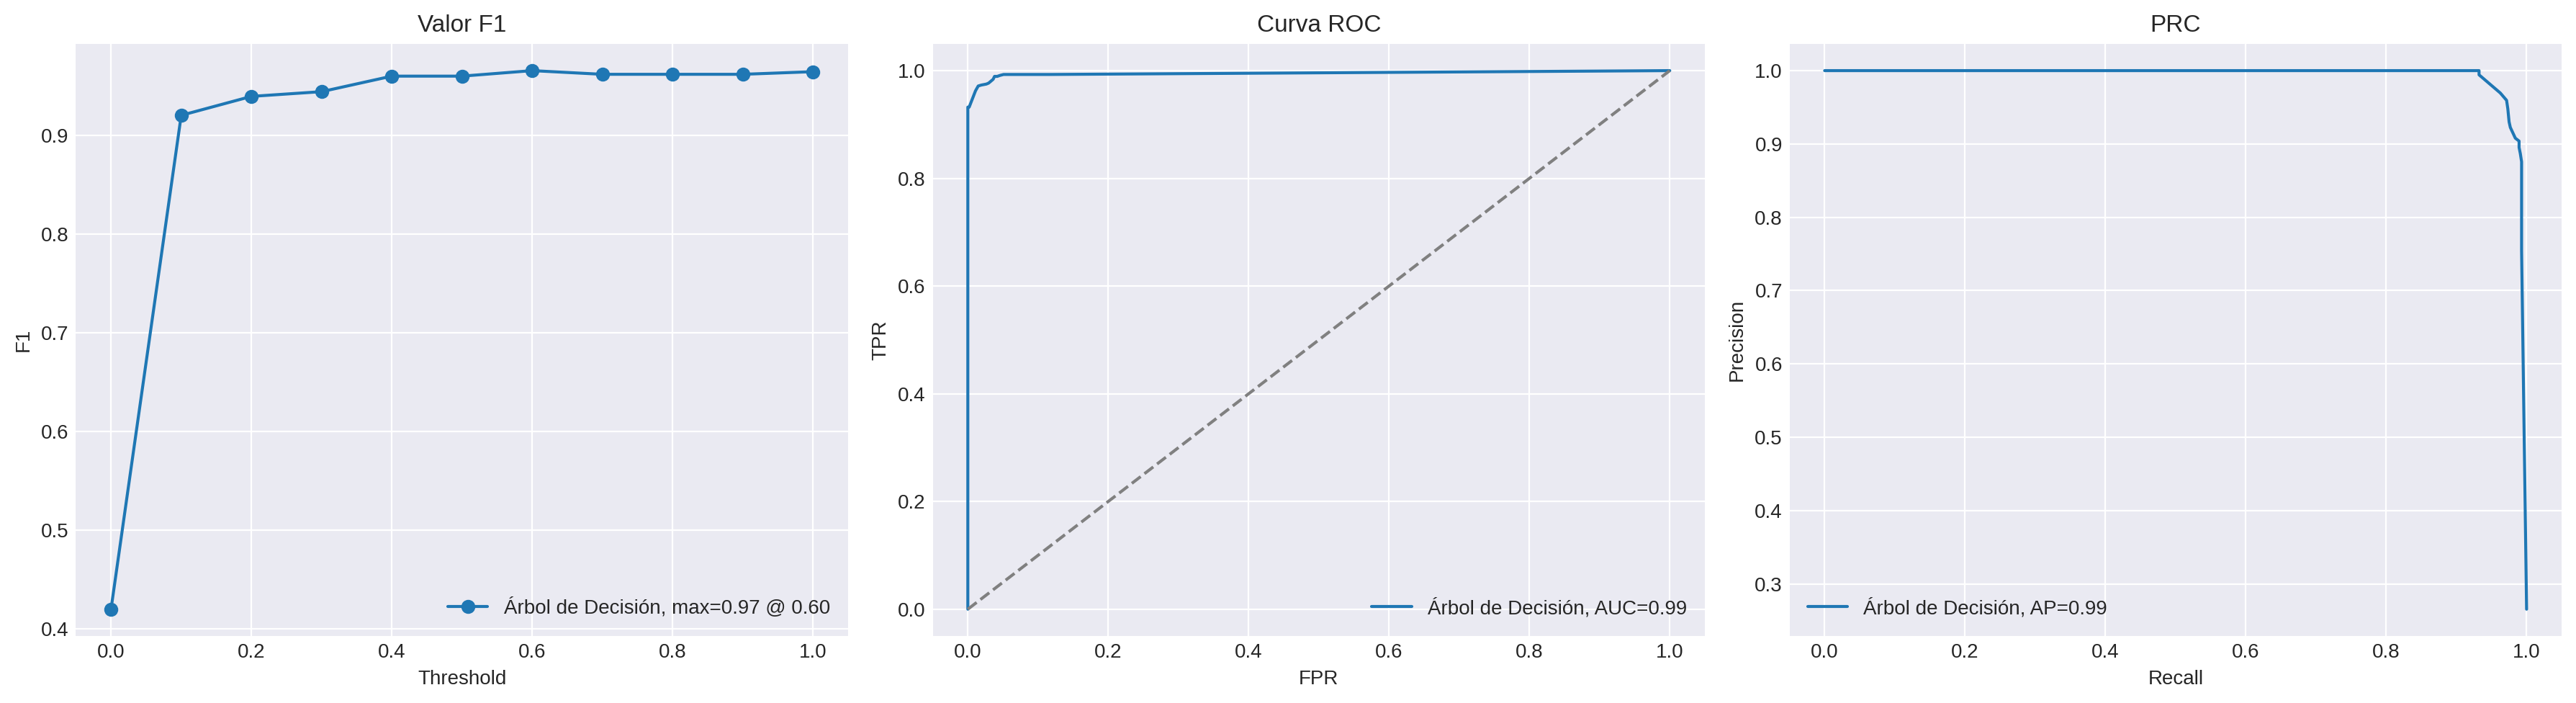

In [116]:
# Entrenamos nuestro primer modelo con los mejores hiperparámetros
tree_clf = DecisionTreeClassifier(random_state=12345, 
                                  criterion='gini', 
                                  max_depth=8, 
                                  min_samples_leaf=16, 
                                  min_samples_split=2
                                 )
tree_clf.fit(X_train, y_train)

# Evaluamos el modelo en el conjunto de prueba a través de la función evaluate_model
evaluate_model(tree_clf, X_train, y_train, X_test, y_test, 'Árbol de Decisión')

### Gradient Boosting Classifier

In [103]:
# Crear el clasificador de Gradient Boosting Machine
gbm_clf = GradientBoostingClassifier(random_state=42)

# Entrenar el modelo con los datos de entrenamiento
gbm_clf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_gbm = gbm_clf.predict(X_test)

# Calcular la precisión del modelo
precision_gbm = precision_score(y_test, y_pred_gbm)
print("Precisión del modelo de Gradient Boosting Machine:", precision_gbm)

# Calcular el F1-score del modelo
f1_gbm = f1_score(y_test, y_pred_gbm)
print("F1-score del modelo de Gradient Boosting Machine:", f1_gbm)

# Calcular el recall del modelo
recall_gbm = recall_score(y_test, y_pred_gbm)
print("Recall del modelo de Gradient Boosting Machine:", recall_gbm)

# Calcular la matriz de confusión
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)
print("Matriz de confusión del modelo de Gradient Boosting Machine:")
print(conf_matrix_gbm)

# Calcular el AUC-ROC del modelo
auc_roc_gbm = roc_auc_score(y_test, gbm_clf.predict_proba(X_test)[:, 1])
print("AUC-ROC del modelo de Gradient Boosting Machine:", auc_roc_gbm)

Precisión del modelo de Gradient Boosting Machine: 0.9785714285714285
F1-score del modelo de Gradient Boosting Machine: 0.9776984834968778
Recall del modelo de Gradient Boosting Machine: 0.9768270944741533
Matriz de confusión del modelo de Gradient Boosting Machine:
[[1540   12]
 [  13  548]]
AUC-ROC del modelo de Gradient Boosting Machine: 0.998669992833122


Precisión del Gradient Boosting: 0.9785714285714285
F1-score del Gradient Boosting: 0.9776984834968778
Recall del Gradient Boosting: 0.9768270944741533
AUC-ROC del Gradient Boosting: 0.998669992833122
Matriz de confusión del Gradient Boosting:
[[1540   12]
 [  13  548]]


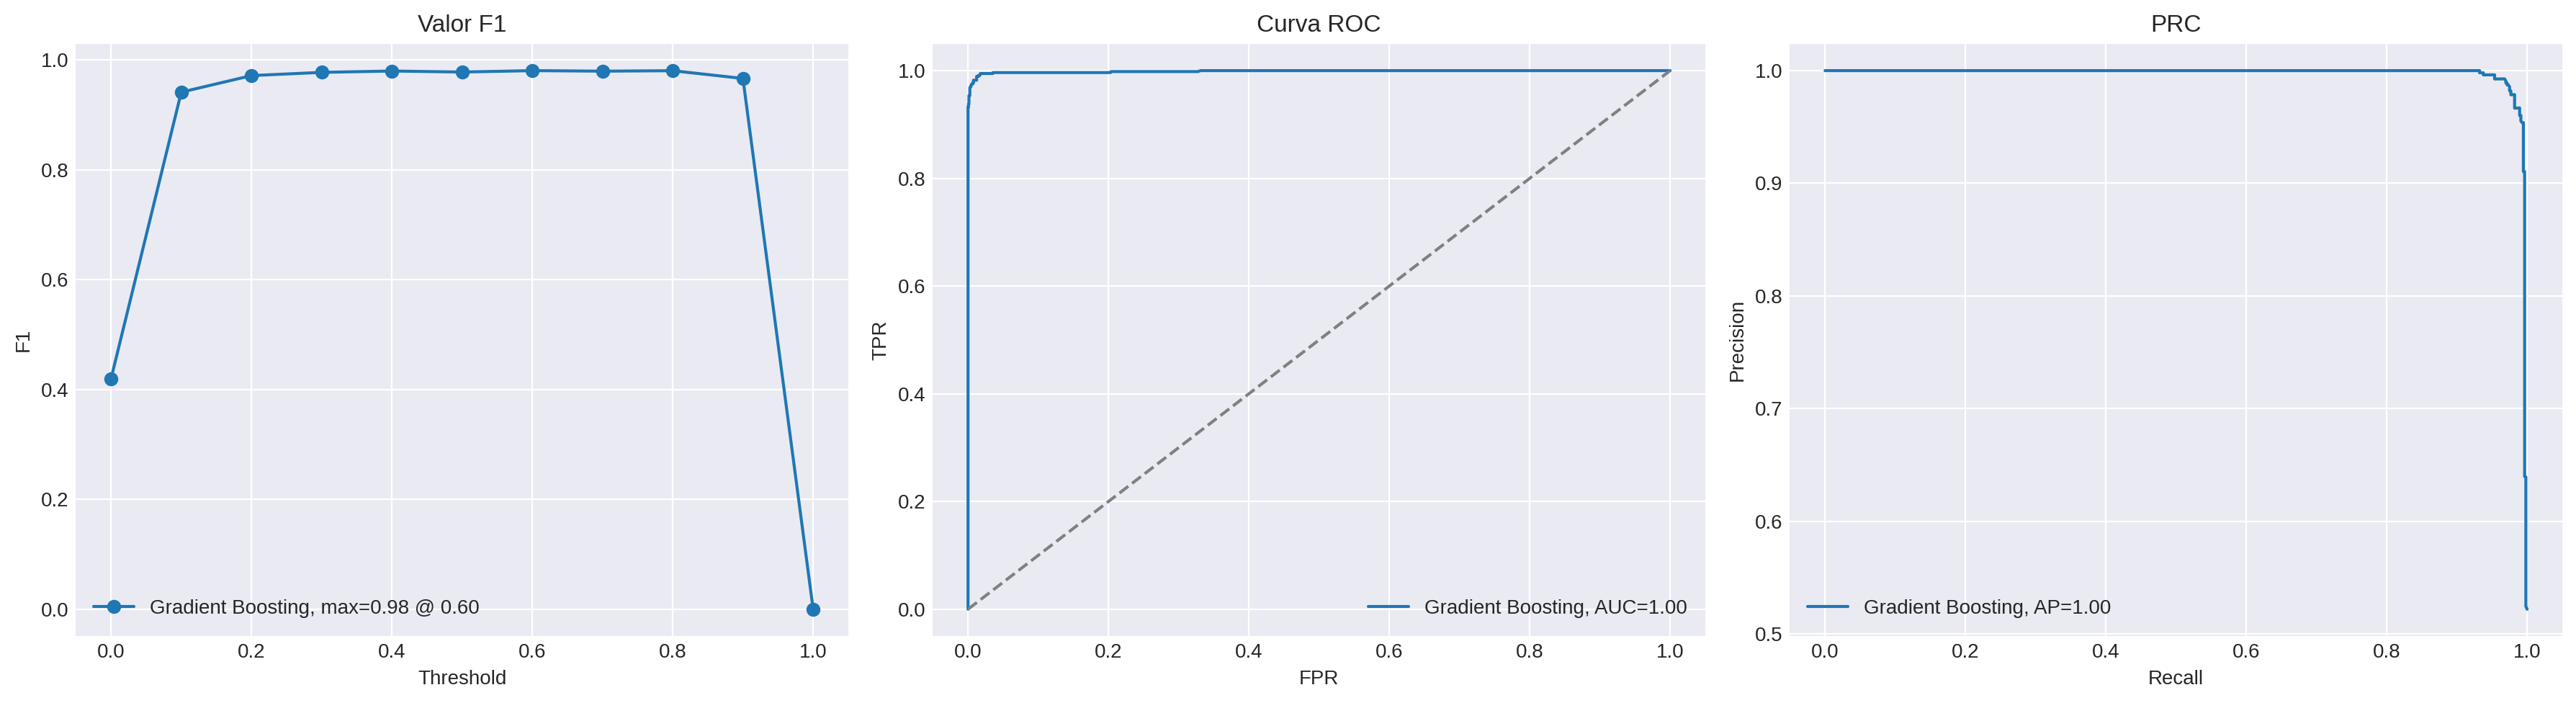

In [119]:
# Entrenamos nuestro primer modelo con los mejores hiperparámetros
gbm_clf = GradientBoostingClassifier(random_state=12345, 
                                     loss='deviance',
                                     learning_rate=0.1,
                                     max_leaf_nodes=10,
                                     n_estimators=100,
                                    )
gbm_clf.fit(X_train, y_train)

# Evaluamos el modelo en el conjunto de prueba a través de la función evaluate_model
evaluate_model(gbm_clf, X_train, y_train, X_test, y_test, 'Gradient Boosting')

## Analisis Modelos

In [121]:
# Trazamos una tabla con los valores de exactitud y AUC-ROC obtenidos por modelo
models_table = pd.DataFrame({
    'model': ['Dummy Classifier','Regresión Logística', 'Árbol de Decisión', 
               'HistGradientBoostingClassifier'],
    'Precisión' : [0, 0.9785, 0.9716, 0.9785],
    'F1-score' : [0, 0.9767, 0.9742, 0.9776],
    'Recall' : [0, 0.9750, 0.9768, 0.9768],
    'AUC-ROC' : [0, 0.9987, 0.9857, 0.9986],
     })

models_table

model  Precisión  F1-score  Recall  AUC-ROC
0                Dummy Classifier     0.0000    0.0000  0.0000   0.0000
1             Regresión Logística     0.9785    0.9767  0.9750   0.9987
2               Árbol de Decisión     0.9716    0.9742  0.9768   0.9857
3  HistGradientBoostingClassifier     0.9785    0.9776  0.9768   0.9986

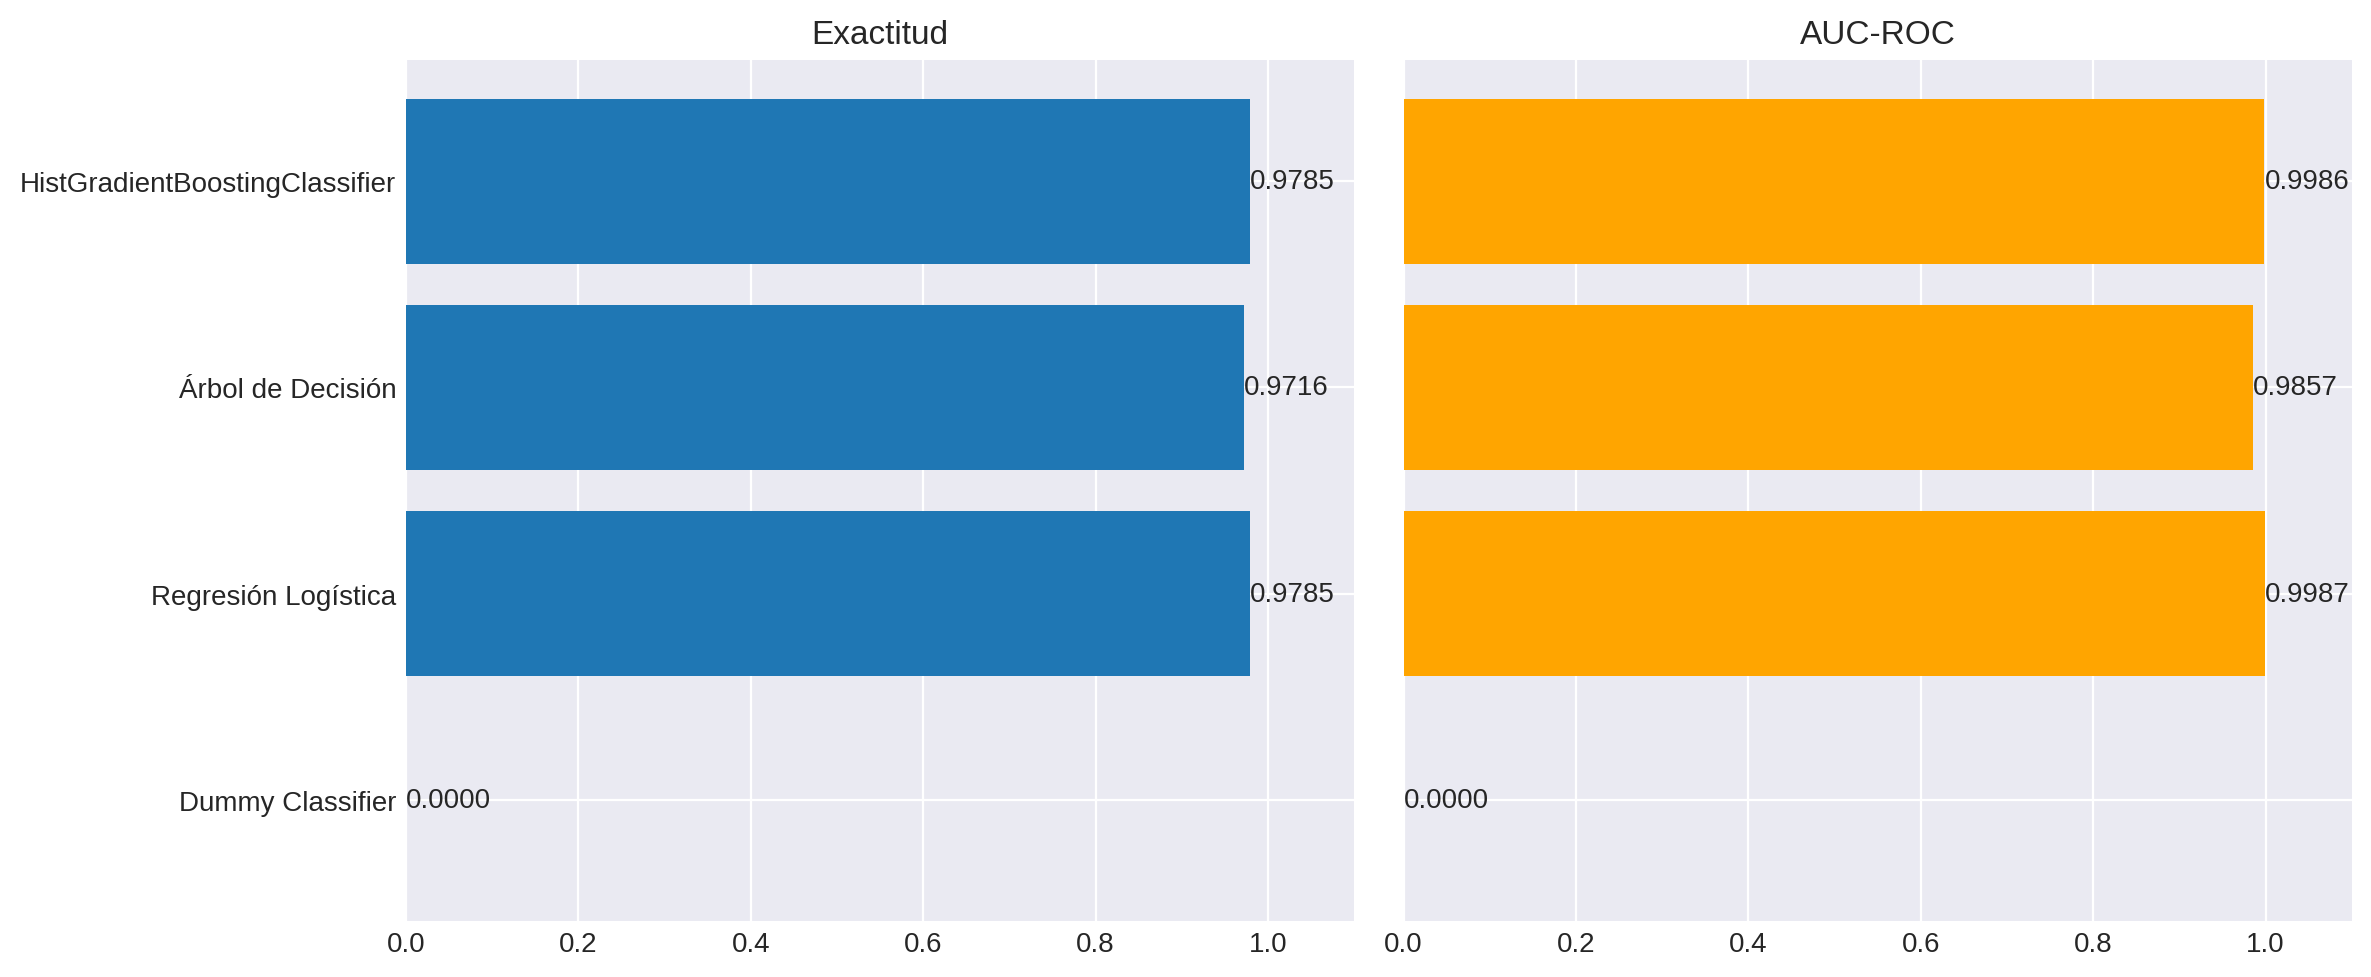

In [124]:
# Trazamos gráficos de barras para comparar la exactitud y AUC-ROC obtenidos
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Gráfico de Precisión
ax1 = ax[0]
bars1 = ax1.barh(models_table['model'], models_table['Precisión'])
ax1.set_xlim(0, 1.1)
ax1.set_title('Exactitud')
# Añadir etiquetas manualmente
for bar in bars1:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', 
             ha='left', va='center')

# Gráfico de AUC-ROC
ax2 = ax[1]
bars2 = ax2.barh(models_table['model'], models_table['AUC-ROC'], color='orange')
ax2.set_xlim(0, 1.1)
ax2.set_title('AUC-ROC')
# Añadir etiquetas manualmente
for bar in bars2:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', 
             ha='left', va='center')

fig.tight_layout()
plt.show()

Podemos determinar que tanto para la métrica de exactitud como para `AUC-ROC`, todos los modelos han superado la prueba de cordura y son mejores que la aleatoriedad. A su vez, todos los modelos alcanzaron una métrica superior al umbral establecido.

Sin embargo, se observaron diferencias en el rendimiento de cada modelo, aunque fueron sutiles, es así que modelos tradicionales como el árboles de decisión presento métricas inferiores a modelos de potenciación de gradiente o regresion logistica. Considerando esto, se puede establecer que el modelo de Regresión Logística fue el que alcanzó el mejor balance entre exactitud y detección de verdaderos positivos y falsos positivos.

En el caso de modelos de potenciación de gradiente, las métricas más altas correspondieron a HistGradientBoostingClassifier, con ligeras diferencias en los valores de métricas alcanzados. HistGradientBoostingClassifier alcanzó una buena métrica AUC-ROC con poco tiempo invertido en el ajuste y entrenamiento del modelo, por lo que se puede considerar como una buena opción para entrenar modelos clasificatorios. 

Algo importante a destacar fue la relación sensibilidad y precisión de todos los modelos, en los cuales se registró una mayor precisión y una menor sensibilidad, que se vio reflejada en los valores F1 obtenidos. Esto se puede atribuir al desbalance de clases registrado con solo un 26% de usuarios que cancelan sus cuentas, se podría mejorar esta métrica aplicando técnicas de sobremuestreo o ajuste de pesos de clase, sin embargo considerando que lo que busca nuestro modelo es identificar aquellos clientes con una mayor probabilidad de cancelación, una mayor precisión y relación VP/FP será mejor para crear planes especiales a un grupo específico de usuarios.

Finalmente, fueron cuatro las características más importantes en la construcción de modelos: `total_charges`, `years_contract`, `type` y `monthly_charges`.

## Conclusiones

**Preprocesamiento de datos**

    Se trabajó con cuatro datasets que contenían la información personal, tipo de contrato, servicios de internet y servicios de telefonía de 7043 clientes de la empresa de telecomunicaciones Interconnect. Solo 5517 usuarios hacían uso de servicios de internet y 6361 de servicios de telefonía. Se decidió combinar en un solo dataset toda la información disponible a través de la función merge.
    En nuestro nuevo dataset unificado se decidió corregir el nombre de las columnas para que mantengan un solo estilo a través de expresiones regulares. Posteriormente se corrigieron los tipos de datos de variables de fecha y de cargos totales.
    Los valores ausentes generados al combinar la informacion se relacionaban con el no uso de ese servicio por parte del usuario, así que se consideró pertinente generar una nueva clase no_service para rellenar los valores ausentes categóricos. En el caso de los valores NaN registrados en la variable total_charges, estos correspondían a aquellos usuarios que se registraron en la fecha máxima de inicio de contrato, por lo que fueron reemplazados por el valor mensual correspondiente.
    La variable end_date registraba la fecha de cancelación del contrato o cuenta y en caso de que el usuario continue con los servicios se presentaba la palabra No. A partir de esta información se construyó nuestra variable objetivo exited que contenía los valores 0 y 1 para indicar la cancelación o no de cuentas.
    Se generaron dos características o variables nuevas, es así que a partir de la fecha de inicio y fin del contrato se extrajo el número de años de suscripción del usuario. Por otro lado, a través de una función se calculó el número de servicios totales por usuario, incluyendo los servicios de internet y telefonía.

**Análisis Exploratorio**

    Se analizó el número de clientes nuevos registrados en cada mes, pudiendo establecer que no se presentaron cancelaciones por un período de cinco años. Es a partir del finales del año 2019 cuando hay un incremento significativo de usuarios que abandonan sus cuentas, es así que son sólo cuatro las fechas de cancelación correspondientes a los meses de octubre, noviembre, diciembre del 2019 y enero del 2020. En base a esto se puede inferir que cambios incorporados en el servicio a clientes durante estas fechas fueron los que desencadenaron un incremento de la tasa de cancelación.
    Al realizar un análisis univariado en función de la cancelación o no de cuentas en características categóricas, se pudo establecer que variables como el método, tipo de pago, facturación sin papel, internet de fibra óptica y el no uso de servicios varios, fueron los que presentaron una mayor proporción de abandono de cuentas. En base a esto se puede establecer que quizás el cambio a una facturación electrónica y sin facturación con papel, fue un factor determinante en el aumento de la cancelación de cuentas a finales del año 2019. Fallos en este sistema pudieron llevar a clientes a abandonar los servicios de la empresa.
    En el caso de características numéricas, se registró una mayor incidencia de abandono de cuentas en usuarios que presentaron cargos mensuales altos y cargos totales bajos. A su vez, usuarios con contratos inferiores a un año y con pocos servicios, fueron los que cancelaron más sus cuentas. En base a esto, podemos establecer que aquellos clientes que llevan más tiempo con la compañía y utilizan más servicios, tienen una menor probabilidad de abandonar sus cuentas.
    Se realizó una análisis de correlación de Pearson para variables continuas, un análisis chi-cuadrado para establecer la dependencia entre variables categóricas y un análisis pointbiserialr para determinar la correlación entre variables categóricas y continuas, pudiendo encontrar que todas las variables presentaron una correlación o dependencia con nuestra variable objetivo exited, exceptuando la variable gender.

**Entrenamiento modelos**

    Se construyeron cuatro modelos de aprendizaje automático para una tarea de clasificación binaria, para los cuales se codificaron y estandarizaron los datos de acuerdo a los requerimientos de cada modelo. Se dividió el dataset en conjuntos de entrenamiento y prueba en una proporción 70:30. Se registró un desbalance de clases, se decidió mantener este desbalance para que nuestro modelo aprenda a identificar la salida de clientes correctamente. Se escogió aquel modelo que generó un AUC-ROC mayor o igual a 0.88.
    Los valores de exactitud fueron de alrededor del 98%. Si bien la mayoría de modelos registró una mayor precisión y menor sensibilidad, consideramos necesario un ajuste de estas métricas, ya que en modelos que buscan dirigir planes o anuncios a un grupo selecto de usuarios, es mejor obtener una buena precisión y detección de VP/FP, por eso se intento utilizar SHAP y BORUTA sin exito.
    MEJOR MODELO: el modelo de "RegresionLogistica" alcanzó la mejor métrica AUC-ROC de 0.9987 y una precision de 0.9785. Por otro lado, a pesar de que el modelo alcanzó una excelente métrica, todavía se puede mejorar la detección, ya que aun la precision es demasiado alta para ser realmente verdadera.

## Informe de Solucion

**1. ¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?**

Se cumplio con todo el plan de trabajo trazado inicialmente, sin embargo se abordaron algunos temas de una manera algo diferente, como el tratamiento de la data, en el `EDA` se trato un poco la data, cuando vemos que se hizo el cambio de variables a `BeginDate` y `EndDate` para que pudieran ser utilies, pero principalmente estuvimos trabajando el input en los modelos para que fueran mas realistas, como podemos ver la mayoria de los modelos no cumplian con lo necesario para lograr el trabajo satisfactoriamente dado que su precision era demasiado alta e irreal, se construyeron y se ajustaron los modelos para clasificar los usuarios de acuerdo a la posibilidad de cancelacion.

**2. ¿Qué dificultades encontraste y cómo lograste resolverlas?**

Pues el hecho de tener el customerID en los DF en primera instancia complico el trabajo, ya que sobre la marcha descubri que era mejor tener 2 DF del mismo, uno con esta columna y otro sin ella, el que no la tenia fue permitente para trabajar con data mas limpia, y el que si la tenia, nos ayudo a revisar la relacion que habia entre la data, para asi poder llegar a las conclusiones que nos llevaron al modelado, tambien conseguir una precision mas realista fue un reto dado que al no poder por limitaciones de la plataforma, usar las tecnicas `SHAP` y `BORUTA` para lograr la meta, dado que con solamente exponer el modelo a la data no se lograba el cometido ya que su precision quedaba por las nubes siempre, tuve que imputar la data de una manera distinta utilizando `RFE`, para mejorar lo mas posible el outcome.

**3. ¿Cuáles fueron algunos de los pasos clave para resolver la tarea?**

* Preprocesamiento: Cambiar el tipo de datos, rellenar correctamente valores ausentes y cambiar el tipo de variable a la variable correcta.
* Análisis Exploratorio: Encontrar como se distribuyen las características en función de la variable objetivo para entender mejor como se comportan los usuarios de la empresa y encontrar patrones específicos que se relacionen a la salida de clientes.
* Procedimiento de evaluación: Creación de funciones que faciliten el entrenamiento y prueba de modelos.
* Entrenamiento y prueba de modelos: Ajuste de la data de entrada, métricas apropiadas, matrices de confusión, f1-score, AUC-ROC, etc, permitieron comparar los diferentes modelos y entender en que fallaba cada uno o que hacía a un modelo superior al otro.

**4. ¿Cuál es tu modelo final y qué nivel de calidad tiene?**

El modelo final que presentó la calidad más alta fue `LogisticRegression`, el cual obtuvo un AUC-ROC de 0.9987 y una precision de 0.9785.
